In [1]:
import warnings
warnings.simplefilter("ignore", Warning)
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from datetime import timedelta

In [2]:
res3_6 = pd.read_csv('results/res3_6.csv')
res4_6 = pd.read_csv('results/res4_6.csv')

res3_12 = pd.read_csv('results/res3_12.csv')
res4_12 = pd.read_csv('results/res4_12.csv')

res3_18 = pd.read_csv('results/res3_18.csv')
res4_18 = pd.read_csv('results/res4_18.csv')

res3_24 = pd.read_csv('results/res3_24.csv')
res4_24 = pd.read_csv('results/res4_24.csv')

res3_6['timestamp'] = pd.to_datetime(res3_6['timestamp'])
res4_6['timestamp'] = pd.to_datetime(res4_6['timestamp'])

res3_12['timestamp'] = pd.to_datetime(res3_12['timestamp'])
res4_12['timestamp'] = pd.to_datetime(res4_12['timestamp'])

res3_18['timestamp'] = pd.to_datetime(res3_18['timestamp'])
res4_18['timestamp'] = pd.to_datetime(res4_18['timestamp'])

res3_24['timestamp'] = pd.to_datetime(res3_24['timestamp'])
res4_24['timestamp'] = pd.to_datetime(res4_24['timestamp'])

In [3]:
def data_prep(df):
    count = 0
    main_list = []
    for i in range(len(df)):
        sel = df[((df.timestamp<=df.timestamp[i]) & (df.timestamp>(df.timestamp[i]-timedelta(hours=24))))].copy()
        lis=[]
        for j in range(0,24):
            a = sel[sel['timestamp']==sel['timestamp'].max()-timedelta(hours=j)]
            if j==0:
                lis.append(a.target.values[0])
                lis.append(a.goes_class.values[0])
            if a.size != 0:
                lis.append(a.flare_prob.values[0])
            else:
                lis.append(np.nan)
        main_list.append(lis)
    return main_list
            
res3_6 = data_prep(res3_6)
res4_6 = data_prep(res4_6)

res3_12 = data_prep(res3_12)
res4_12 = data_prep(res4_12)

res3_18 = data_prep(res3_18)
res4_18 = data_prep(res4_18)

res3_24 = data_prep(res3_24)
res4_24 = data_prep(res4_24)


In [35]:
# cols =['target', 'goes_class', 't-0', 't-1', 't-2', 't-3', 't-4', 't-5', 't-6',
#        't-7','t-8', 't-9', 't-10', 't-11', 't-12', 't-13', 't-14', 't-15', 't-16', 't-17', 't-18',
#        't-19','t-20', 't-21', 't-22', 't-23']
# def data_interpolate(lis):
#     df = pd.DataFrame(lis, columns = cols)
#     new_df = df.loc[:, ~df.columns.isin(['target', 'goes_class'])].copy()
#     new_df = new_df.dropna()
#     new_df['target'] = df['target'].astype('int')
#     new_df['goes_class'] = df['goes_class']
#     return new_df

# res3_6_new = data_interpolate(res3_6)
# res4_6_new = data_interpolate(res4_6)

# res3_12_new = data_interpolate(res3_12)
# res4_12_new = data_interpolate(res4_12)

# res3_18_new = data_interpolate(res3_18)
# res4_18_new = data_interpolate(res4_18)

# res3_24_new = data_interpolate(res3_24)
# res4_24_new = data_interpolate(res4_24)

In [42]:
cols =['target', 'goes_class', 't-0', 't-1', 't-2', 't-3', 't-4', 't-5', 't-6',
       't-7','t-8', 't-9', 't-10', 't-11', 't-12', 't-13', 't-14', 't-15', 't-16', 't-17', 't-18',
       't-19','t-20', 't-21', 't-22', 't-23']
def data_interpolate(lis):
    df = pd.DataFrame(lis, columns = cols)
    new_df = df.loc[:, ~df.columns.isin(['target', 'goes_class'])].copy()
    new_df = new_df.interpolate(axis=1, method='linear')
    new_df['target'] = df['target'].astype('int')
    new_df['goes_class'] = df['goes_class']
    return new_df

res3_6_new = data_interpolate(res3_6)
res4_6_new = data_interpolate(res4_6)

res3_12_new = data_interpolate(res3_12)
res4_12_new = data_interpolate(res4_12)

res3_18_new = data_interpolate(res3_18)
res4_18_new = data_interpolate(res4_18)

res3_24_new = data_interpolate(res3_24)
res4_24_new = data_interpolate(res4_24)

In [7]:
res3_6_new.to_csv(r'results/res_3_6_seq.csv', index=False, header=True, columns=cols)
res4_6_new.to_csv(r'results/res_4_6_seq.csv', index=False, header=True, columns=cols)

res3_12_new.to_csv(r'results/res_3_12_seq.csv', index=False, header=True, columns=cols)
res4_12_new.to_csv(r'results/res_4_12_seq.csv', index=False, header=True, columns=cols)

res3_18_new.to_csv(r'results/res_3_18_seq.csv', index=False, header=True, columns=cols)
res4_18_new.to_csv(r'results/res_4_18_seq.csv', index=False, header=True, columns=cols)

res3_24_new.to_csv(r'results/res_3_24_seq.csv', index=False, header=True, columns=cols)
res4_24_new.to_csv(r'results/res_4_24_seq.csv', index=False, header=True, columns=cols)

# Lasso Regression for Feature Selection

In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [9]:
def accuracy_score_with_conf_mat(prediction, target):
    TN, FP, FN, TP = confusion_matrix(target, prediction).ravel()

    #TSS Computation also known as "recall"
    tp_rate = TP / float(TP + FN) if TP > 0 else 0  
    fp_rate = FP / float(FP + TN) if FP > 0 else 0
    TSS = tp_rate - fp_rate
    
    #HSS2 Computation
    N = TN + FP
    P = TP + FN
    HSS = (2 * (TP * TN - FN * FP)) / float((P * (FN + TN) + (TP + FP) * N))

    return TSS, HSS, TP, FP, TN, FN

In [10]:
def plot_lasso_feature_importance(results, col, desc):
    fig, ax = plt.subplots()
    results[['Feature Name', str(col)]].plot.bar( ax=ax)
    ax.set_title(desc)
    ax.set_ylabel("Lasso Coefficients")
    ax.set_xlabel("(T-i) th instances before prediction window")
    fig.tight_layout()
#     plt.savefig('training_FS.jpg', dpi=500)
    plt.show()
    
def normalize_zero_one(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def threshold(y_pred):
    yp = np.where(y_pred >=0.5, 1, 0)
    return yp

# Create a function called lasso,
def lasso(X_tr, y_tr, X_test, y_test):
    
    names = list(X_tr.columns)
    # Create an empty data frame
    df = pd.DataFrame()
    
    # Create a column of feature names
    df['Feature Name'] = names
    
    
   
    # For each alpha value in the list of alpha values,
    
        
    # Create a lasso regression with that alpha value,
    lasso =LassoCV(cv=5, random_state=10, alphas=np.arange(0.0001, 1, 0.01))

    # Fit the lasso regression
    lasso.fit(X_tr, y_tr)
    y_pred_tr = lasso.predict(X_tr)
    y_pred_te = lasso.predict(X_test)

    #Evaluation
    TSS, HSS, TP, FP, TN, FN = accuracy_score_with_conf_mat(threshold(normalize_zero_one(y_pred_tr)), y_tr)
    print("Training: ", "TSS: ", TSS, "HSS: ", HSS, "TP: ", TP, "FP: ", FP, "TN: ", TN, "FN: ", FN)
    TSS, HSS, TP, FP, TN, FN = accuracy_score_with_conf_mat(threshold(normalize_zero_one(y_pred_te)), y_test)
    print("Testing: ", "TSS: ", TSS, "HSS: ", HSS, "TP: ", TP, "FP: ", FP, "TN: ", TN, "FN: ", FN)


    # Create a column name for that alpha value
    column_name = str(lasso.alpha_)

    # Create a column of coefficient values
    df[column_name] = np.abs(lasso.coef_)
        
    # Return the dataframe    
    return df, lasso.alpha_



In [43]:
def gen_data(train, test):
    for i in range(1, 24):
        X_tr = train.iloc[:, list(range(i+1))]
        y_tr =  train['target']
        X_test = test.iloc[:, list(range(i+1))]
        y_test =  test['target']
        results, col = lasso(X_tr, y_tr, X_test, y_test)
        plot_lasso_feature_importance(results, col,  f'Features Selection using first {i+1} instance')
        

Training:  TSS:  0.39303204723857577 HSS:  0.14542612238877817 TP:  583 FP:  3703 TN:  12041 FN:  345
Testing:  TSS:  0.5239960429712345 HSS:  0.1672253489351762 TP:  833 FP:  4765 TN:  10950 FN:  174


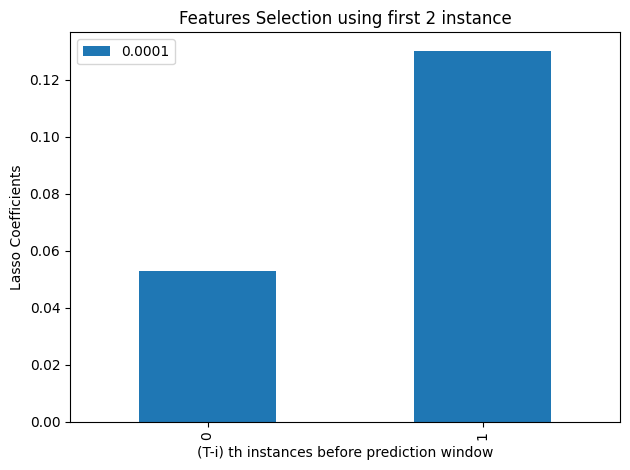

Training:  TSS:  0.3915120374264088 HSS:  0.1451905699839584 TP:  581 FP:  3693 TN:  12051 FN:  347
Testing:  TSS:  0.5228757273694384 HSS:  0.1668430737371204 TP:  832 FP:  4767 TN:  10948 FN:  175


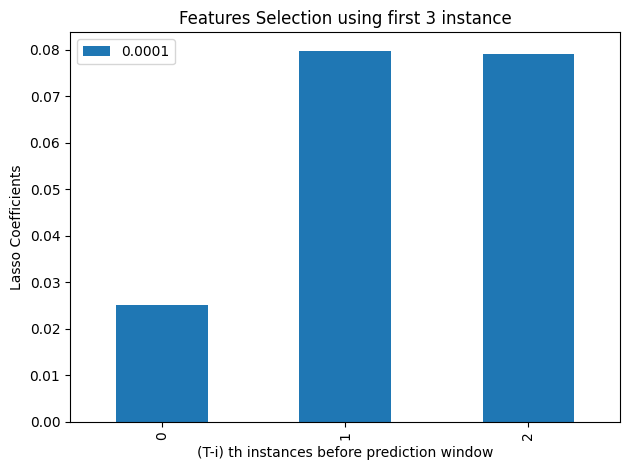

Training:  TSS:  0.39341533501541914 HSS:  0.14622634213531943 TP:  582 FP:  3680 TN:  12064 FN:  346
Testing:  TSS:  0.5238436891489133 HSS:  0.16670698350763355 TP:  834 FP:  4783 TN:  10932 FN:  173


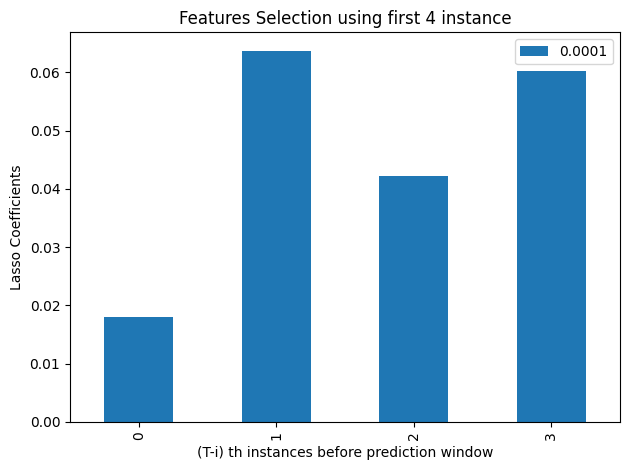

Training:  TSS:  0.3981702936641436 HSS:  0.1480774047458566 TP:  586 FP:  3673 TN:  12071 FN:  342
Testing:  TSS:  0.5196169606265527 HSS:  0.16536187775058372 TP:  830 FP:  4787 TN:  10928 FN:  177


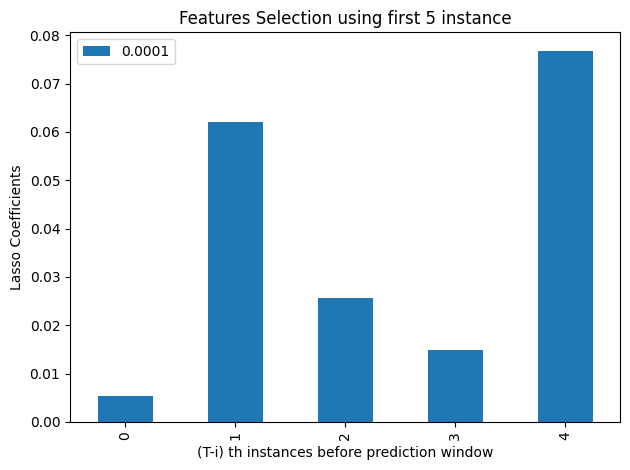

Training:  TSS:  0.40292306209700035 HSS:  0.14942229983552296 TP:  591 FP:  3683 TN:  12061 FN:  337
Testing:  TSS:  0.5143971834448078 HSS:  0.1637249590407934 TP:  825 FP:  4791 TN:  10924 FN:  182


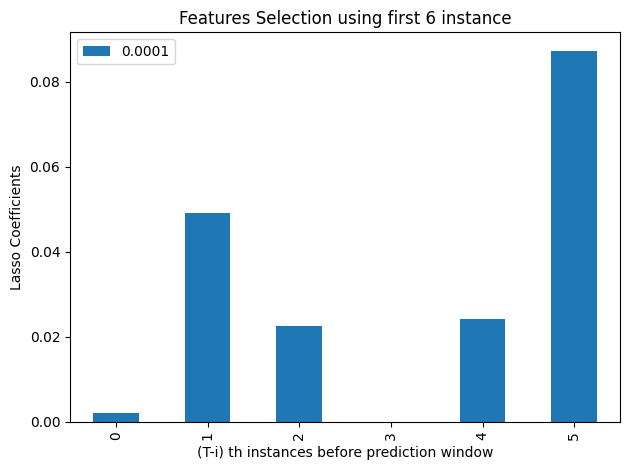

Training:  TSS:  0.41046835576114377 HSS:  0.15253593742941826 TP:  597 FP:  3666 TN:  12078 FN:  331
Testing:  TSS:  0.5116089378802724 HSS:  0.16298214166763647 TP:  822 FP:  4788 TN:  10927 FN:  185


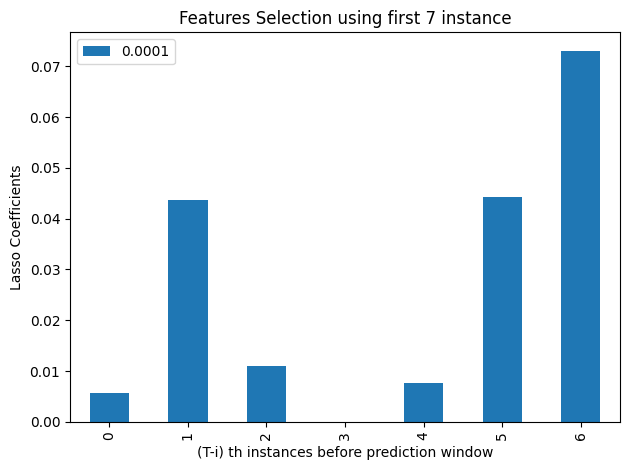

Training:  TSS:  0.4097061606391925 HSS:  0.15190921925456785 TP:  597 FP:  3678 TN:  12066 FN:  331
Testing:  TSS:  0.5147538973921335 HSS:  0.16357236279927795 TP:  826 FP:  4801 TN:  10914 FN:  181


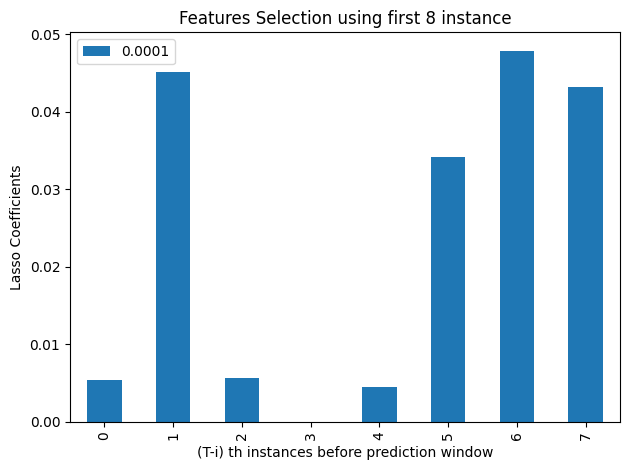

Training:  TSS:  0.4083131833473507 HSS:  0.15179224624042933 TP:  595 FP:  3666 TN:  12078 FN:  333
Testing:  TSS:  0.5113293171155396 HSS:  0.16238822148171636 TP:  823 FP:  4808 TN:  10907 FN:  184


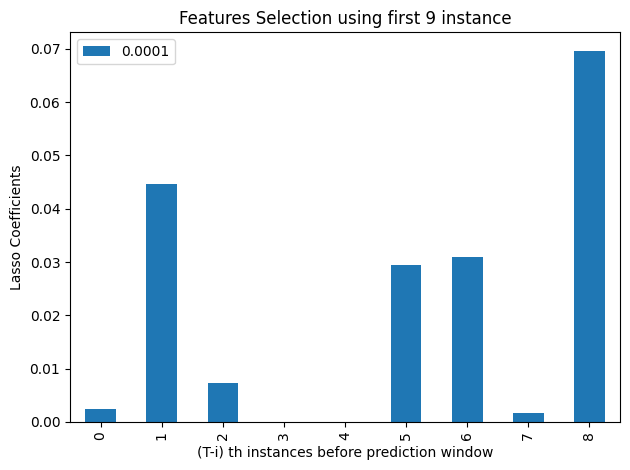

Training:  TSS:  0.4095156118587048 HSS:  0.15175298128968323 TP:  597 FP:  3681 TN:  12063 FN:  331
Testing:  TSS:  0.510018101100126 HSS:  0.16187624471470397 TP:  822 FP:  4813 TN:  10902 FN:  185


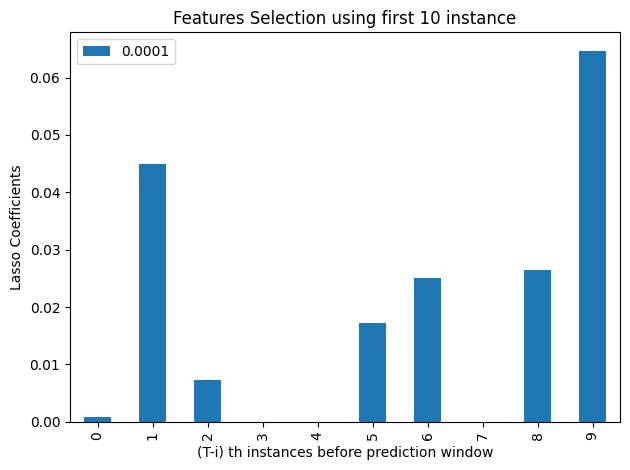

Training:  TSS:  0.4095178020745725 HSS:  0.15226877014562673 TP:  596 FP:  3664 TN:  12080 FN:  332
Testing:  TSS:  0.5033598409605557 HSS:  0.15964522428382008 TP:  816 FP:  4824 TN:  10891 FN:  191


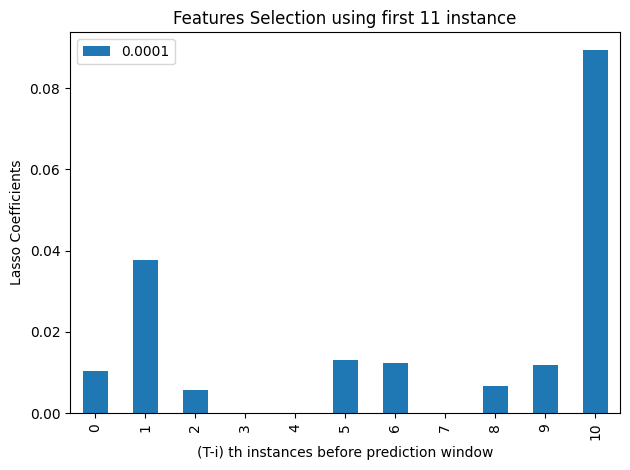

Training:  TSS:  0.40387580599943934 HSS:  0.15019925429817077 TP:  591 FP:  3668 TN:  12076 FN:  337
Testing:  TSS:  0.5001897945687852 HSS:  0.15863981478146774 TP:  813 FP:  4827 TN:  10888 FN:  194


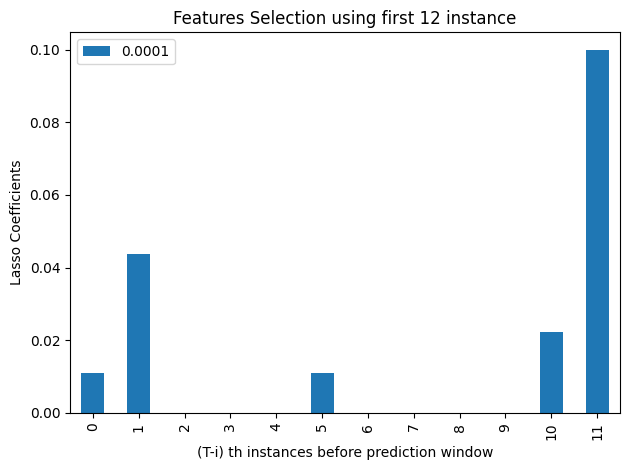

Training:  TSS:  0.40343119217830115 HSS:  0.1498361293167052 TP:  591 FP:  3675 TN:  12069 FN:  337
Testing:  TSS:  0.4982673307212225 HSS:  0.15809999293219265 TP:  811 FP:  4826 TN:  10889 FN:  196


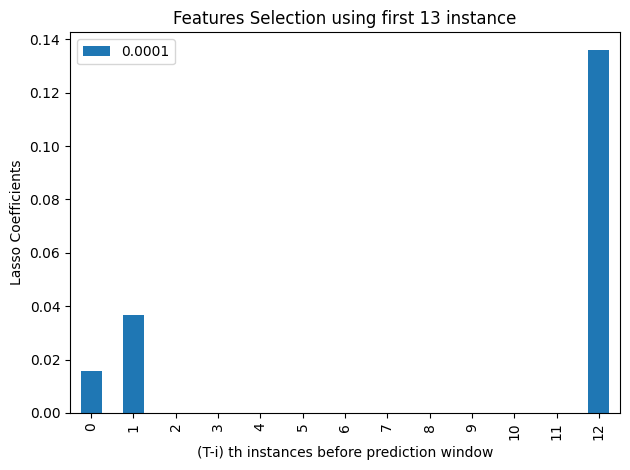

Training:  TSS:  0.40387580599943934 HSS:  0.15019925429817077 TP:  591 FP:  3668 TN:  12076 FN:  337
Testing:  TSS:  0.4953518182142755 HSS:  0.15726765957778904 TP:  808 FP:  4825 TN:  10890 FN:  199


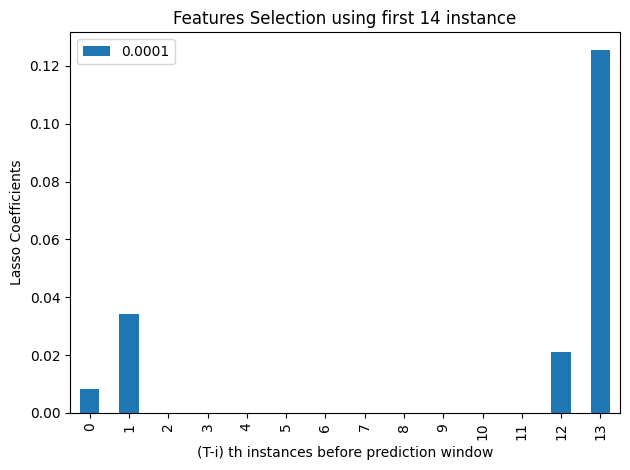

Training:  TSS:  0.4052709735071489 HSS:  0.1508318752437791 TP:  592 FP:  3663 TN:  12081 FN:  336
Testing:  TSS:  0.49881494508216584 HSS:  0.15808726907014353 TP:  812 FP:  4833 TN:  10882 FN:  195


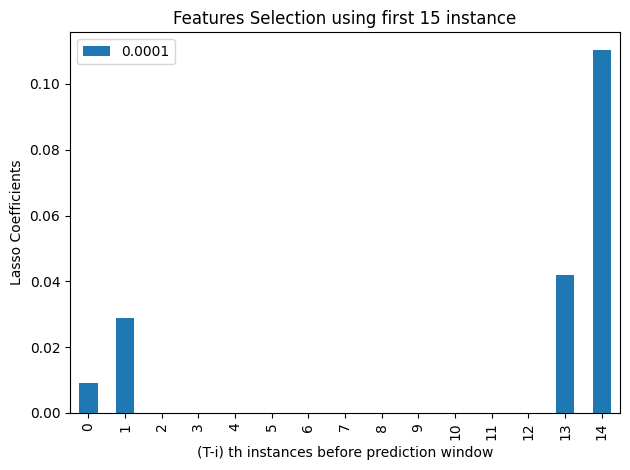

Training:  TSS:  0.4067931735351836 HSS:  0.15157001356713692 TP:  593 FP:  3656 TN:  12088 FN:  335
Testing:  TSS:  0.505091404394501 HSS:  0.16005286801851917 TP:  818 FP:  4828 TN:  10887 FN:  189


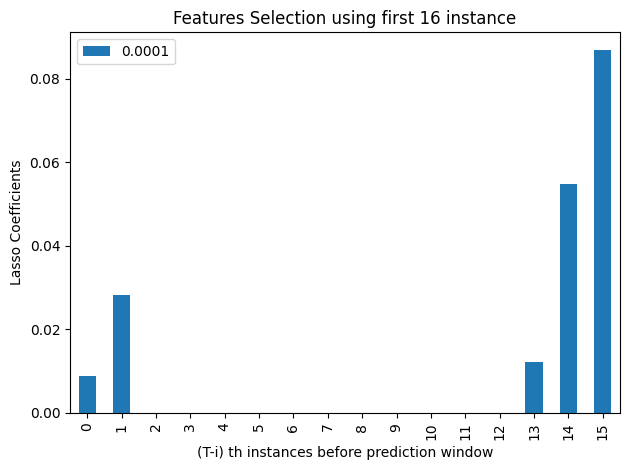

Training:  TSS:  0.4024149320156995 HSS:  0.1490097134937029 TP:  591 FP:  3691 TN:  12053 FN:  337
Testing:  TSS:  0.5116860310628655 HSS:  0.16223812904603102 TP:  824 FP:  4818 TN:  10897 FN:  183


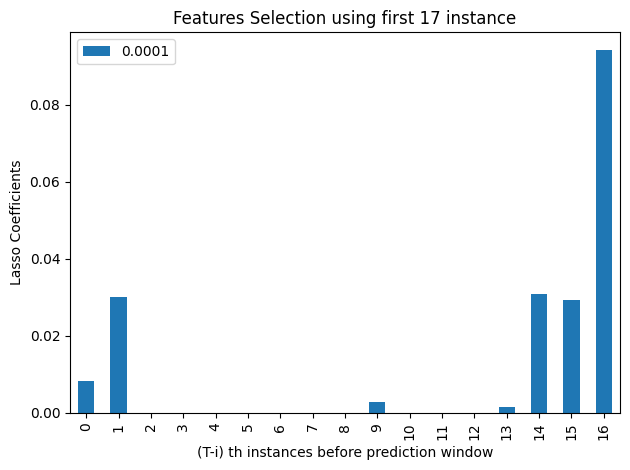

Training:  TSS:  0.4036721159237454 HSS:  0.14704575318793137 TP:  597 FP:  3773 TN:  11971 FN:  331
Testing:  TSS:  0.5167534544222893 HSS:  0.1633634268334403 TP:  830 FP:  4832 TN:  10883 FN:  177


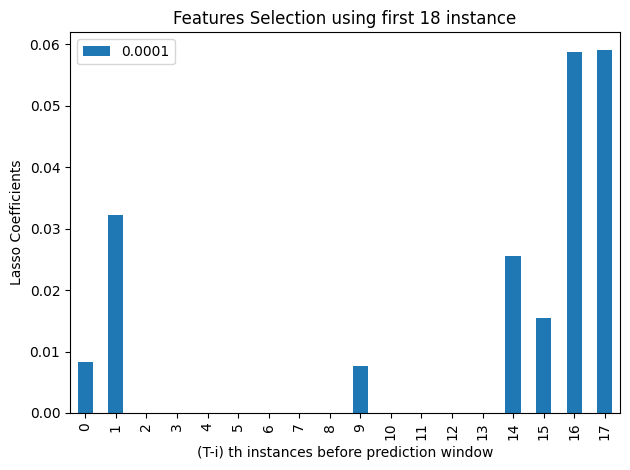

Training:  TSS:  0.4058229079058032 HSS:  0.14679891237177112 TP:  601 FP:  3807 TN:  11937 FN:  327
Testing:  TSS:  0.5197962338716481 HSS:  0.1642770855260253 TP:  833 FP:  4831 TN:  10884 FN:  174


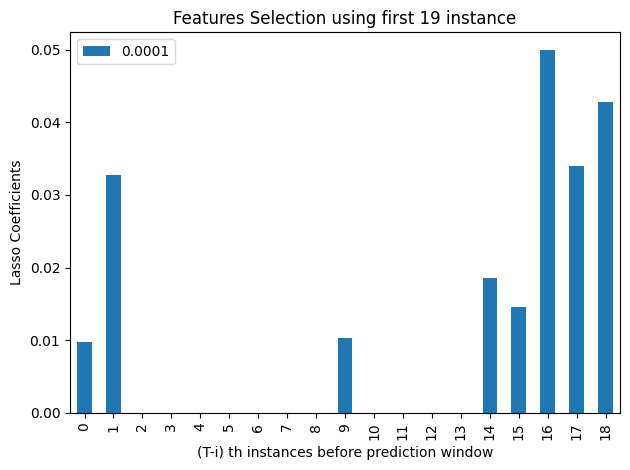

Training:  TSS:  0.4027850784973367 HSS:  0.14683110933329502 TP:  596 FP:  3770 TN:  11974 FN:  332
Testing:  TSS:  0.5219732316040342 HSS:  0.1649893382091591 TP:  835 FP:  4828 TN:  10887 FN:  172


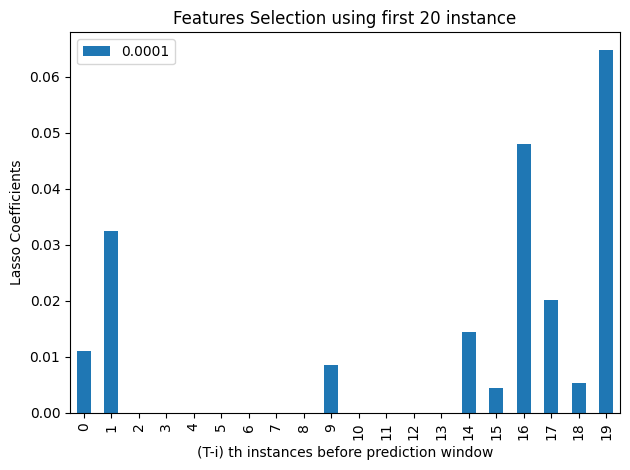

Training:  TSS:  0.3982206686291001 HSS:  0.14516720120912785 TP:  592 FP:  3774 TN:  11970 FN:  336
Testing:  TSS:  0.523220814148242 HSS:  0.16545659470352866 TP:  836 FP:  4824 TN:  10891 FN:  171


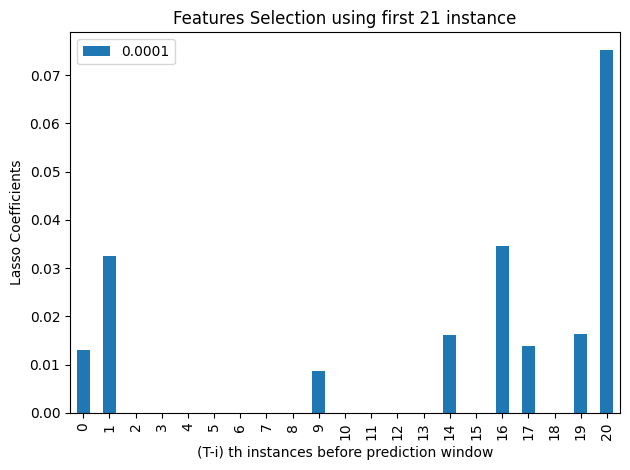

Training:  TSS:  0.39296634076254555 HSS:  0.1448853576710651 TP:  584 FP:  3721 TN:  12023 FN:  344
Testing:  TSS:  0.5236411615667736 HSS:  0.16534653803171864 TP:  837 FP:  4833 TN:  10882 FN:  170


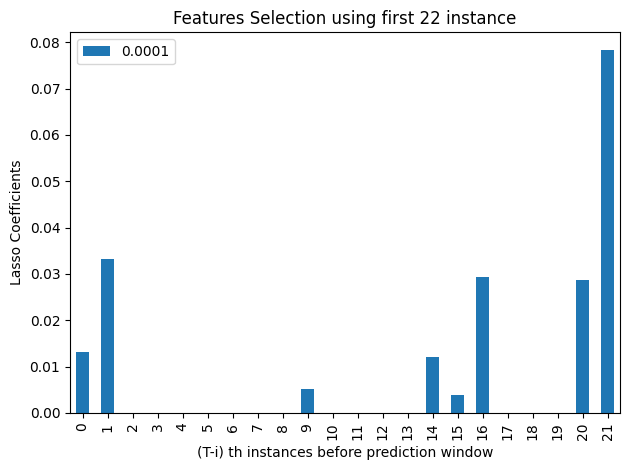

Training:  TSS:  0.39962678721614797 HSS:  0.14825564388744075 TP:  588 FP:  3684 TN:  12060 FN:  340
Testing:  TSS:  0.5246727568174543 HSS:  0.16526003038311285 TP:  839 FP:  4848 TN:  10867 FN:  168


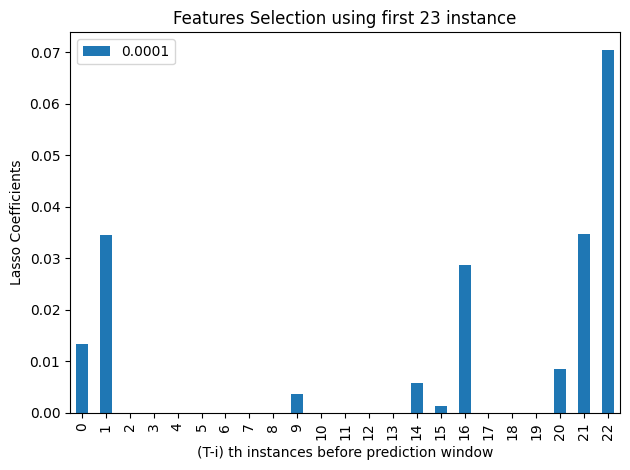

Training:  TSS:  0.4030544750490608 HSS:  0.15054672122698542 TP:  589 FP:  3647 TN:  12097 FN:  339
Testing:  TSS:  0.5200256808765622 HSS:  0.1640364107252435 TP:  834 FP:  4843 TN:  10872 FN:  173


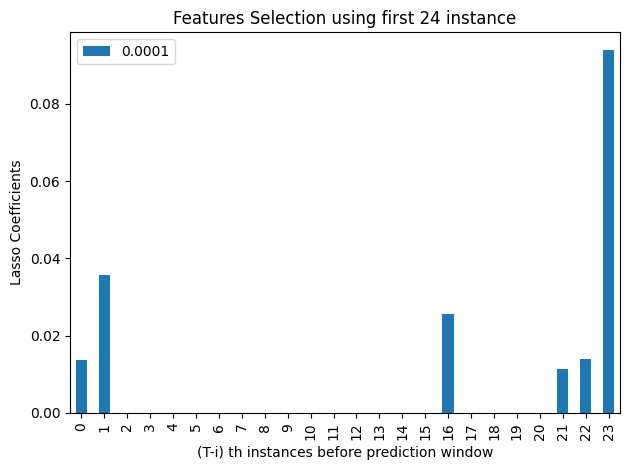

Training:  TSS:  0.52649120805965 HSS:  0.16817128602886033 TP:  835 FP:  4757 TN:  10958 FN:  172
Testing:  TSS:  0.3920814935520045 HSS:  0.14515610474203097 TP:  582 FP:  3701 TN:  12043 FN:  346


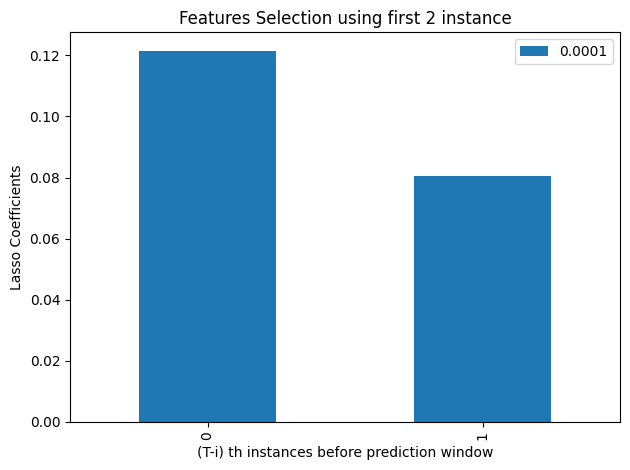

Training:  TSS:  0.5253458055779445 HSS:  0.1673582656002006 TP:  835 FP:  4775 TN:  10940 FN:  172
Testing:  TSS:  0.3911309398654331 HSS:  0.14488578280722136 TP:  581 FP:  3699 TN:  12045 FN:  347


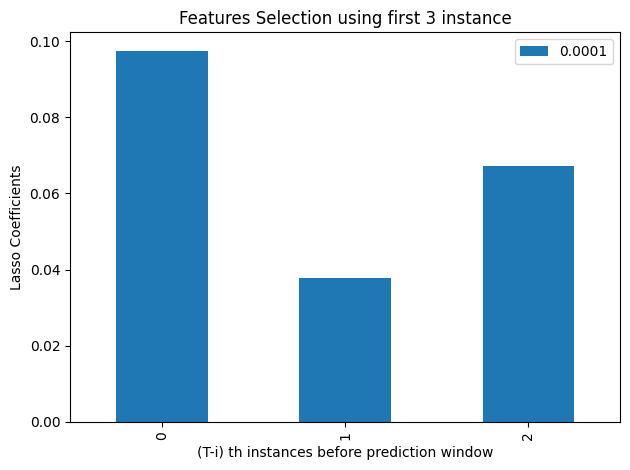

Training:  TSS:  0.529254366744276 HSS:  0.16847869871556978 TP:  839 FP:  4776 TN:  10939 FN:  168
Testing:  TSS:  0.39265313989346795 HSS:  0.14561374296911486 TP:  582 FP:  3692 TN:  12052 FN:  346


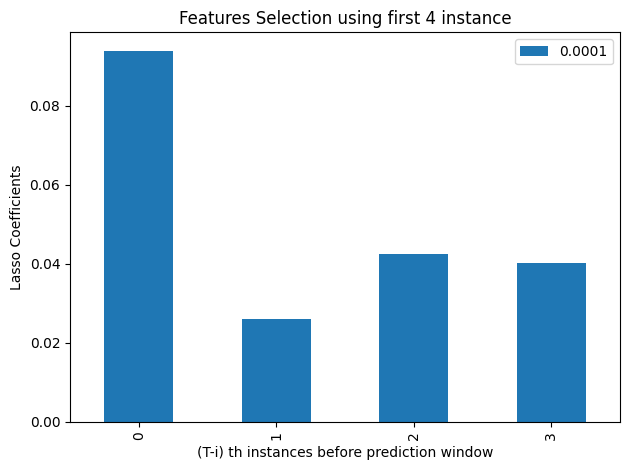

Training:  TSS:  0.529254366744276 HSS:  0.16847869871556978 TP:  839 FP:  4776 TN:  10939 FN:  168
Testing:  TSS:  0.39265313989346795 HSS:  0.14561374296911486 TP:  582 FP:  3692 TN:  12052 FN:  346


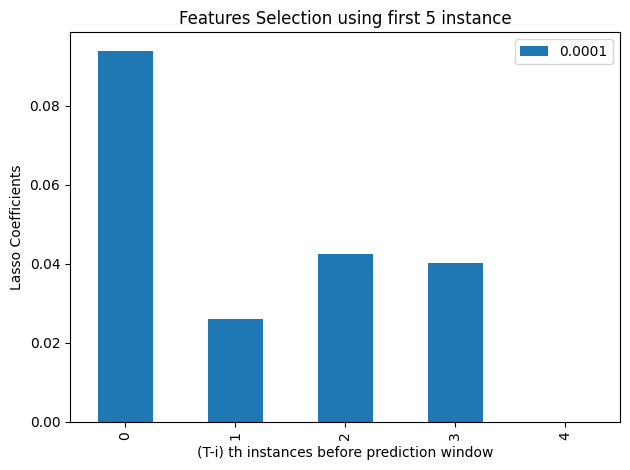

Training:  TSS:  0.5216917782964365 HSS:  0.16641593737268637 TP:  831 FP:  4770 TN:  10945 FN:  176
Testing:  TSS:  0.39652106111578356 HSS:  0.14724194820156405 TP:  585 FP:  3682 TN:  12062 FN:  343


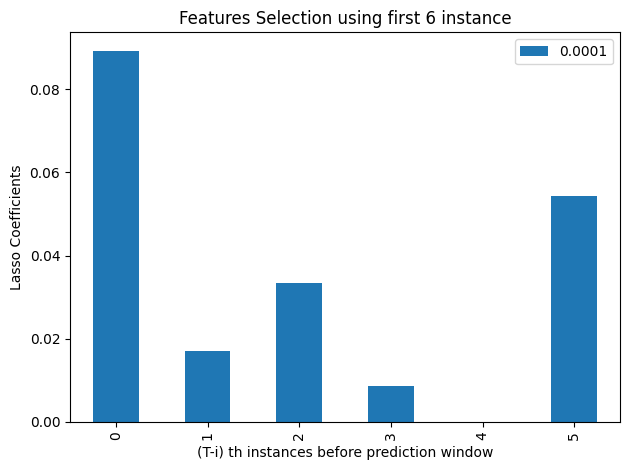

Training:  TSS:  0.522850640489529 HSS:  0.1664155684627414 TP:  833 FP:  4783 TN:  10932 FN:  174
Testing:  TSS:  0.4028595458368377 HSS:  0.14937065867363863 TP:  591 FP:  3684 TN:  12060 FN:  337


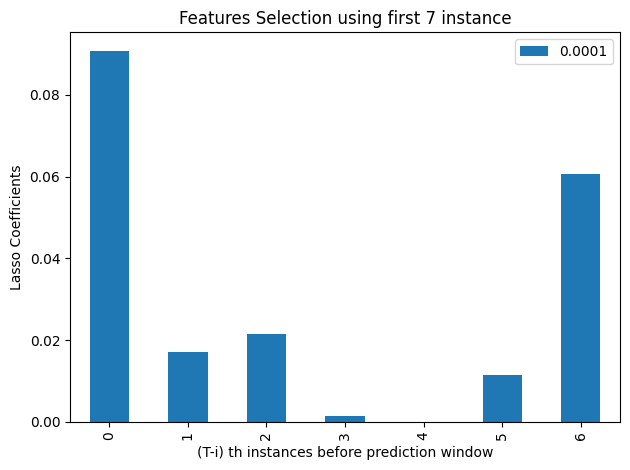

Training:  TSS:  0.5238436891489133 HSS:  0.16670698350763355 TP:  834 FP:  4783 TN:  10932 FN:  173
Testing:  TSS:  0.4036830670030839 HSS:  0.14953543994470064 TP:  592 FP:  3688 TN:  12056 FN:  336


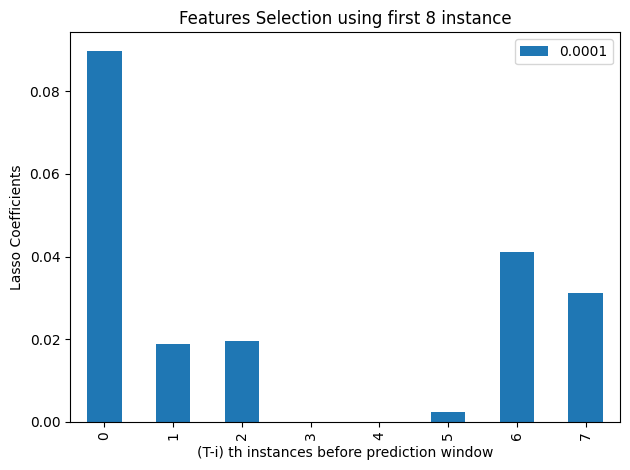

Training:  TSS:  0.52358915526409 HSS:  0.1665274717337146 TP:  834 FP:  4787 TN:  10928 FN:  173
Testing:  TSS:  0.40457010442949254 HSS:  0.14975151805040982 TP:  593 FP:  3691 TN:  12053 FN:  335


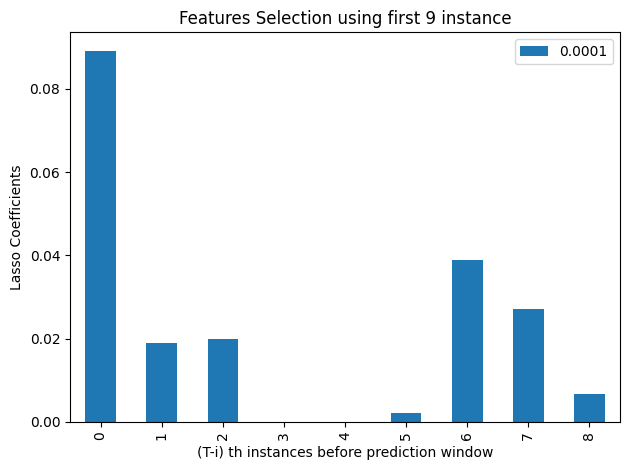

Training:  TSS:  0.52358915526409 HSS:  0.1665274717337146 TP:  834 FP:  4787 TN:  10928 FN:  173
Testing:  TSS:  0.40457010442949254 HSS:  0.14975151805040982 TP:  593 FP:  3691 TN:  12053 FN:  335


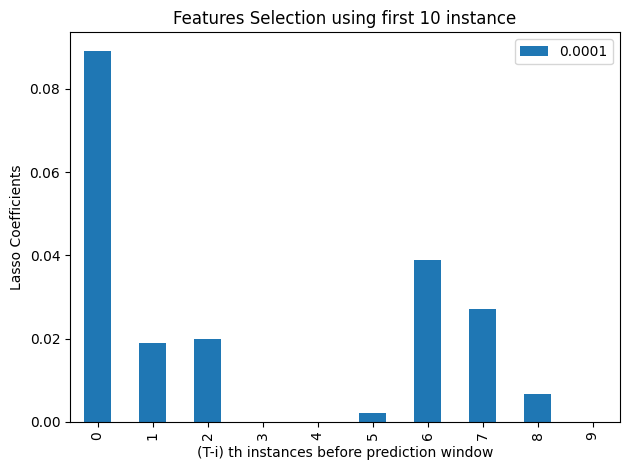

Training:  TSS:  0.52358915526409 HSS:  0.1665274717337146 TP:  834 FP:  4787 TN:  10928 FN:  173
Testing:  TSS:  0.40457010442949254 HSS:  0.14975151805040982 TP:  593 FP:  3691 TN:  12053 FN:  335


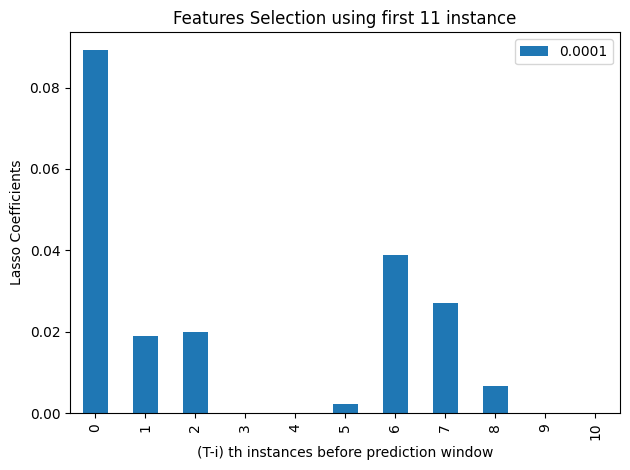

Training:  TSS:  0.52358915526409 HSS:  0.1665274717337146 TP:  834 FP:  4787 TN:  10928 FN:  173
Testing:  TSS:  0.40457010442949254 HSS:  0.14975151805040982 TP:  593 FP:  3691 TN:  12053 FN:  335


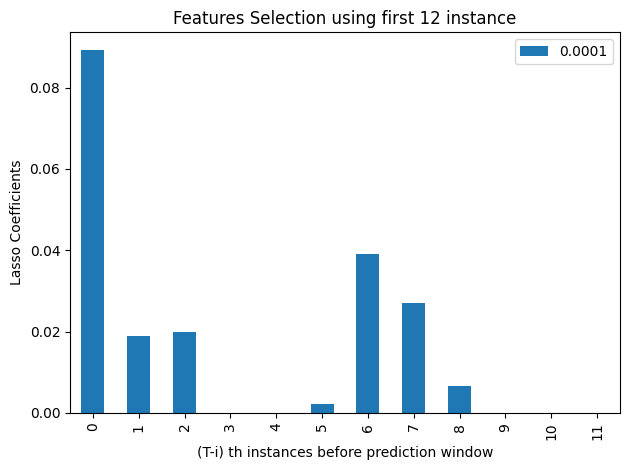

Training:  TSS:  0.52358915526409 HSS:  0.1665274717337146 TP:  834 FP:  4787 TN:  10928 FN:  173
Testing:  TSS:  0.40457010442949254 HSS:  0.14975151805040982 TP:  593 FP:  3691 TN:  12053 FN:  335


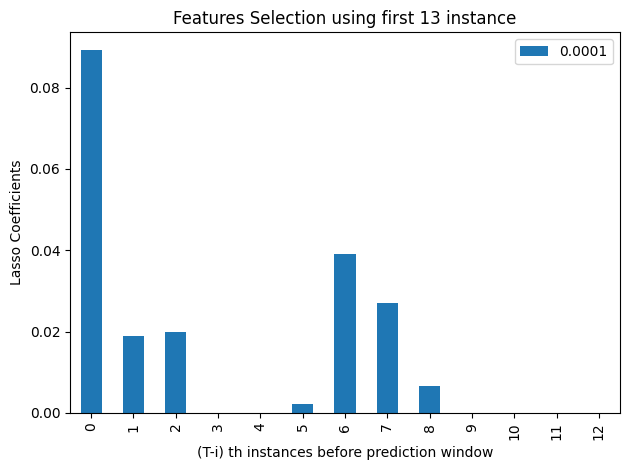

Training:  TSS:  0.52358915526409 HSS:  0.1665274717337146 TP:  834 FP:  4787 TN:  10928 FN:  173
Testing:  TSS:  0.40457010442949254 HSS:  0.14975151805040982 TP:  593 FP:  3691 TN:  12053 FN:  335


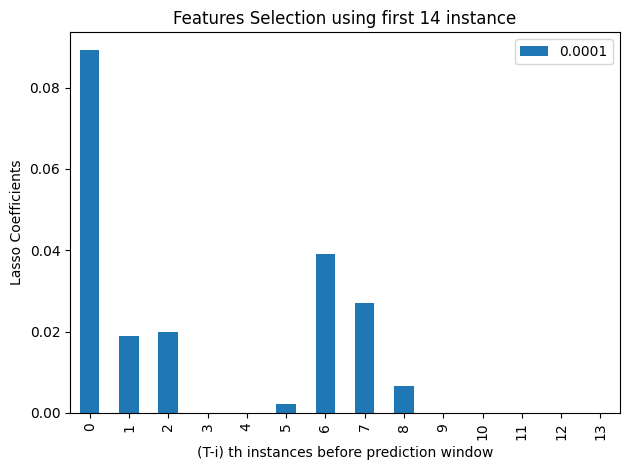

Training:  TSS:  0.5242254899761485 HSS:  0.1669766497357306 TP:  834 FP:  4777 TN:  10938 FN:  173
Testing:  TSS:  0.4031114206616204 HSS:  0.14907169860223263 TP:  592 FP:  3697 TN:  12047 FN:  336


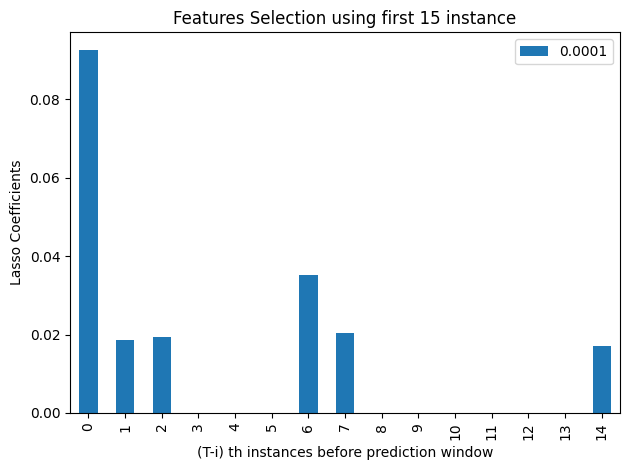

Training:  TSS:  0.5240731361538274 HSS:  0.16645997644399835 TP:  835 FP:  4795 TN:  10920 FN:  172
Testing:  TSS:  0.40330415965797595 HSS:  0.14973255509495148 TP:  591 FP:  3677 TN:  12067 FN:  337


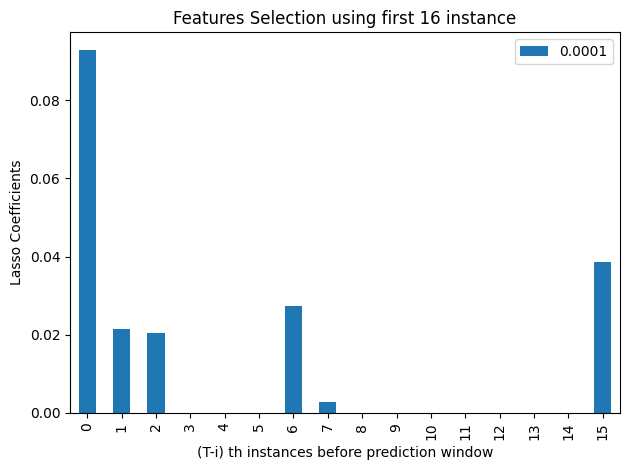

Training:  TSS:  0.5206485558772336 HSS:  0.16527465528288224 TP:  832 FP:  4802 TN:  10913 FN:  175
Testing:  TSS:  0.40736262966077935 HSS:  0.15152455740298548 TP:  594 FP:  3664 TN:  12080 FN:  334


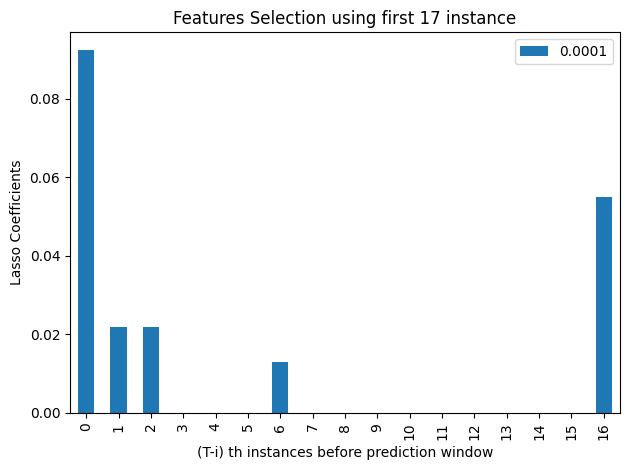

Training:  TSS:  0.5237047950379795 HSS:  0.16539090017785701 TP:  837 FP:  4832 TN:  10883 FN:  170
Testing:  TSS:  0.4129126366694701 HSS:  0.14704411885142013 TP:  612 FP:  3882 TN:  11862 FN:  316


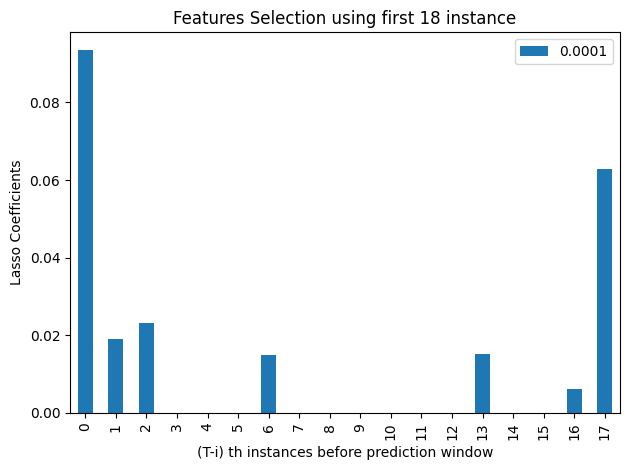

Training:  TSS:  0.5250814770674639 HSS:  0.1639489126178786 TP:  843 FP:  4904 TN:  10811 FN:  164
Testing:  TSS:  0.4112393117465657 HSS:  0.14119630559319715 TP:  622 FP:  4078 TN:  11666 FN:  306


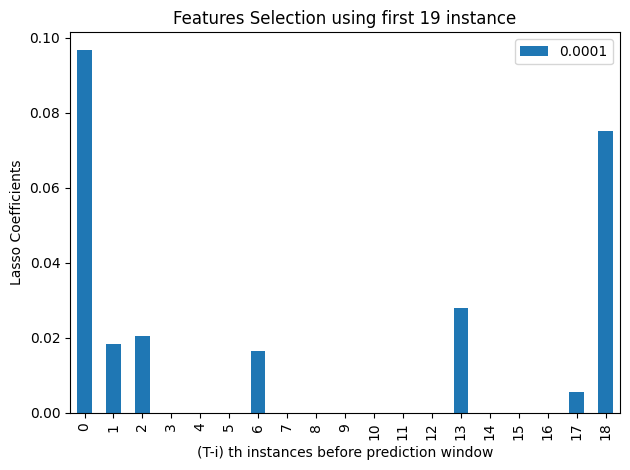

Training:  TSS:  0.5355381562280708 HSS:  0.16247531039355195 TP:  865 FP:  5083 TN:  10632 FN:  142
Testing:  TSS:  0.4172711662461452 HSS:  0.13298803557218444 TP:  652 FP:  4492 TN:  11252 FN:  276


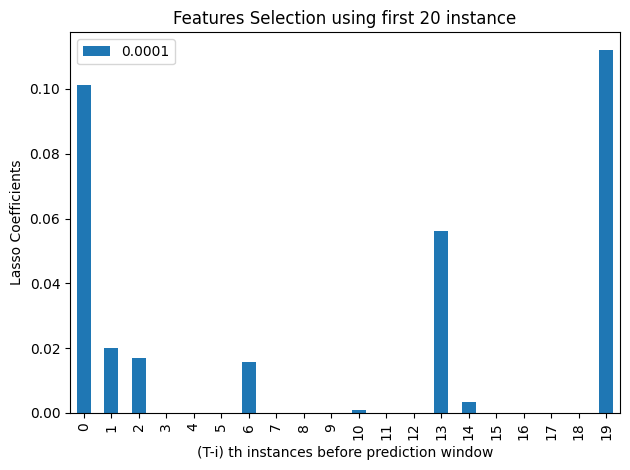

Training:  TSS:  0.5365832111901386 HSS:  0.1616528252805379 TP:  869 FP:  5129 TN:  10586 FN:  138
Testing:  TSS:  0.4208806419960751 HSS:  0.1334268838881851 TP:  657 FP:  4520 TN:  11224 FN:  271


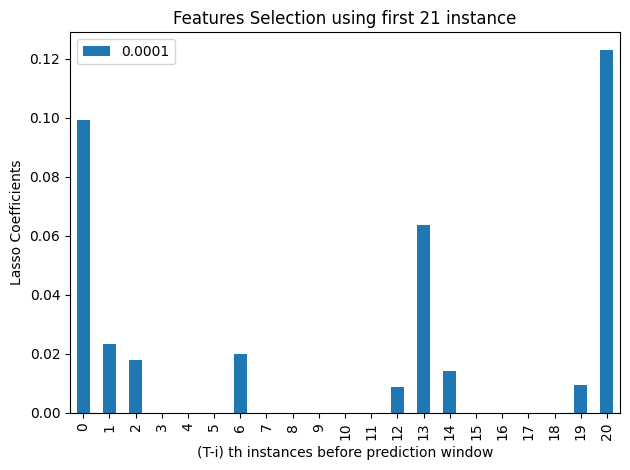

Training:  TSS:  0.5369919314401481 HSS:  0.16042836576791428 TP:  873 FP:  5185 TN:  10530 FN:  134
Testing:  TSS:  0.4087577971684889 HSS:  0.12715156618757187 TP:  653 FP:  4643 TN:  11101 FN:  275


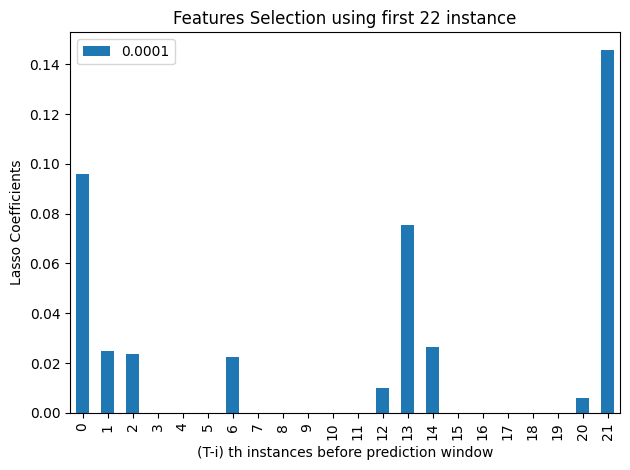

Training:  TSS:  0.5355283616024133 HSS:  0.15948186725652874 TP:  873 FP:  5208 TN:  10507 FN:  134
Testing:  TSS:  0.41604245514437904 HSS:  0.1284652843458063 TP:  662 FP:  4681 TN:  11063 FN:  266


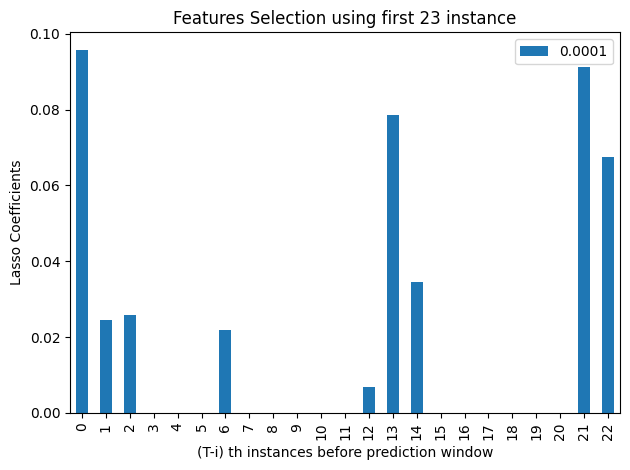

Training:  TSS:  0.5354261815399111 HSS:  0.15978312652248375 TP:  872 FP:  5194 TN:  10521 FN:  135
Testing:  TSS:  0.4136332176899355 HSS:  0.12768138169434826 TP:  660 FP:  4685 TN:  11059 FN:  268


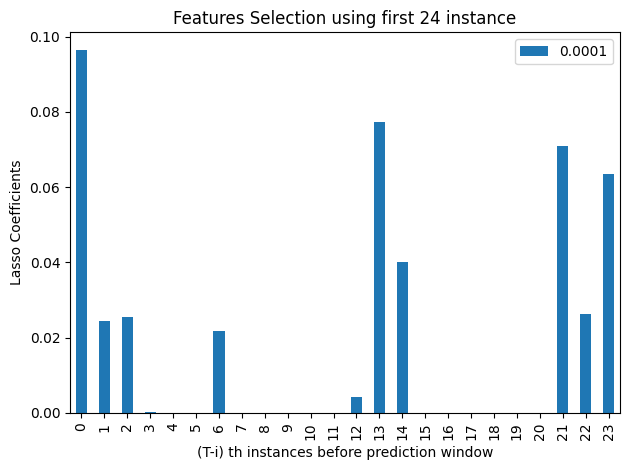

In [44]:
#Cross-Validation
gen_data(res3_6_new, res4_6_new)
gen_data(res4_6_new, res3_6_new)

Training:  TSS:  0.4050318179291946 HSS:  0.20061503882445483 TP:  1012 FP:  3951 TN:  11201 FN:  508
Testing:  TSS:  0.5276745644599303 HSS:  0.23721305138086826 TP:  1483 FP:  5003 TN:  9997 FN:  239


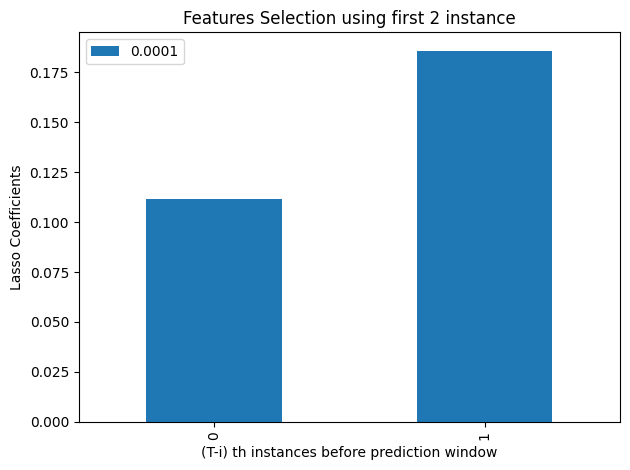

Training:  TSS:  0.40937517367865284 HSS:  0.20276633273208133 TP:  1018 FP:  3945 TN:  11207 FN:  502
Testing:  TSS:  0.5271886178861789 HSS:  0.2365299898339546 TP:  1484 FP:  5019 TN:  9981 FN:  238


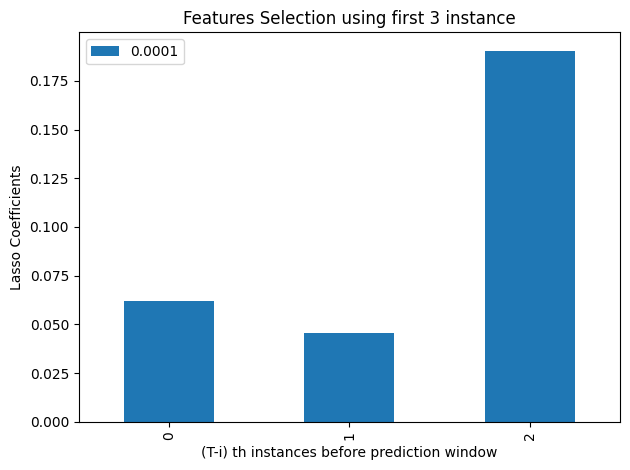

Training:  TSS:  0.41391652309231364 HSS:  0.20510589077689956 TP:  1024 FP:  3936 TN:  11216 FN:  496
Testing:  TSS:  0.5308062717770035 HSS:  0.23804329398014137 TP:  1490 FP:  5017 TN:  9983 FN:  232


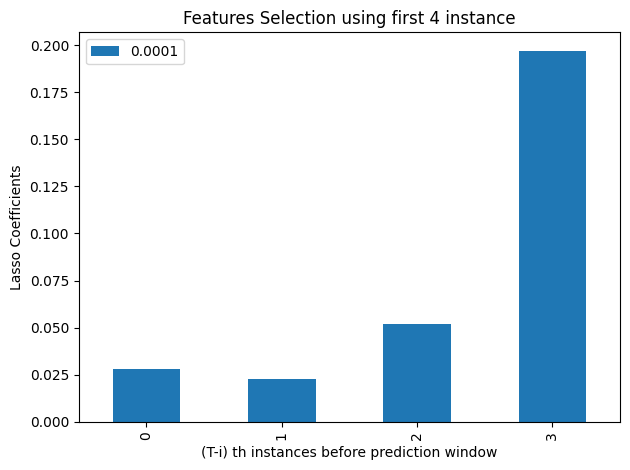

Training:  TSS:  0.4112849441449452 HSS:  0.20392149838659454 TP:  1020 FP:  3936 TN:  11216 FN:  500
Testing:  TSS:  0.5277500580720094 HSS:  0.2364819094717918 TP:  1486 FP:  5028 TN:  9972 FN:  236


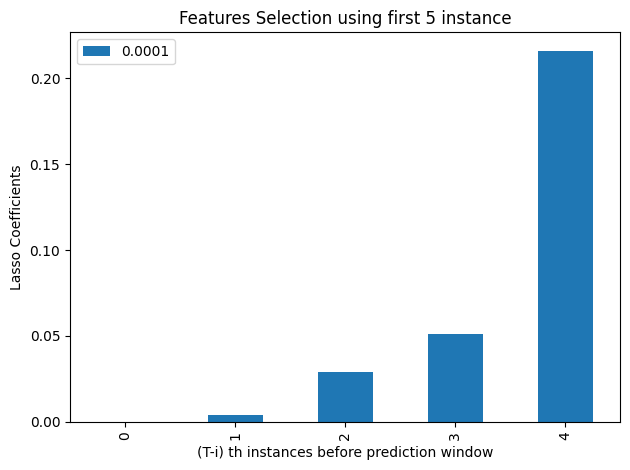

Training:  TSS:  0.41543030623020066 HSS:  0.20588620098648489 TP:  1026 FP:  3933 TN:  11219 FN:  494
Testing:  TSS:  0.5299588850174216 HSS:  0.23758112374545998 TP:  1489 FP:  5021 TN:  9979 FN:  233


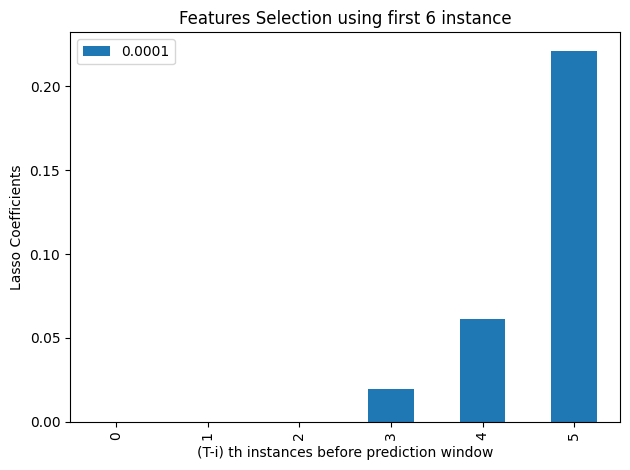

Training:  TSS:  0.4162201967431779 HSS:  0.20630792816047228 TP:  1027 FP:  3931 TN:  11221 FN:  493
Testing:  TSS:  0.5310536585365854 HSS:  0.2379896445451637 TP:  1491 FP:  5022 TN:  9978 FN:  231


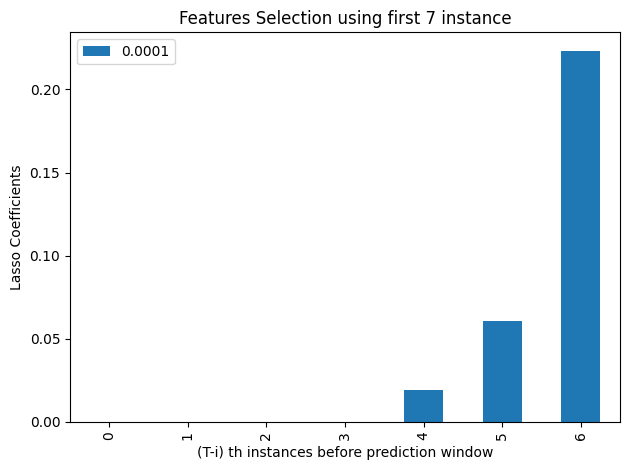

Training:  TSS:  0.41747207247262824 HSS:  0.20717157021602278 TP:  1028 FP:  3922 TN:  11230 FN:  492
Testing:  TSS:  0.5344046457607432 HSS:  0.2392708921655312 TP:  1497 FP:  5024 TN:  9976 FN:  225


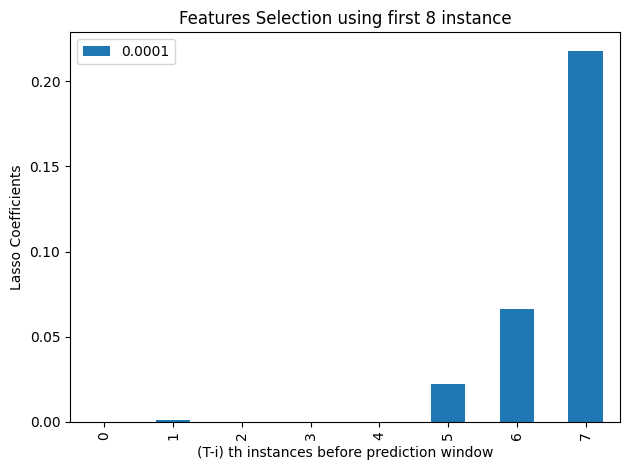

Training:  TSS:  0.4370456566442505 HSS:  0.21078644562549295 TP:  1073 FP:  4074 TN:  11078 FN:  447
Testing:  TSS:  0.5367941927990709 HSS:  0.24025782631708578 TP:  1501 FP:  5023 TN:  9977 FN:  221


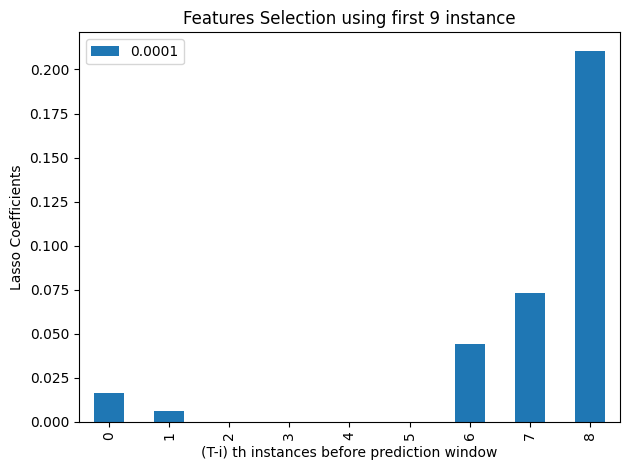

Training:  TSS:  0.4561593397432335 HSS:  0.21410674457733894 TP:  1117 FP:  4223 TN:  10929 FN:  403
Testing:  TSS:  0.538925900116144 HSS:  0.24021709115536183 TP:  1508 FP:  5052 TN:  9948 FN:  214


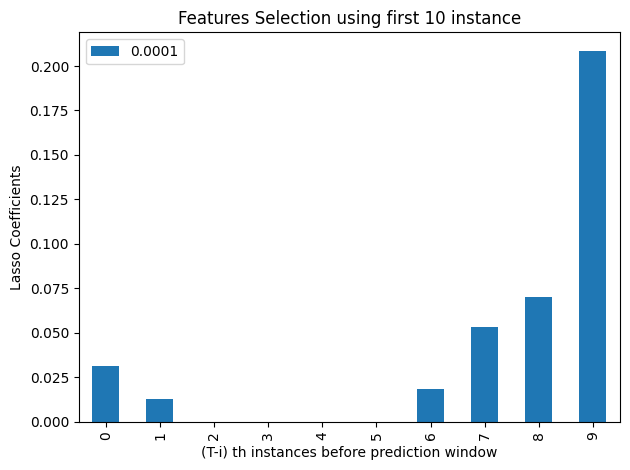

Training:  TSS:  0.45378341577280057 HSS:  0.21193175034132616 TP:  1117 FP:  4259 TN:  10893 FN:  403
Testing:  TSS:  0.5377925667828107 HSS:  0.23924596913886273 TP:  1508 FP:  5069 TN:  9931 FN:  214


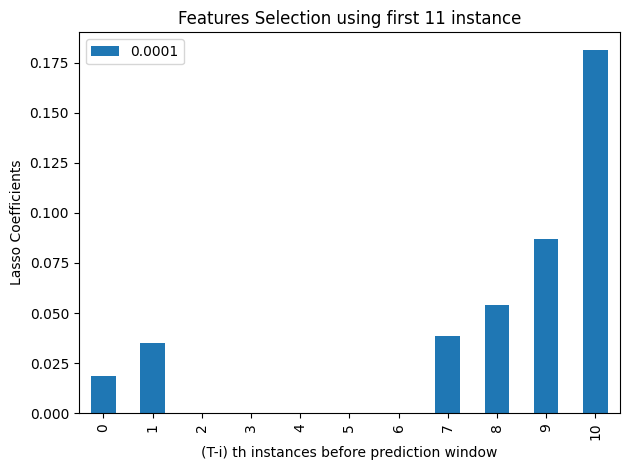

Training:  TSS:  0.44728297115544935 HSS:  0.21114297276681093 TP:  1101 FP:  4198 TN:  10954 FN:  419
Testing:  TSS:  0.5363644599303137 HSS:  0.23855609779683293 TP:  1506 FP:  5073 TN:  9927 FN:  216


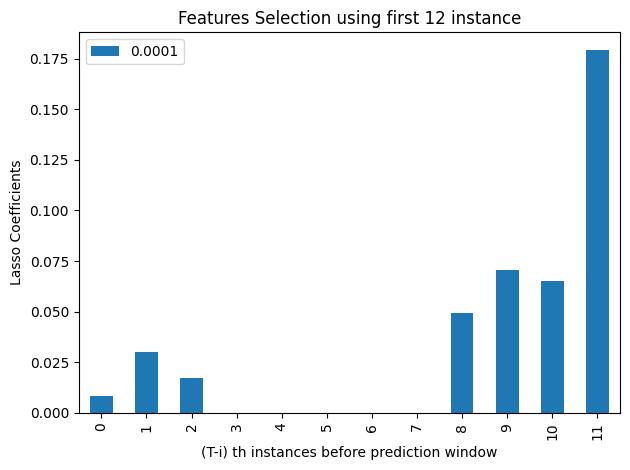

Training:  TSS:  0.4398627243928194 HSS:  0.2101355289132331 TP:  1083 FP:  4131 TN:  11021 FN:  437
Testing:  TSS:  0.5365170731707317 HSS:  0.23895176827418396 TP:  1505 FP:  5062 TN:  9938 FN:  217


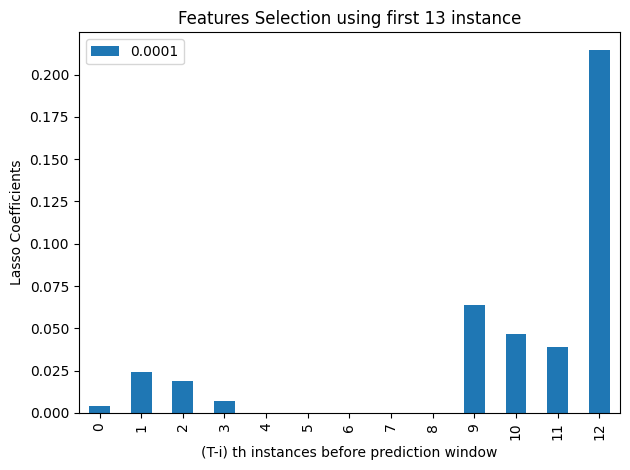

Training:  TSS:  0.4390874228866782 HSS:  0.21204358159202444 TP:  1075 FP:  4063 TN:  11089 FN:  445
Testing:  TSS:  0.5348134727061555 HSS:  0.23882181740177913 TP:  1500 FP:  5044 TN:  9956 FN:  222


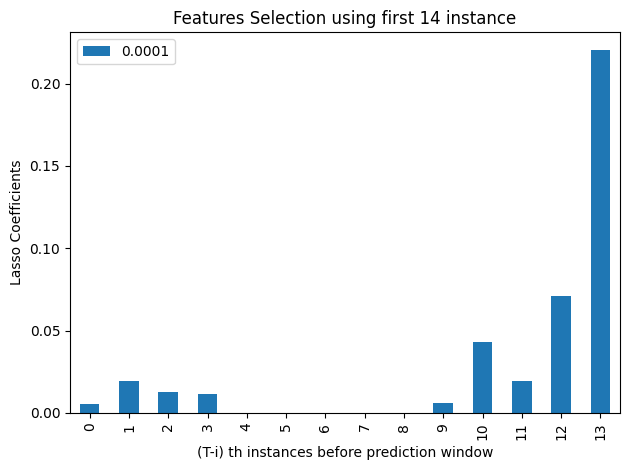

Training:  TSS:  0.43815303173456344 HSS:  0.20952612237060406 TP:  1080 FP:  4127 TN:  11025 FN:  440
Testing:  TSS:  0.5331186991869918 HSS:  0.23790118192027476 TP:  1498 FP:  5052 TN:  9948 FN:  224


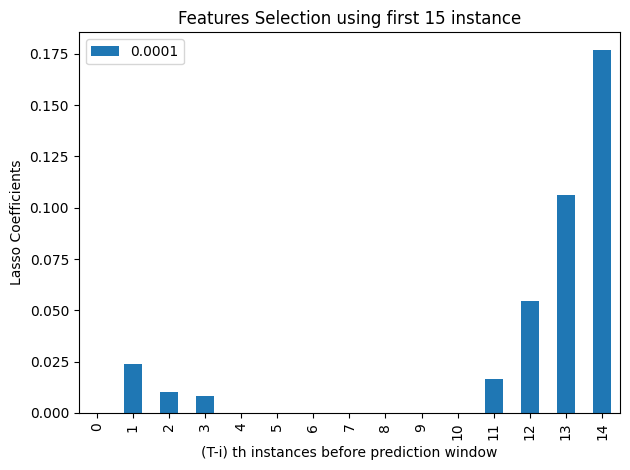

Training:  TSS:  0.4355318735063636 HSS:  0.21002637214201292 TP:  1071 FP:  4077 TN:  11075 FN:  449
Testing:  TSS:  0.528520325203252 HSS:  0.2358221357083176 TP:  1491 FP:  5060 TN:  9940 FN:  231


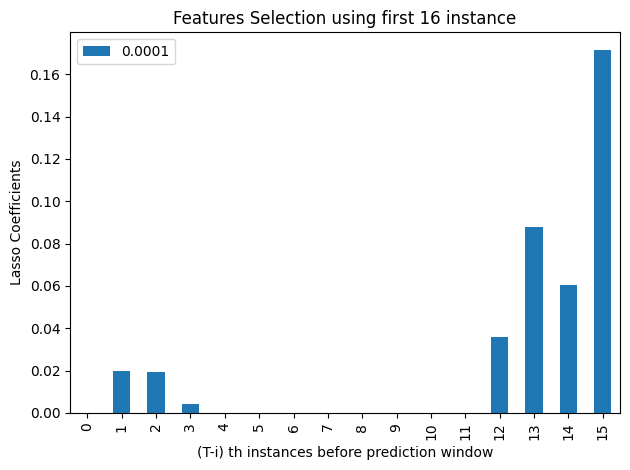

Training:  TSS:  0.43158867337297835 HSS:  0.20895985254150634 TP:  1063 FP:  4057 TN:  11095 FN:  457
Testing:  TSS:  0.5271588850174216 HSS:  0.2351876982961108 TP:  1489 FP:  5063 TN:  9937 FN:  233


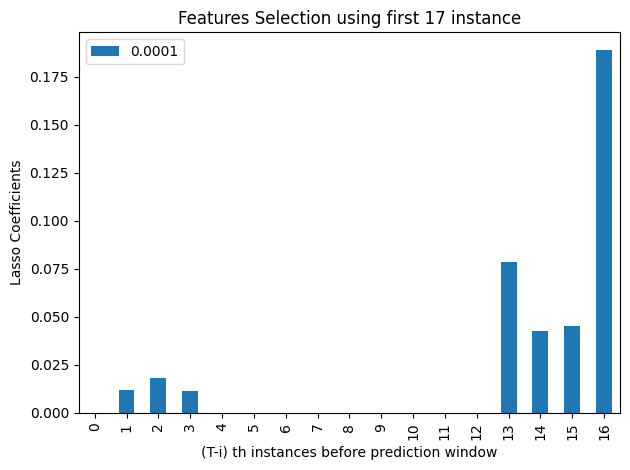

Training:  TSS:  0.4281095425999 HSS:  0.20865064649947654 TP:  1054 FP:  4020 TN:  11132 FN:  466
Testing:  TSS:  0.5279588850174216 HSS:  0.2358691784252931 TP:  1489 FP:  5051 TN:  9949 FN:  233


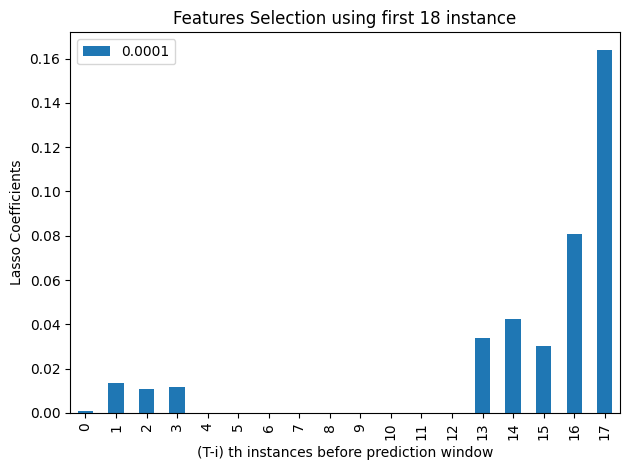

Training:  TSS:  0.43020271772355917 HSS:  0.2076639528153385 TP:  1063 FP:  4078 TN:  11074 FN:  457
Testing:  TSS:  0.5245114982578397 HSS:  0.23320433892171413 TP:  1488 FP:  5094 TN:  9906 FN:  234


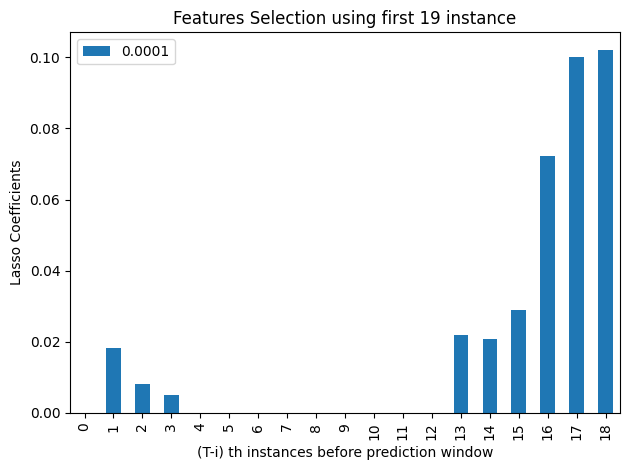

Training:  TSS:  0.4313948479964431 HSS:  0.20943619209253728 TP:  1061 FP:  4040 TN:  11112 FN:  459
Testing:  TSS:  0.5234641114982579 HSS:  0.2325791866411662 TP:  1487 FP:  5101 TN:  9899 FN:  235


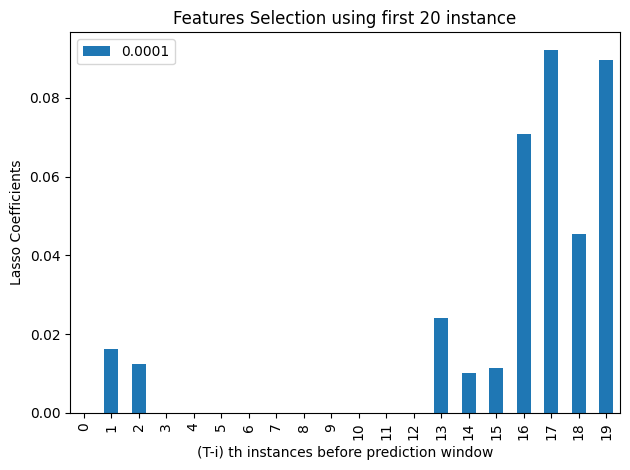

Training:  TSS:  0.42771772355916193 HSS:  0.20894188204279604 TP:  1052 FP:  4006 TN:  11146 FN:  468
Testing:  TSS:  0.5231500580720093 HSS:  0.23257244792832985 TP:  1486 FP:  5097 TN:  9903 FN:  236


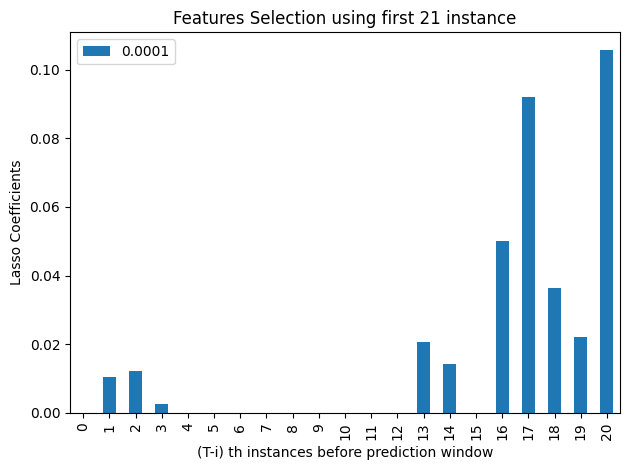

Training:  TSS:  0.4284478686155727 HSS:  0.21030188537699016 TP:  1050 FP:  3975 TN:  11177 FN:  470
Testing:  TSS:  0.5212745644599304 HSS:  0.23176515787614677 TP:  1483 FP:  5099 TN:  9901 FN:  239


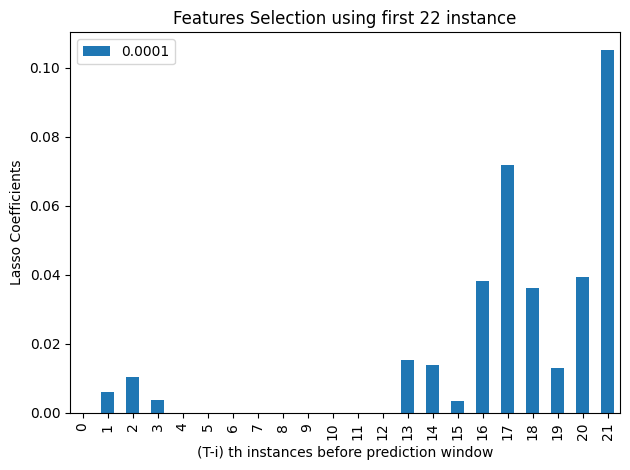

Training:  TSS:  0.4260886177958094 HSS:  0.21073570875386285 TP:  1042 FP:  3931 TN:  11221 FN:  478
Testing:  TSS:  0.5217886178861788 HSS:  0.23194070132350653 TP:  1484 FP:  5100 TN:  9900 FN:  238


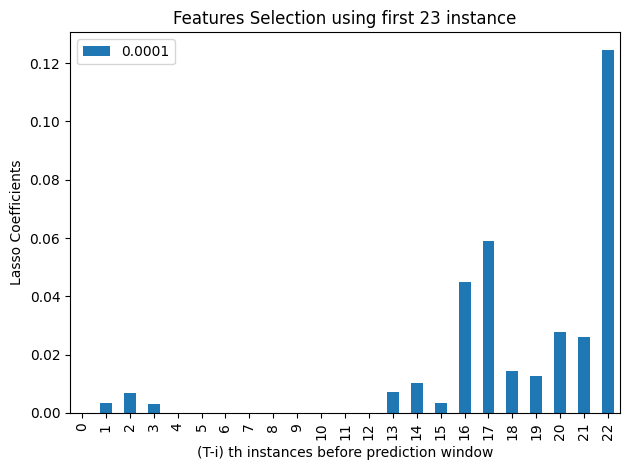

Training:  TSS:  0.4170802534318902 HSS:  0.20746463824087602 TP:  1026 FP:  3908 TN:  11244 FN:  494
Testing:  TSS:  0.5209412311265971 HSS:  0.2314846865324009 TP:  1483 FP:  5104 TN:  9896 FN:  239


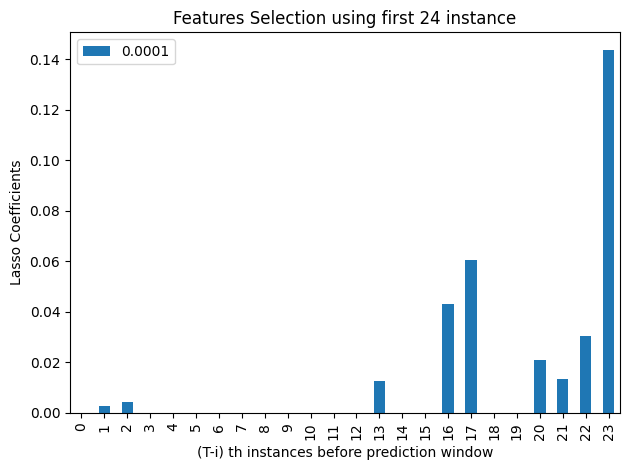

Training:  TSS:  0.5280552845528456 HSS:  0.23727453847239352 TP:  1484 FP:  5006 TN:  9994 FN:  238
Testing:  TSS:  0.40516381370532983 HSS:  0.20073926808398151 TP:  1012 FP:  3949 TN:  11203 FN:  508


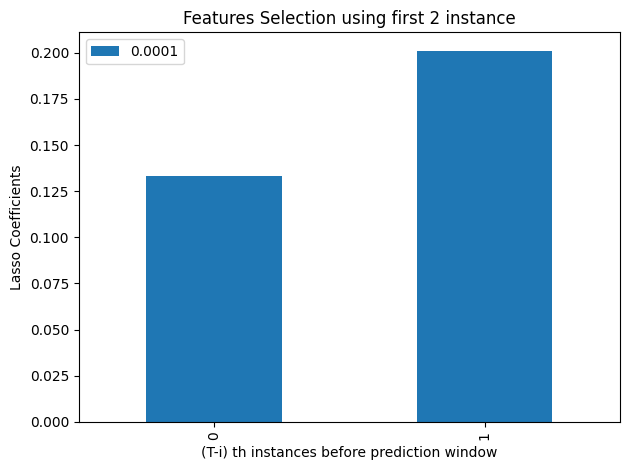

Training:  TSS:  0.5271026713124274 HSS:  0.23619181901186467 TP:  1485 FP:  5029 TN:  9971 FN:  237
Testing:  TSS:  0.4087811926860446 HSS:  0.20220536688760657 TP:  1018 FP:  3954 TN:  11198 FN:  502


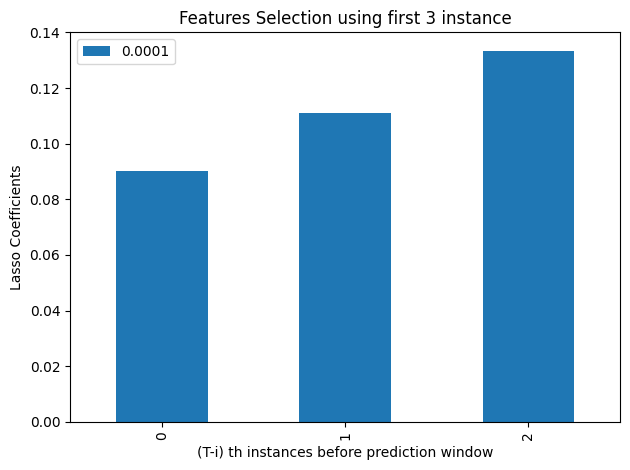

Training:  TSS:  0.5266167247386759 HSS:  0.2355129515060447 TP:  1486 FP:  5045 TN:  9955 FN:  236
Testing:  TSS:  0.4139144389484799 HSS:  0.2047745265101393 TP:  1025 FP:  3946 TN:  11206 FN:  495


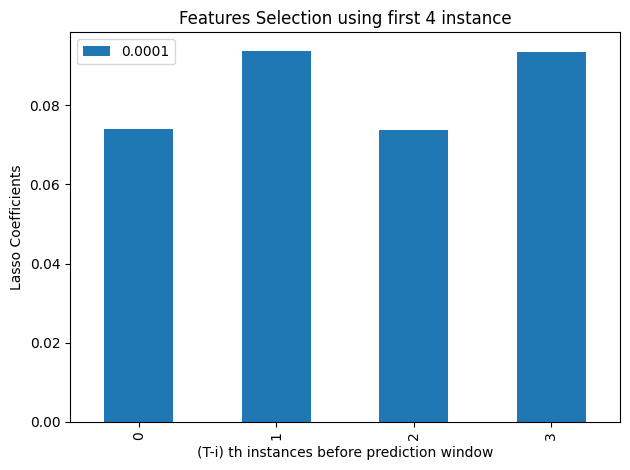

Training:  TSS:  0.5298343786295006 HSS:  0.2366798902194185 TP:  1492 FP:  5049 TN:  9951 FN:  230
Testing:  TSS:  0.4180618851775691 HSS:  0.2070689205473343 TP:  1030 FP:  3933 TN:  11219 FN:  490


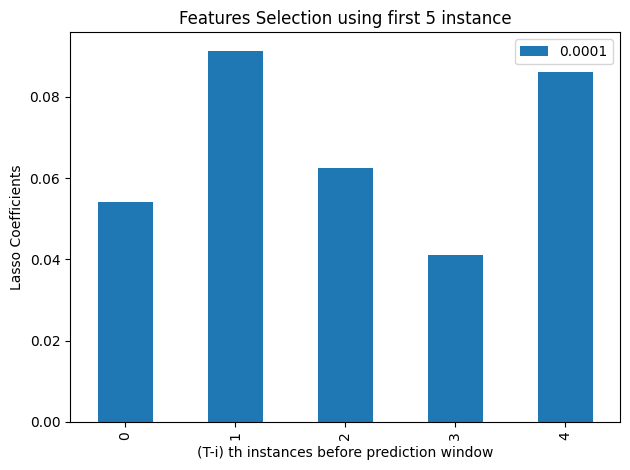

Training:  TSS:  0.5310150987224158 HSS:  0.23742540470109613 TP:  1493 FP:  5040 TN:  9960 FN:  229
Testing:  TSS:  0.4231951314400044 HSS:  0.20964218310566837 TP:  1037 FP:  3925 TN:  11227 FN:  483


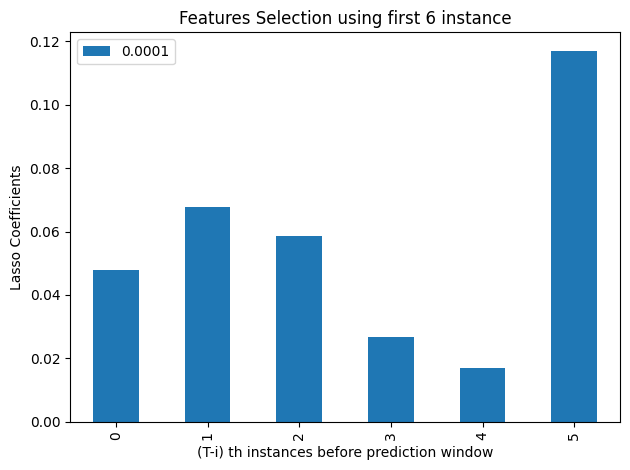

Training:  TSS:  0.5342520325203252 HSS:  0.2388726899455427 TP:  1498 FP:  5035 TN:  9965 FN:  224
Testing:  TSS:  0.4252987272828322 HSS:  0.21031425936944748 TP:  1041 FP:  3933 TN:  11219 FN:  479


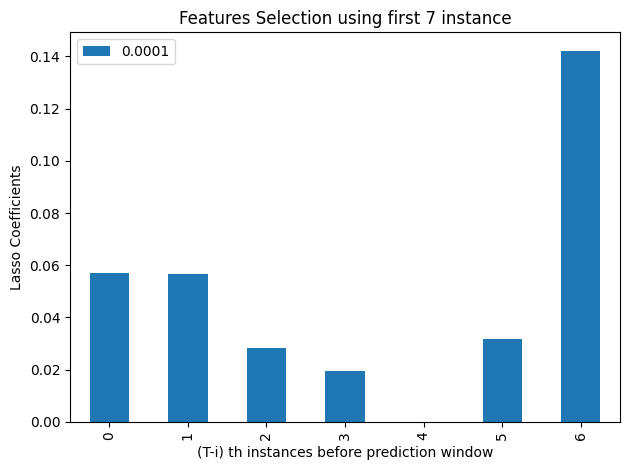

Training:  TSS:  0.537022299651568 HSS:  0.23991831979624156 TP:  1503 FP:  5037 TN:  9963 FN:  219
Testing:  TSS:  0.42490482409826047 HSS:  0.21027333728926254 TP:  1040 FP:  3929 TN:  11223 FN:  480


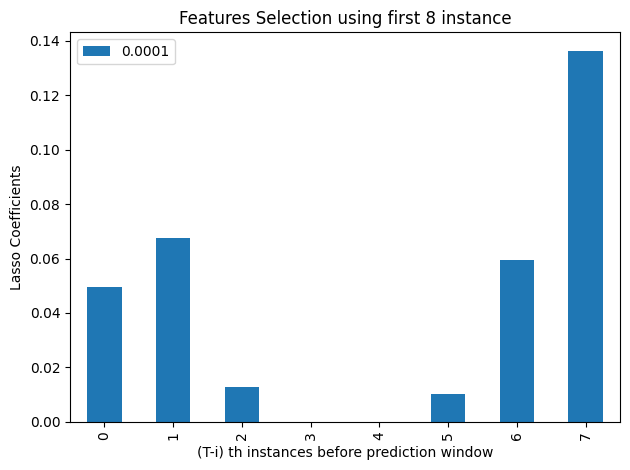

Training:  TSS:  0.5376696864111499 HSS:  0.24020754417988074 TP:  1504 FP:  5036 TN:  9964 FN:  218
Testing:  TSS:  0.42510490190629696 HSS:  0.21080458186202738 TP:  1039 FP:  3916 TN:  11236 FN:  481


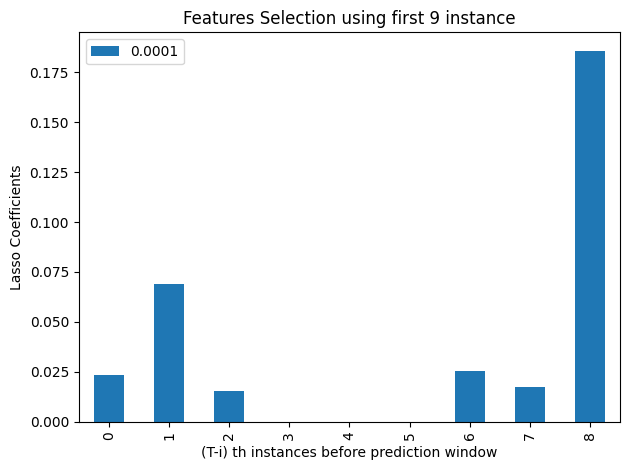

Training:  TSS:  0.5411347270615563 HSS:  0.2413122223832408 TP:  1511 FP:  5045 TN:  9955 FN:  211
Testing:  TSS:  0.42879244706274666 HSS:  0.21300831918962962 TP:  1043 FP:  3900 TN:  11252 FN:  477


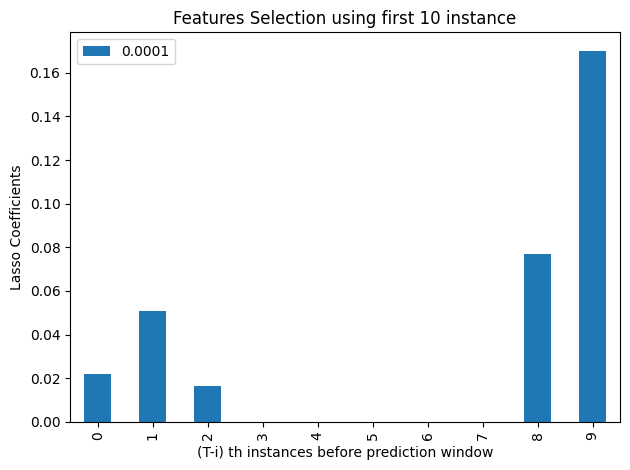

Training:  TSS:  0.5381451800232289 HSS:  0.23981414963676678 TP:  1507 FP:  5055 TN:  9945 FN:  215
Testing:  TSS:  0.4232673817595731 HSS:  0.21072837750341722 TP:  1034 FP:  3894 TN:  11258 FN:  486


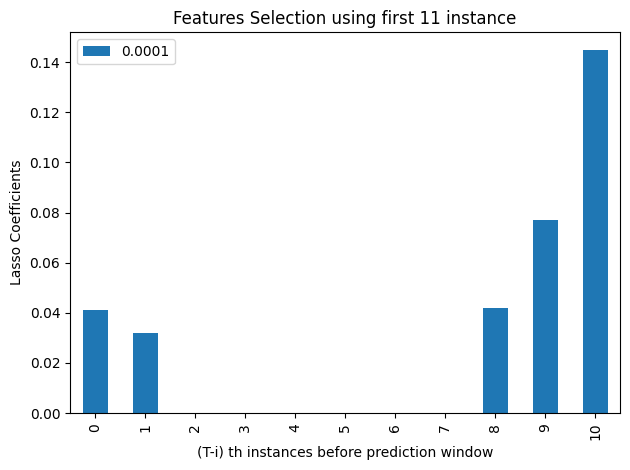

Training:  TSS:  0.5376592334494774 HSS:  0.2391319676415697 TP:  1508 FP:  5071 TN:  9929 FN:  214
Testing:  TSS:  0.4262928638915134 HSS:  0.2119535819710806 TP:  1039 FP:  3898 TN:  11254 FN:  481


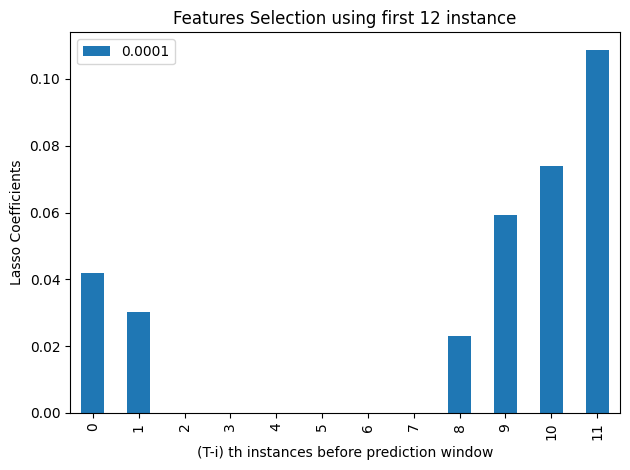

Training:  TSS:  0.5394873403019744 HSS:  0.24016468366906768 TP:  1510 FP:  5061 TN:  9939 FN:  212
Testing:  TSS:  0.42589687656310793 HSS:  0.21156990624777836 TP:  1039 FP:  3904 TN:  11248 FN:  481


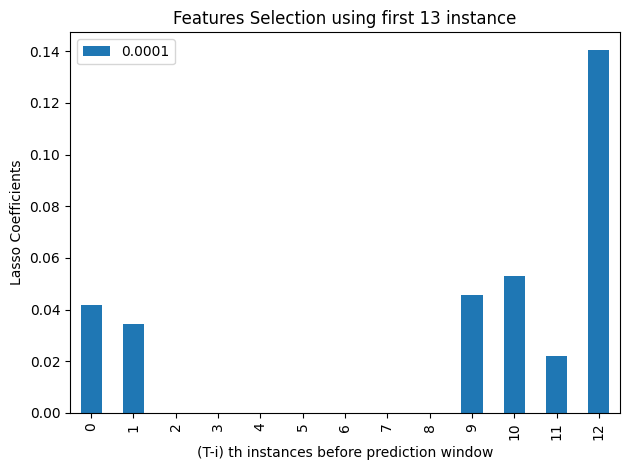

Training:  TSS:  0.5411628339140534 HSS:  0.24080035601605793 TP:  1513 FP:  5062 TN:  9938 FN:  209
Testing:  TSS:  0.4268166787083866 HSS:  0.21177775188673326 TP:  1041 FP:  3910 TN:  11242 FN:  479


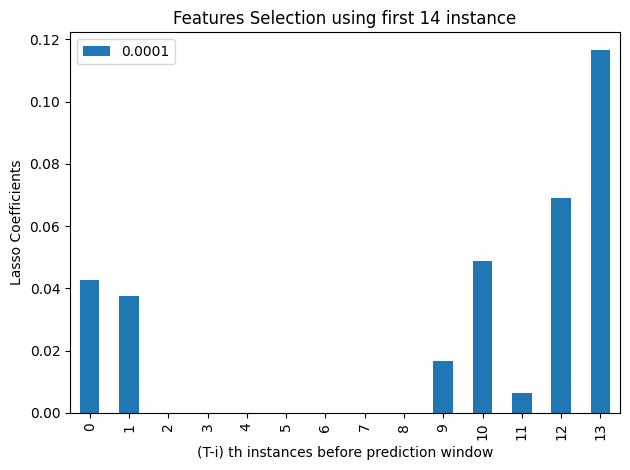

Training:  TSS:  0.5387732868757259 HSS:  0.23981936664590123 TP:  1509 FP:  5063 TN:  9937 FN:  213
Testing:  TSS:  0.4283325459901072 HSS:  0.2129050593003846 TP:  1042 FP:  3897 TN:  11255 FN:  478


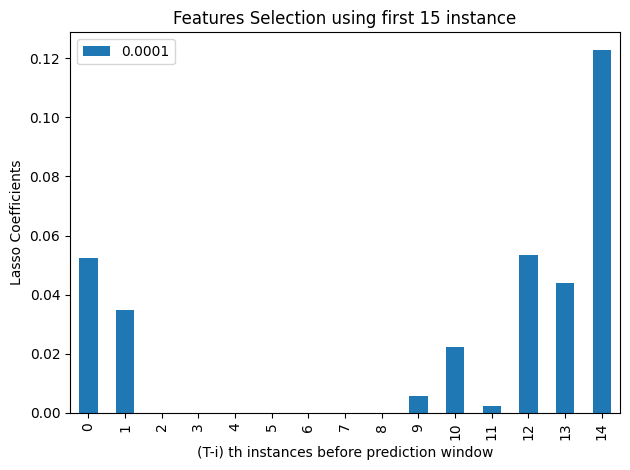

Training:  TSS:  0.5389821138211381 HSS:  0.23920079123375024 TP:  1512 FP:  5086 TN:  9914 FN:  210
Testing:  TSS:  0.43168801756238534 HSS:  0.21444673213148088 TP:  1047 FP:  3896 TN:  11256 FN:  473


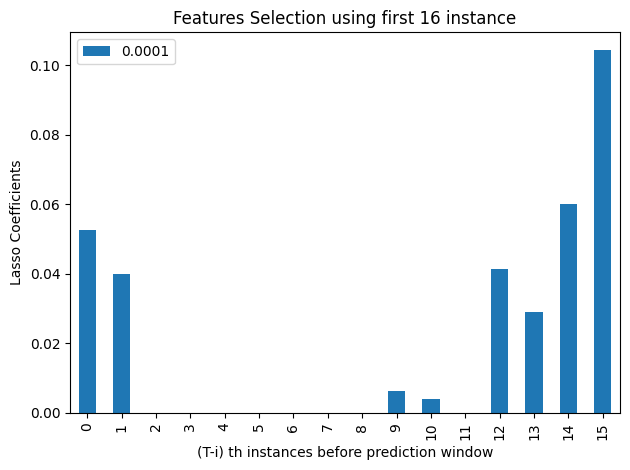

Training:  TSS:  0.5387821138211382 HSS:  0.2390302334279905 TP:  1512 FP:  5089 TN:  9911 FN:  210
Testing:  TSS:  0.43162201967431774 HSS:  0.21438242909749405 TP:  1047 FP:  3897 TN:  11255 FN:  473


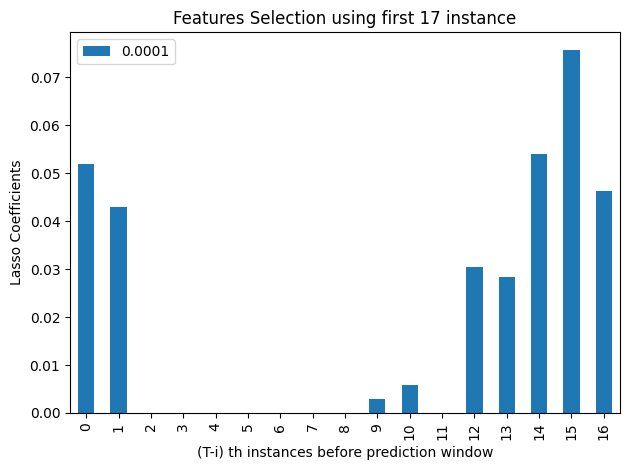

Training:  TSS:  0.5354785133565622 HSS:  0.23753750752211295 TP:  1507 FP:  5095 TN:  9905 FN:  215
Testing:  TSS:  0.4343216806535875 HSS:  0.21597730438435517 TP:  1050 FP:  3886 TN:  11266 FN:  470


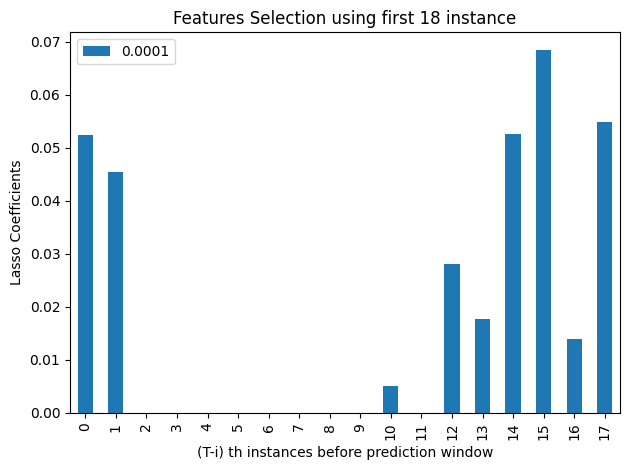

Training:  TSS:  0.5355451800232288 HSS:  0.2375941704603136 TP:  1507 FP:  5094 TN:  9906 FN:  215
Testing:  TSS:  0.43293989329183574 HSS:  0.21532186453737265 TP:  1048 FP:  3887 TN:  11265 FN:  472


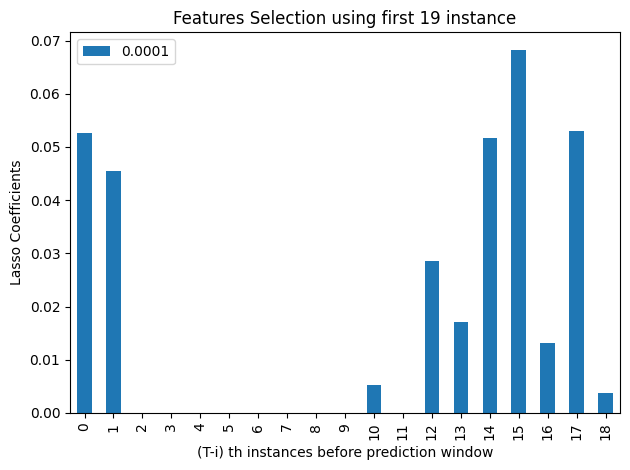

Training:  TSS:  0.534297793263647 HSS:  0.23679775061120667 TP:  1506 FP:  5104 TN:  9896 FN:  216
Testing:  TSS:  0.437415244817429 HSS:  0.21761173272209852 TP:  1054 FP:  3879 TN:  11273 FN:  466


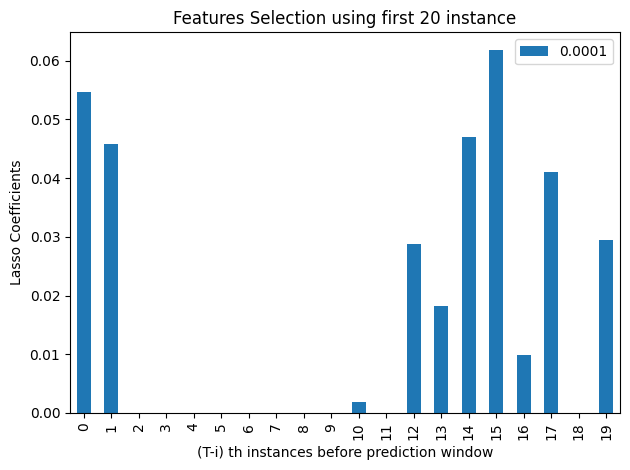

Training:  TSS:  0.5340504065040651 HSS:  0.23684999165029777 TP:  1505 FP:  5099 TN:  9901 FN:  217
Testing:  TSS:  0.43728324904129384 HSS:  0.2174820245799401 TP:  1054 FP:  3881 TN:  11271 FN:  466


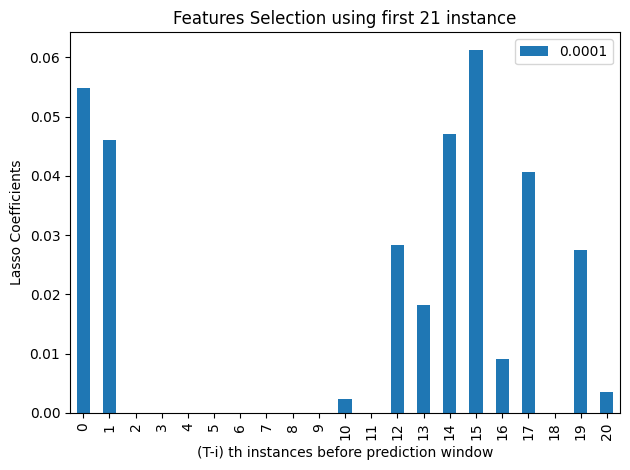

Training:  TSS:  0.5335837398373984 HSS:  0.23645435101120432 TP:  1505 FP:  5106 TN:  9894 FN:  217
Testing:  TSS:  0.4382690490746402 HSS:  0.21774795907237718 TP:  1056 FP:  3886 TN:  11266 FN:  464


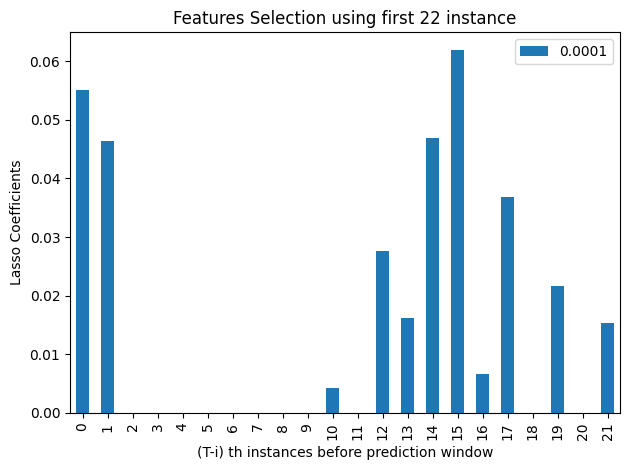

Training:  TSS:  0.5334504065040651 HSS:  0.23634142667950958 TP:  1505 FP:  5108 TN:  9892 FN:  217
Testing:  TSS:  0.43616336908797865 HSS:  0.2167336489474887 TP:  1053 FP:  3888 TN:  11264 FN:  467


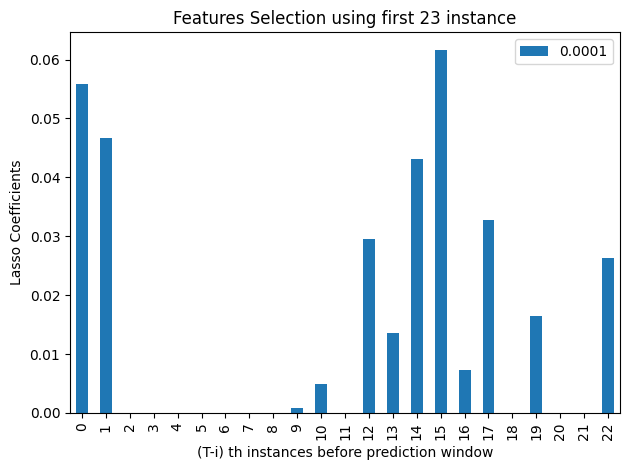

Training:  TSS:  0.5334504065040651 HSS:  0.23634142667950958 TP:  1505 FP:  5108 TN:  9892 FN:  217
Testing:  TSS:  0.43616336908797865 HSS:  0.2167336489474887 TP:  1053 FP:  3888 TN:  11264 FN:  467


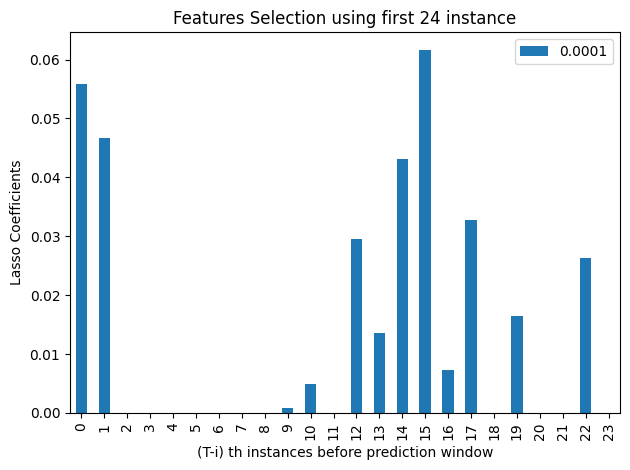

In [45]:
gen_data(res3_12_new, res4_12_new)
gen_data(res4_12_new, res3_12_new)

Training:  TSS:  0.3085658720867105 HSS:  0.2799133153199964 TP:  834 FP:  1626 TN:  13057 FN:  1155
Testing:  TSS:  0.4393344179792437 HSS:  0.3494383949460852 TP:  1345 FP:  2281 TN:  12188 FN:  908


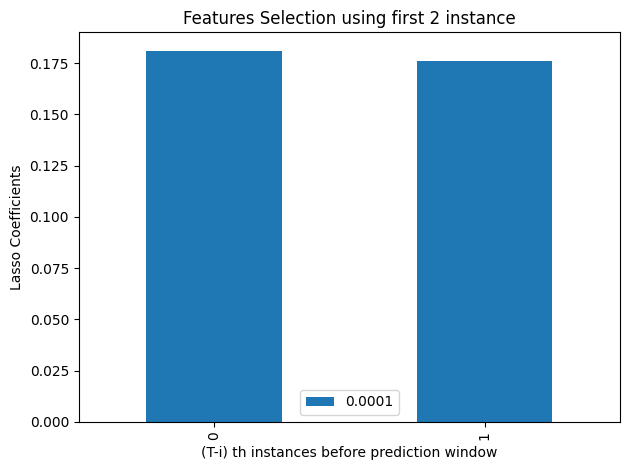

Training:  TSS:  0.3127563240539031 HSS:  0.28528950086781046 TP:  838 FP:  1594 TN:  13089 FN:  1151
Testing:  TSS:  0.43893050563402036 HSS:  0.3495860209422587 TP:  1343 FP:  2274 TN:  12195 FN:  910


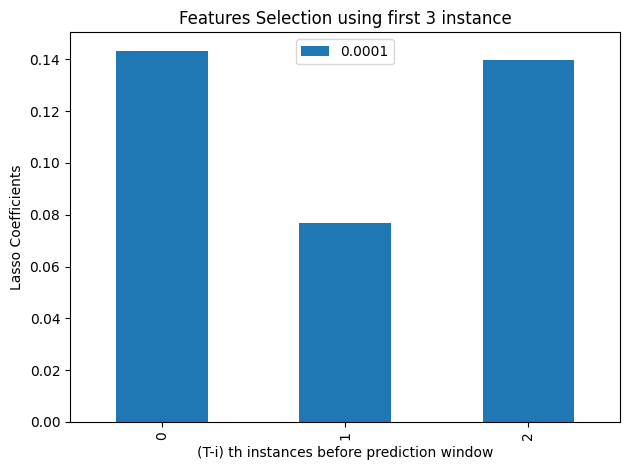

Training:  TSS:  0.31293461857419375 HSS:  0.2860759764694547 TP:  837 FP:  1584 TN:  13099 FN:  1152
Testing:  TSS:  0.4363656760461021 HSS:  0.3475432634703437 TP:  1338 FP:  2279 TN:  12190 FN:  915


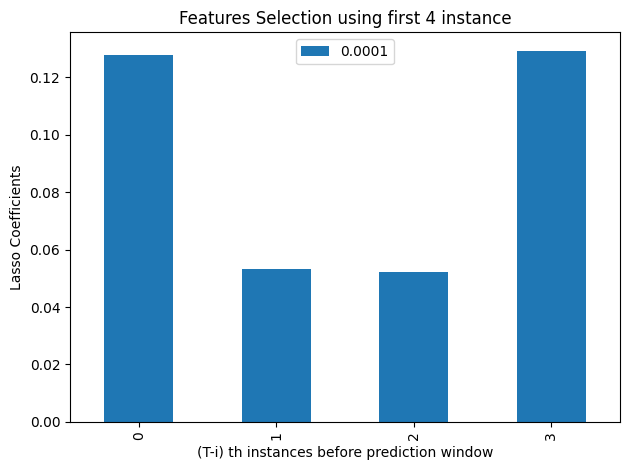

Training:  TSS:  0.31163064086693254 HSS:  0.2852239208288976 TP:  834 FP:  1581 TN:  13102 FN:  1155
Testing:  TSS:  0.438141086609795 HSS:  0.34874911245802376 TP:  1342 FP:  2279 TN:  12190 FN:  911


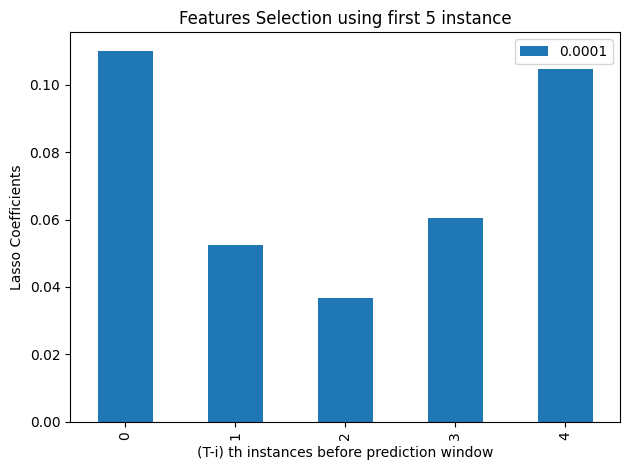

Training:  TSS:  0.3174235178313524 HSS:  0.29156987579725185 TP:  842 FP:  1555 TN:  13128 FN:  1147
Testing:  TSS:  0.4385158259740577 HSS:  0.34894331157488545 TP:  1343 FP:  2280 TN:  12189 FN:  910


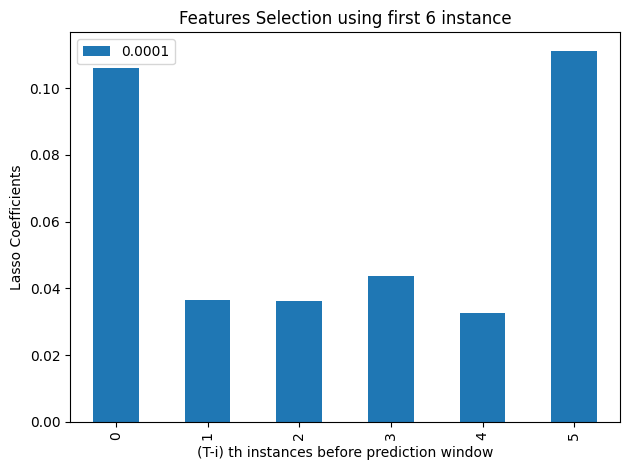

Training:  TSS:  0.31600935157669435 HSS:  0.29003929074703394 TP:  840 FP:  1561 TN:  13122 FN:  1149
Testing:  TSS:  0.43762812069221135 HSS:  0.3483408046915397 TP:  1341 FP:  2280 TN:  12189 FN:  912


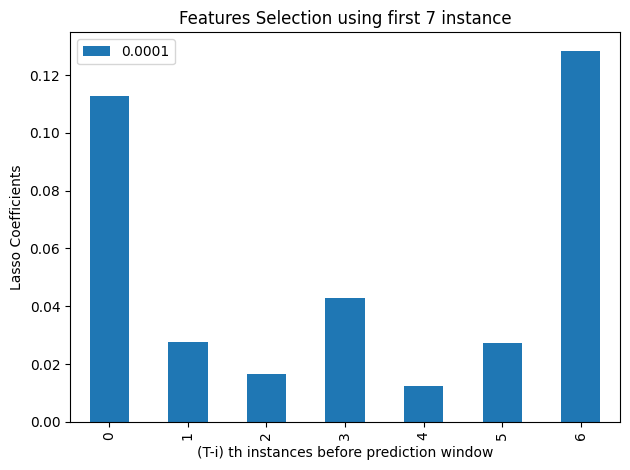

Training:  TSS:  0.31842904824864754 HSS:  0.29237677390373373 TP:  844 FP:  1555 TN:  13128 FN:  1145
Testing:  TSS:  0.4367404154103649 HSS:  0.3477379382658742 TP:  1339 FP:  2280 TN:  12189 FN:  914


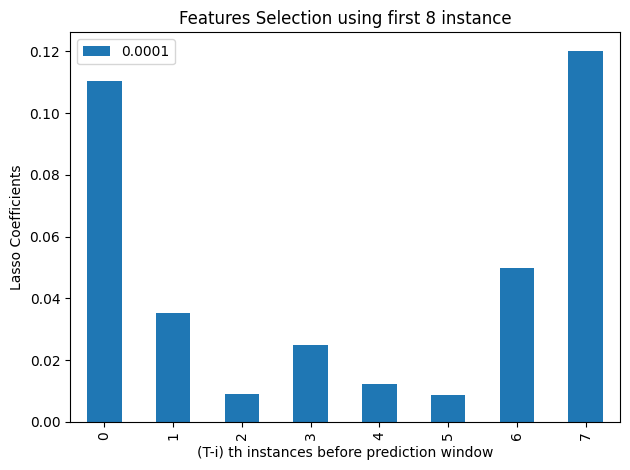

Training:  TSS:  0.3174235178313524 HSS:  0.29156987579725185 TP:  842 FP:  1555 TN:  13128 FN:  1147
Testing:  TSS:  0.43276414730827706 HSS:  0.3439050106030754 TP:  1333 FP:  2299 TN:  12170 FN:  920


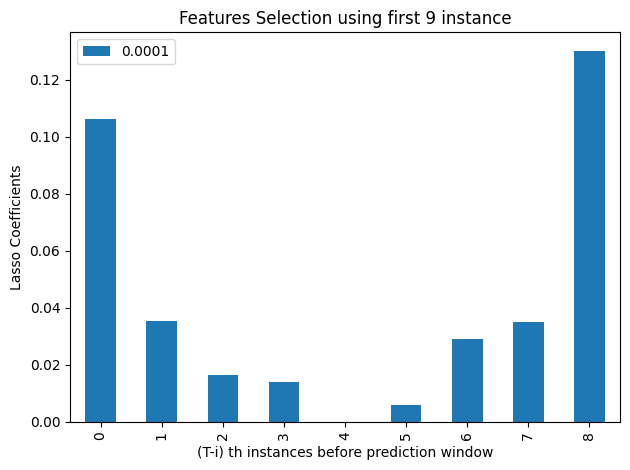

Training:  TSS:  0.31911010797758577 HSS:  0.29358796396857073 TP:  844 FP:  1545 TN:  13138 FN:  1145
Testing:  TSS:  0.4355654897071374 HSS:  0.3459251263356319 TP:  1339 FP:  2297 TN:  12172 FN:  914


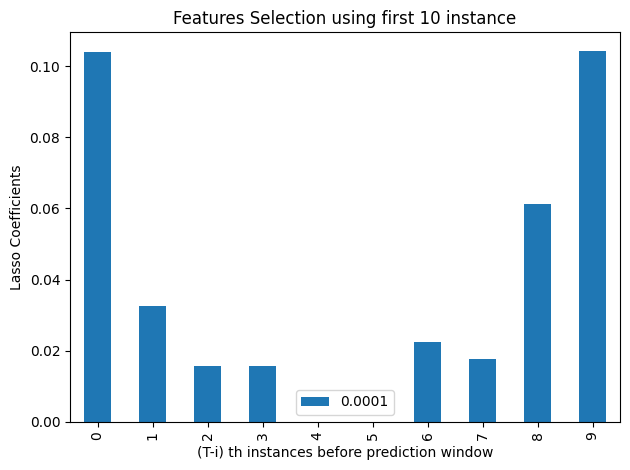

Training:  TSS:  0.3124379483193798 HSS:  0.28808305499839454 TP:  831 FP:  1547 TN:  13136 FN:  1158
Testing:  TSS:  0.43207301454167263 HSS:  0.3428453005329328 TP:  1333 FP:  2309 TN:  12160 FN:  920


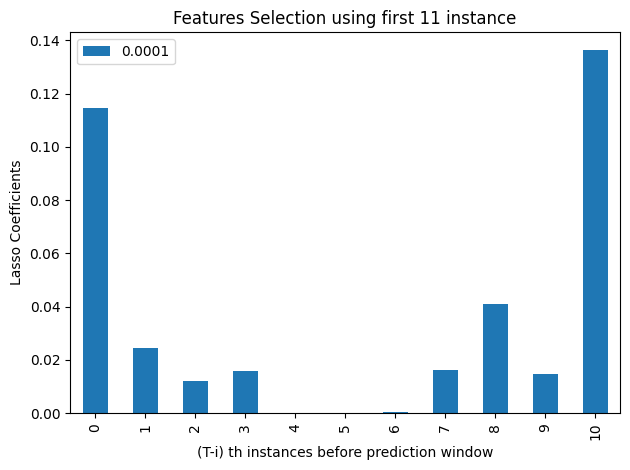

Training:  TSS:  0.3129407135280274 HSS:  0.28848881923781317 TP:  832 FP:  1547 TN:  13136 FN:  1157
Testing:  TSS:  0.4296971191175145 HSS:  0.34223209404336463 TP:  1325 FP:  2292 TN:  12177 FN:  928


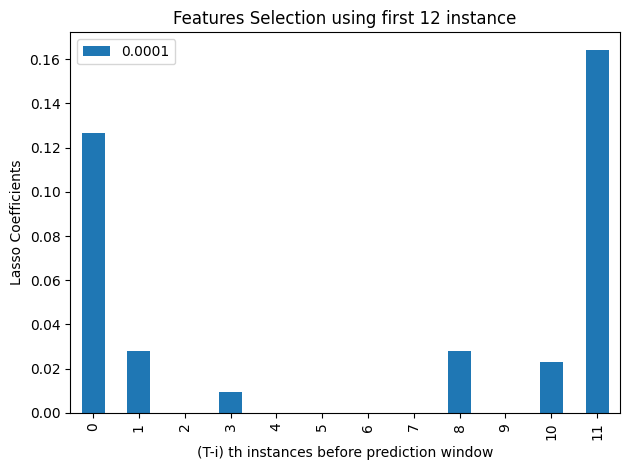

Training:  TSS:  0.31458522109975773 HSS:  0.289946741423165 TP:  835 FP:  1545 TN:  13138 FN:  1154
Testing:  TSS:  0.4241635475964547 HSS:  0.3382792174883829 TP:  1313 FP:  2295 TN:  12174 FN:  940


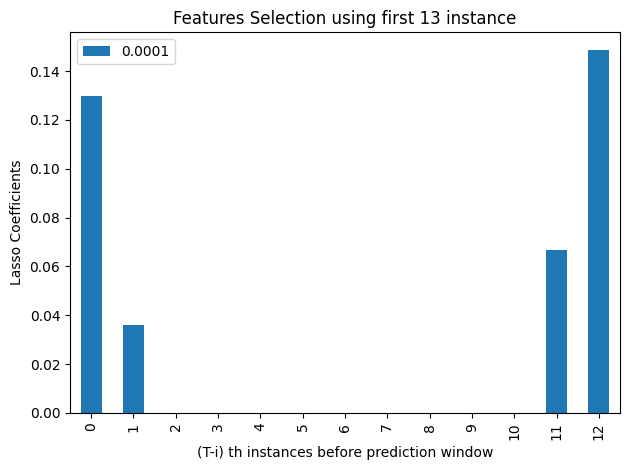

Training:  TSS:  0.310997758666331 HSS:  0.2869851639034555 TP:  828 FP:  1546 TN:  13137 FN:  1161
Testing:  TSS:  0.42577155862586613 HSS:  0.33961238828880325 TP:  1316 FP:  2291 TN:  12178 FN:  937


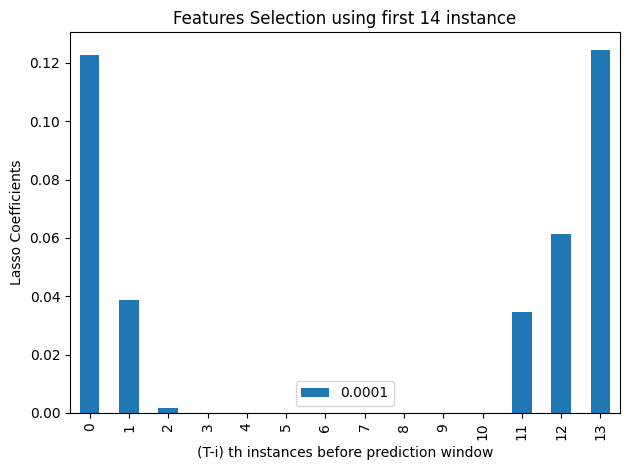

Training:  TSS:  0.3129407135280274 HSS:  0.28848881923781317 TP:  832 FP:  1547 TN:  13136 FN:  1157
Testing:  TSS:  0.42685583642295444 HSS:  0.3397663415953758 TP:  1320 FP:  2301 TN:  12168 FN:  933


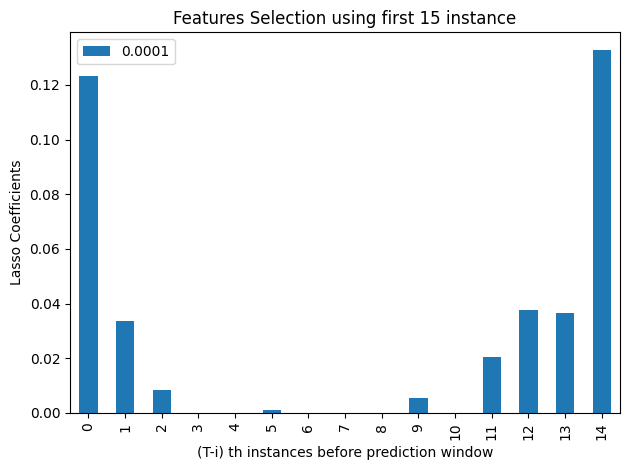

Training:  TSS:  0.3076827201244795 HSS:  0.28449664032599165 TP:  821 FP:  1543 TN:  13140 FN:  1168
Testing:  TSS:  0.42645192407773125 HSS:  0.3399010778365634 TP:  1318 FP:  2294 TN:  12175 FN:  935


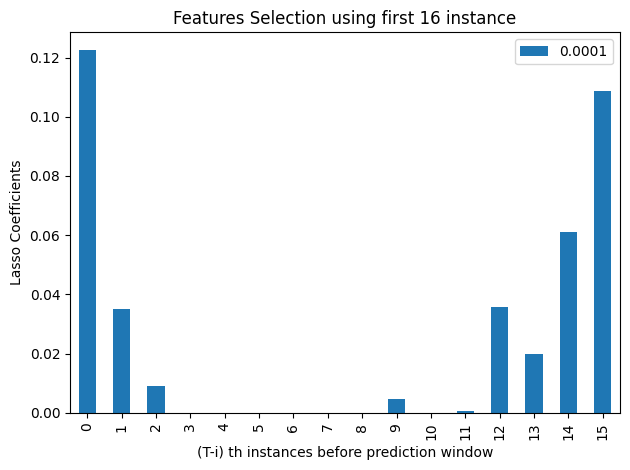

Training:  TSS:  0.30818548533312706 HSS:  0.28490426643901506 TP:  822 FP:  1543 TN:  13140 FN:  1167
Testing:  TSS:  0.4242218935583757 HSS:  0.3376194372975199 TP:  1315 FP:  2307 TN:  12162 FN:  938


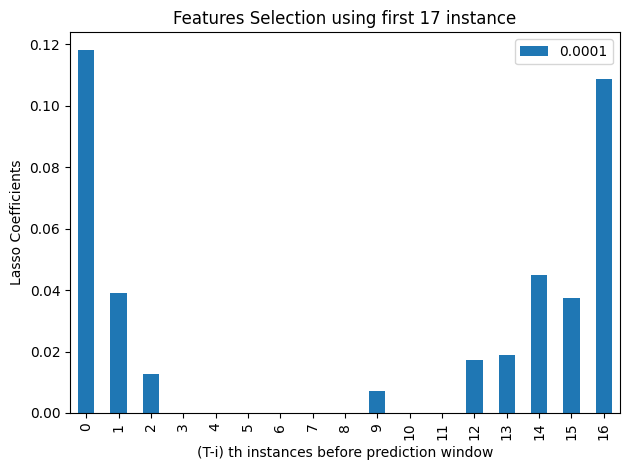

Training:  TSS:  0.3113222293546879 HSS:  0.2865948650127098 TP:  830 FP:  1556 TN:  13127 FN:  1159
Testing:  TSS:  0.42432017981599673 HSS:  0.3373957857614371 TP:  1316 FP:  2312 TN:  12157 FN:  937


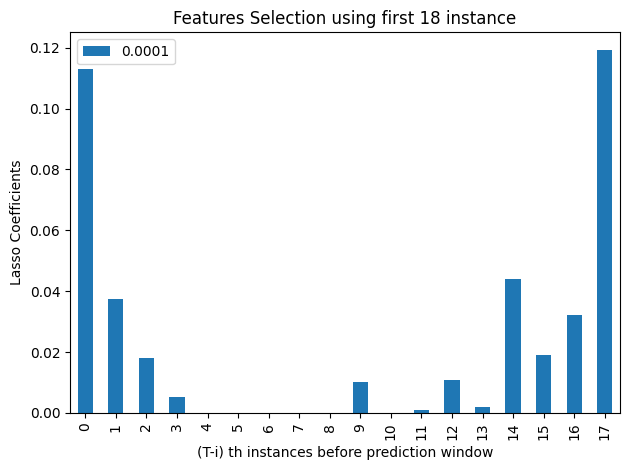

Training:  TSS:  0.30839976747408715 HSS:  0.2838477364731255 TP:  825 FP:  1562 TN:  13121 FN:  1164
Testing:  TSS:  0.4257684296626085 HSS:  0.3369909391437802 TP:  1323 FP:  2336 TN:  12133 FN:  930


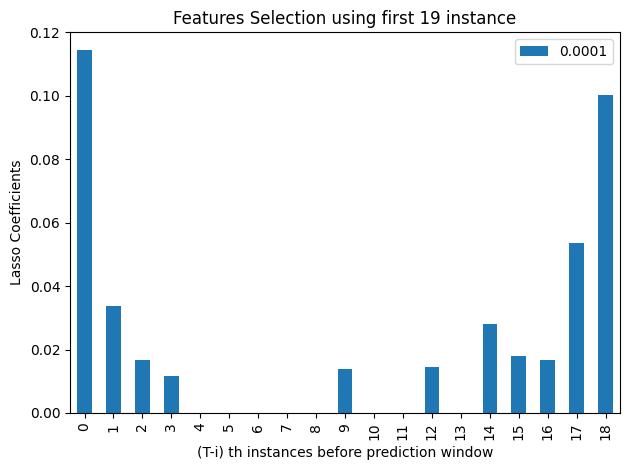

Training:  TSS:  0.3080752967857302 HSS:  0.28423134721526644 TP:  823 FP:  1552 TN:  13131 FN:  1166
Testing:  TSS:  0.4224173100137224 HSS:  0.3367356004174863 TP:  1310 FP:  2301 TN:  12168 FN:  943


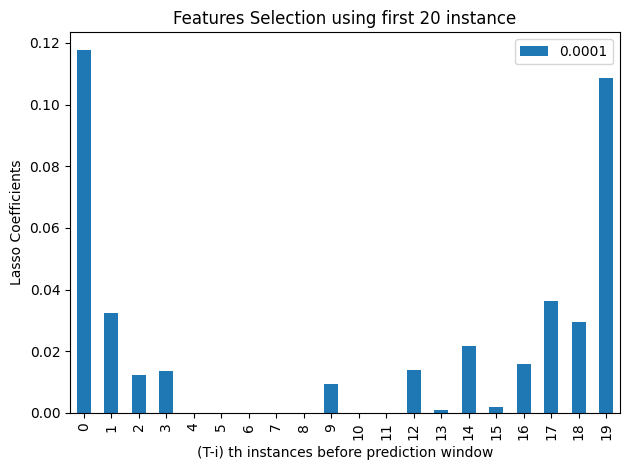

Training:  TSS:  0.3039069989484835 HSS:  0.2821393776373535 TP:  812 FP:  1532 TN:  13151 FN:  1177
Testing:  TSS:  0.42280281669272446 HSS:  0.33769863353228263 TP:  1309 FP:  2289 TN:  12180 FN:  944


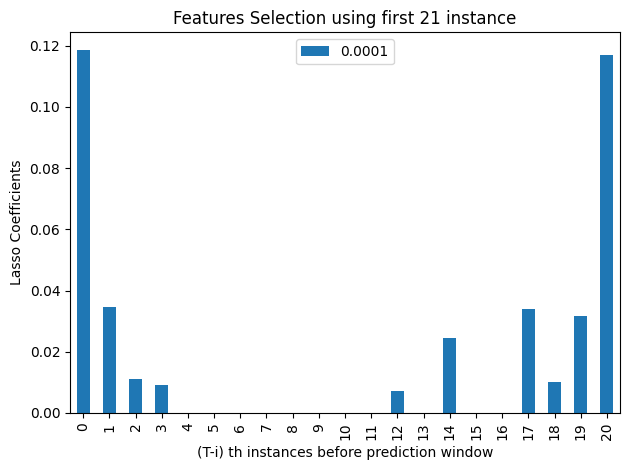

Training:  TSS:  0.3023987033225408 HSS:  0.2809091464574269 TP:  809 FP:  1532 TN:  13151 FN:  1180
Testing:  TSS:  0.421915111410878 HSS:  0.33709050512379374 TP:  1307 FP:  2289 TN:  12180 FN:  946


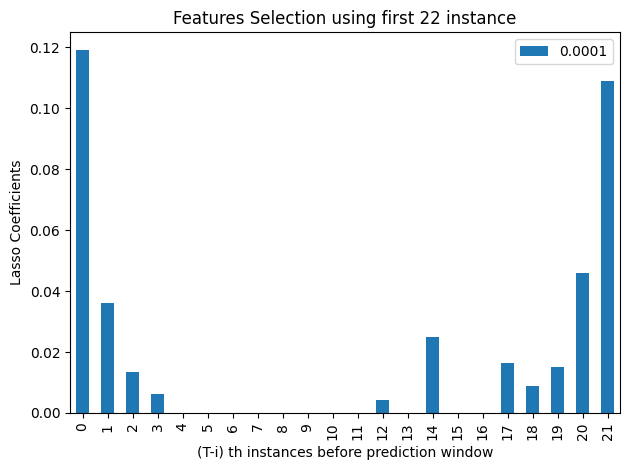

Training:  TSS:  0.30287544513279757 HSS:  0.2817501779468706 TP:  809 FP:  1525 TN:  13158 FN:  1180
Testing:  TSS:  0.42251559627134333 HSS:  0.3365123731220026 TP:  1311 FP:  2306 TN:  12163 FN:  942


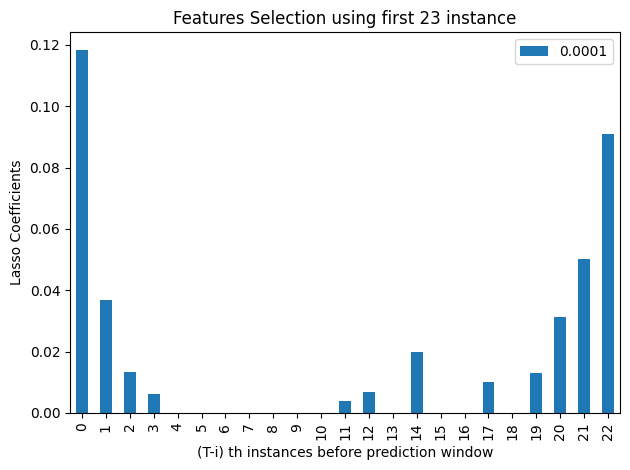

Training:  TSS:  0.3057298010405045 HSS:  0.2844054453112075 TP:  814 FP:  1520 TN:  13163 FN:  1175
Testing:  TSS:  0.42223914316470157 HSS:  0.3360915716970198 TP:  1311 FP:  2310 TN:  12159 FN:  942


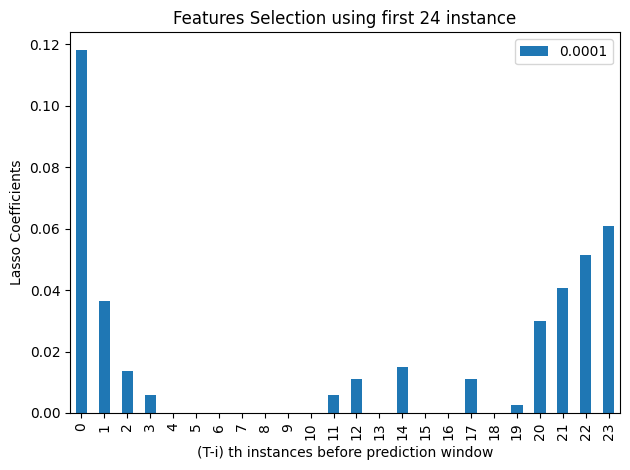

Training:  TSS:  0.4392361317216228 HSS:  0.34967289112637734 TP:  1344 FP:  2276 TN:  12193 FN:  909
Testing:  TSS:  0.3090426138969673 HSS:  0.280733212139102 TP:  834 FP:  1619 TN:  13064 FN:  1155


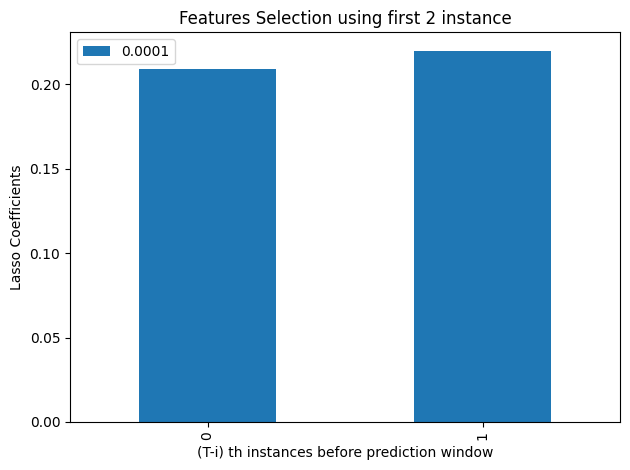

Training:  TSS:  0.4393052449982833 HSS:  0.34978008623623774 TP:  1344 FP:  2275 TN:  12194 FN:  909
Testing:  TSS:  0.31513393815135327 HSS:  0.28705995454800226 TP:  843 FP:  1596 TN:  13087 FN:  1146


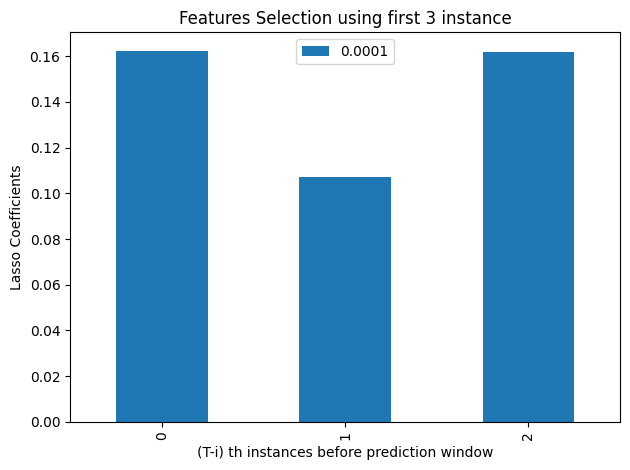

Training:  TSS:  0.4384175397164368 HSS:  0.3491774694478757 TP:  1342 FP:  2275 TN:  12194 FN:  911
Testing:  TSS:  0.31430670225434876 HSS:  0.2870451508008943 TP:  840 FP:  1586 TN:  13097 FN:  1149


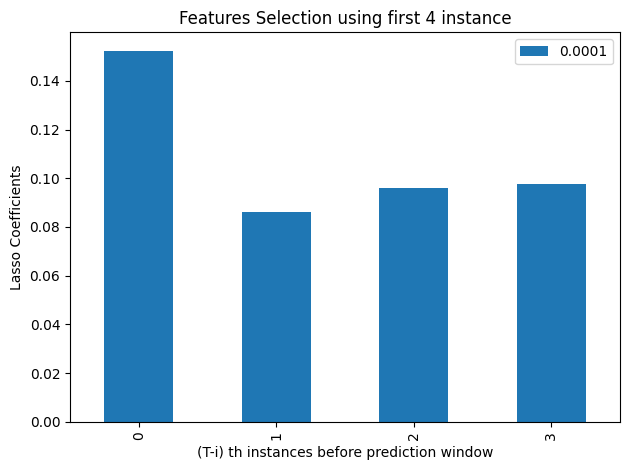

Training:  TSS:  0.4387922790806995 HSS:  0.349371656642165 TP:  1343 FP:  2276 TN:  12193 FN:  910
Testing:  TSS:  0.31347946635734436 HSS:  0.2870302704619428 TP:  837 FP:  1576 TN:  13107 FN:  1152


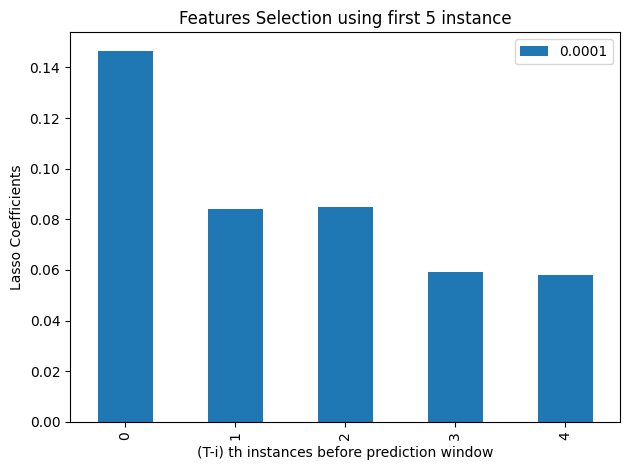

Training:  TSS:  0.43886139235736 HSS:  0.3494788227997519 TP:  1343 FP:  2275 TN:  12194 FN:  910
Testing:  TSS:  0.31468931469332095 HSS:  0.28819538911962483 TP:  839 FP:  1573 TN:  13110 FN:  1150


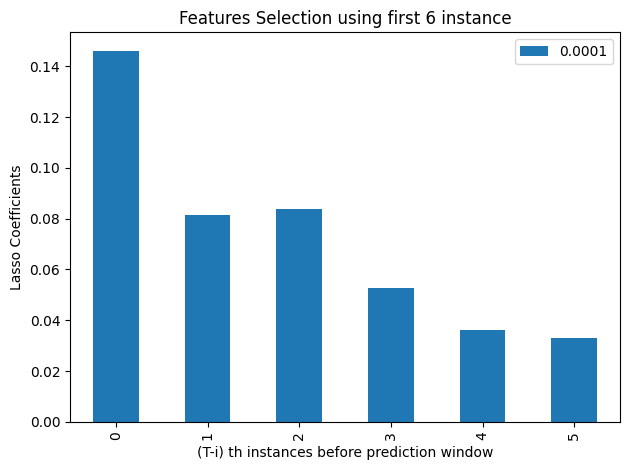

Training:  TSS:  0.4396108710858855 HSS:  0.34986684369571674 TP:  1345 FP:  2277 TN:  12192 FN:  908
Testing:  TSS:  0.3159251864276883 HSS:  0.2889246741459343 TP:  842 FP:  1577 TN:  13106 FN:  1147


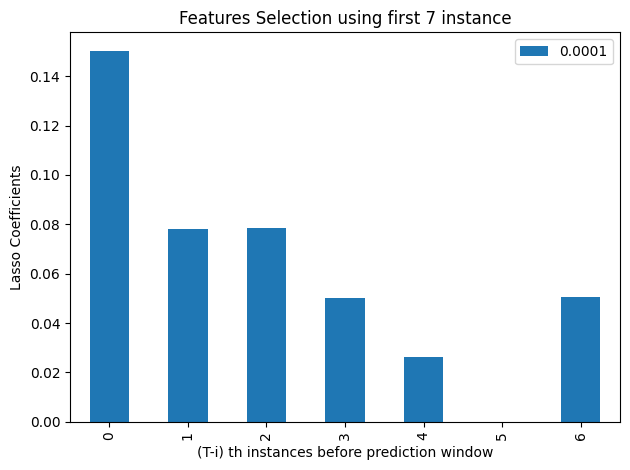

Training:  TSS:  0.4385050586593184 HSS:  0.3481561081154069 TP:  1345 FP:  2293 TN:  12176 FN:  908
Testing:  TSS:  0.3121073826771893 HSS:  0.2860585716491526 TP:  834 FP:  1574 TN:  13109 FN:  1155


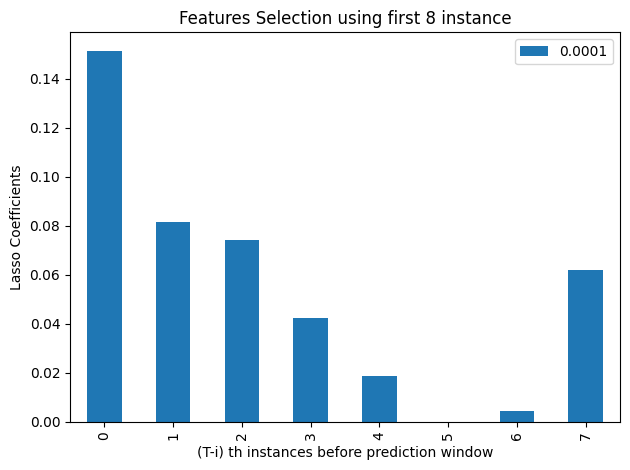

Training:  TSS:  0.4362857954547023 HSS:  0.34665194587938974 TP:  1340 FP:  2293 TN:  12176 FN:  913
Testing:  TSS:  0.3145270793491425 HSS:  0.28839120778736466 TP:  838 FP:  1568 TN:  13115 FN:  1151


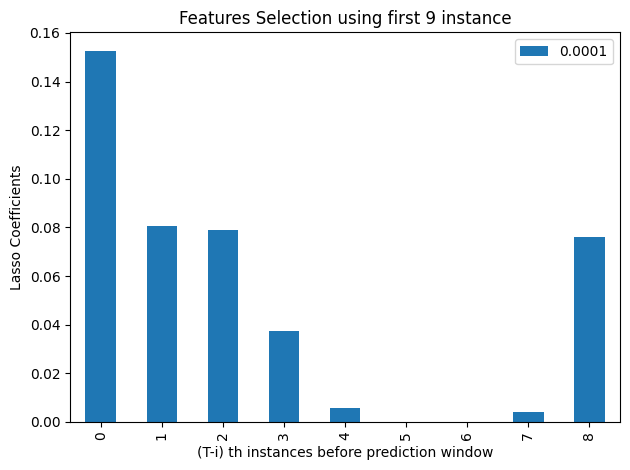

Training:  TSS:  0.43519075034287447 HSS:  0.345730404479916 TP:  1338 FP:  2296 TN:  12173 FN:  915
Testing:  TSS:  0.3142286320591764 HSS:  0.28834739666229264 TP:  837 FP:  1565 TN:  13118 FN:  1152


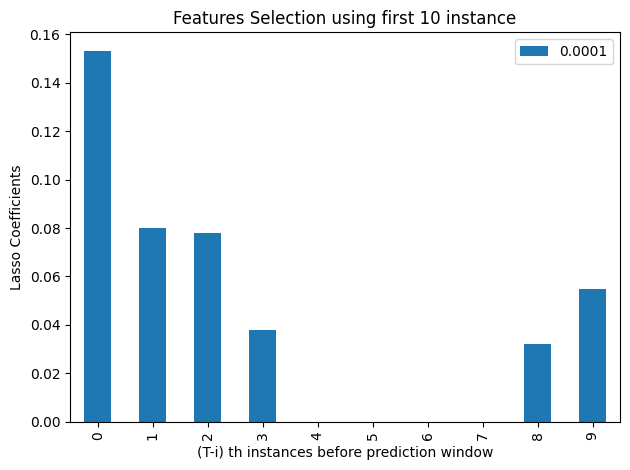

Training:  TSS:  0.4358711157947396 HSS:  0.34601338460408904 TP:  1340 FP:  2299 TN:  12170 FN:  913
Testing:  TSS:  0.311620676644654 HSS:  0.2866402176478633 TP:  831 FP:  1559 TN:  13124 FN:  1158


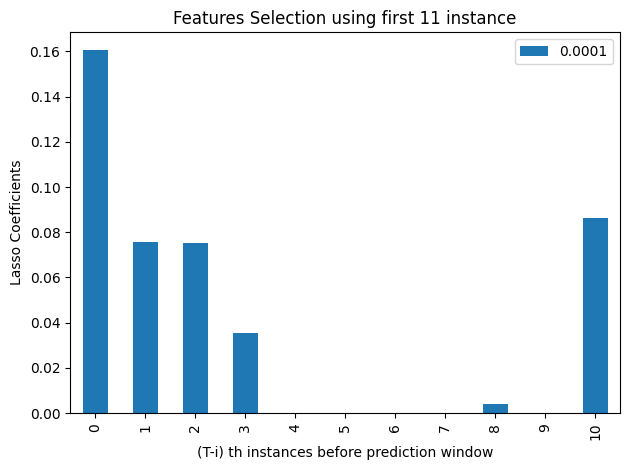

Training:  TSS:  0.43420475880340714 HSS:  0.34535835979366175 TP:  1335 FP:  2291 TN:  12178 FN:  918
Testing:  TSS:  0.31724522331106175 HSS:  0.29076760268994234 TP:  843 FP:  1565 TN:  13118 FN:  1146


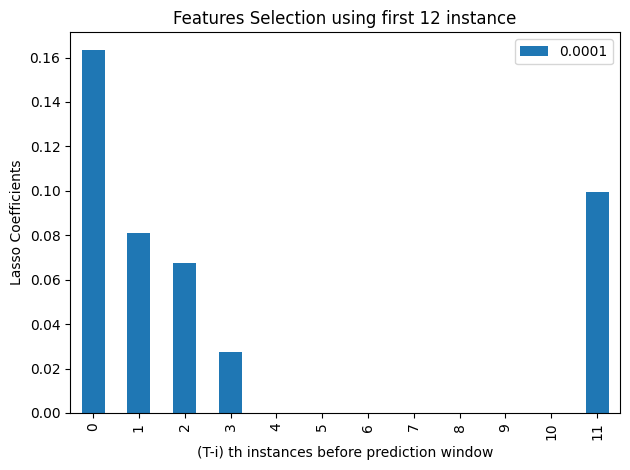

Training:  TSS:  0.43604928264376047 HSS:  0.346670466364081 TP:  1339 FP:  2290 TN:  12179 FN:  914
Testing:  TSS:  0.32067045040031006 HSS:  0.2939069567171355 TP:  849 FP:  1559 TN:  13124 FN:  1140


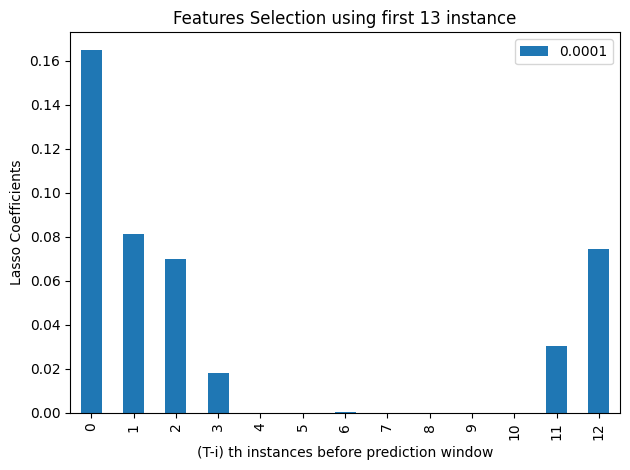

Training:  TSS:  0.43600934234806055 HSS:  0.3462261116835134 TP:  1340 FP:  2297 TN:  12172 FN:  913
Testing:  TSS:  0.317968365614503 HSS:  0.29253753714919317 TP:  842 FP:  1547 TN:  13136 FN:  1147


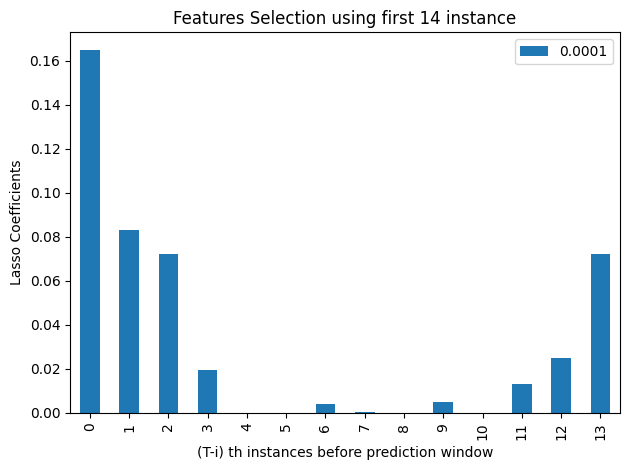

Training:  TSS:  0.4348635896257935 HSS:  0.34408759922425747 TP:  1341 FP:  2320 TN:  12149 FN:  912
Testing:  TSS:  0.31975904935429955 HSS:  0.29278002634531425 TP:  848 FP:  1565 TN:  13118 FN:  1141


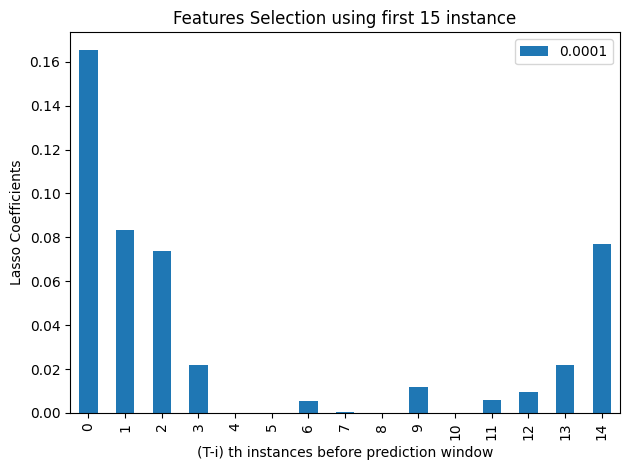

Training:  TSS:  0.4341540511929678 HSS:  0.3441384253171852 TP:  1338 FP:  2311 TN:  12158 FN:  915
Testing:  TSS:  0.32080666234609767 HSS:  0.2941489839656206 TP:  849 FP:  1557 TN:  13126 FN:  1140


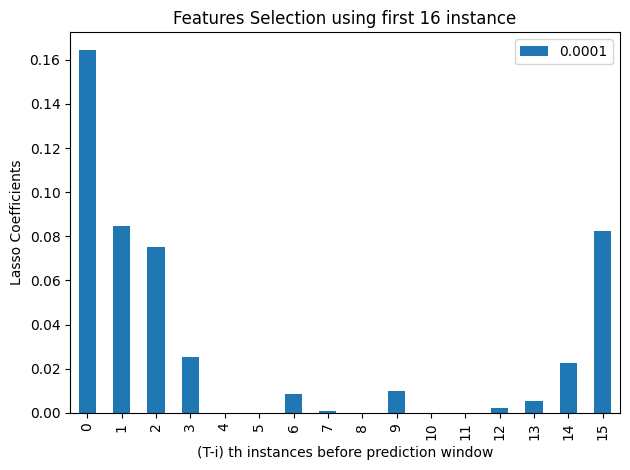

Training:  TSS:  0.4324078136102355 HSS:  0.34260159423002506 TP:  1335 FP:  2317 TN:  12152 FN:  918
Testing:  TSS:  0.3237551476250893 HSS:  0.2964389619074597 TP:  855 FP:  1558 TN:  13125 FN:  1134


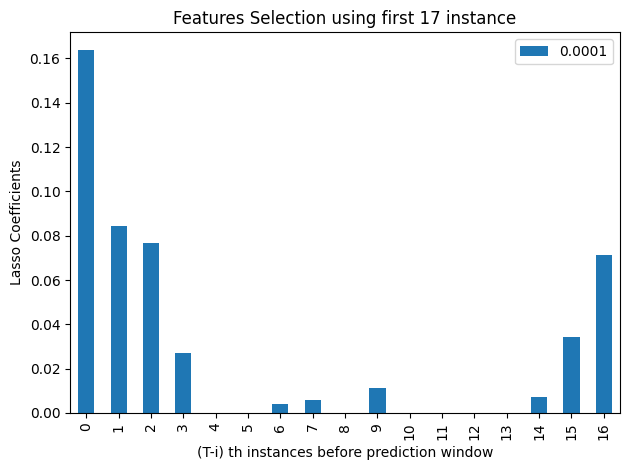

Training:  TSS:  0.4331173520430611 HSS:  0.34255352366963715 TP:  1338 FP:  2326 TN:  12143 FN:  915
Testing:  TSS:  0.32428393623212765 HSS:  0.29639231542536354 TP:  857 FP:  1565 TN:  13118 FN:  1132


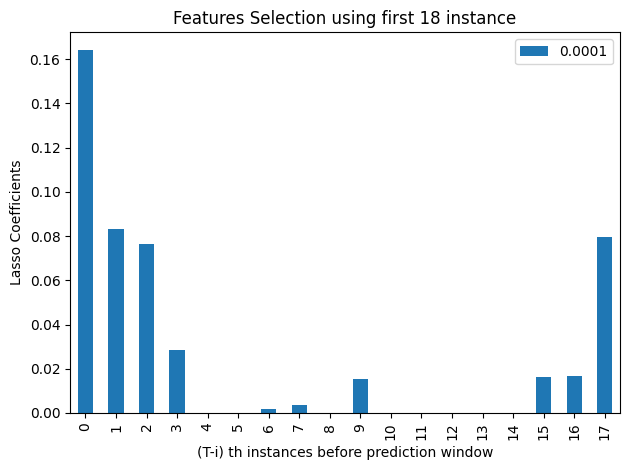

Training:  TSS:  0.43317569800498223 HSS:  0.34189035802311224 TP:  1340 FP:  2338 TN:  12131 FN:  913
Testing:  TSS:  0.3239694297660493 HSS:  0.29534220258440946 TP:  858 FP:  1577 TN:  13106 FN:  1131


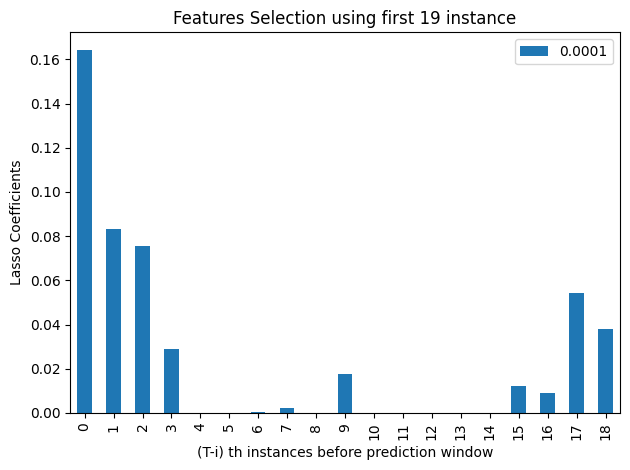

Training:  TSS:  0.4316767405479312 HSS:  0.34111084309470185 TP:  1336 FP:  2334 TN:  12135 FN:  917
Testing:  TSS:  0.32604859657353336 HSS:  0.2970610798117818 TP:  862 FP:  1576 TN:  13107 FN:  1127


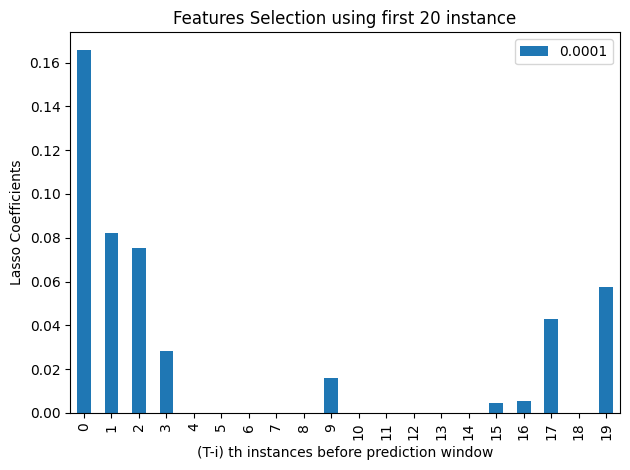

Training:  TSS:  0.42841313984192664 HSS:  0.3398906957001908 TP:  1326 FP:  2317 TN:  12152 FN:  927
Testing:  TSS:  0.3251792781020259 HSS:  0.2965038888938497 TP:  860 FP:  1574 TN:  13109 FN:  1129


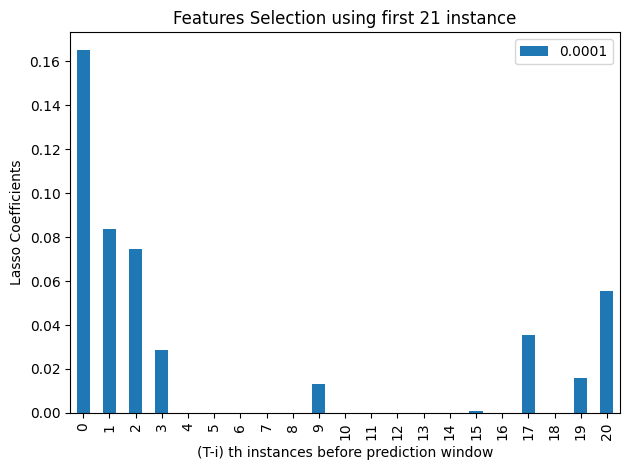

Training:  TSS:  0.4301302044436984 HSS:  0.3417610059857856 TP:  1328 FP:  2305 TN:  12164 FN:  925
Testing:  TSS:  0.32407961831344617 HSS:  0.29602916371966664 TP:  857 FP:  1568 TN:  13115 FN:  1132


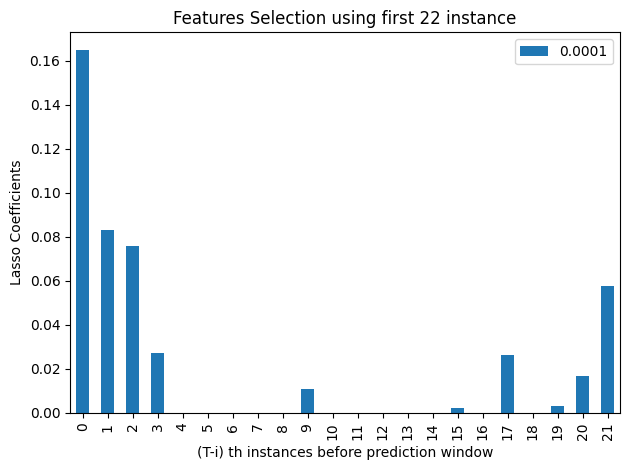

Training:  TSS:  0.42997357222415633 HSS:  0.3426568144063235 TP:  1325 FP:  2288 TN:  12181 FN:  928
Testing:  TSS:  0.32288582915358177 HSS:  0.2958785012733044 TP:  853 FP:  1556 TN:  13127 FN:  1136


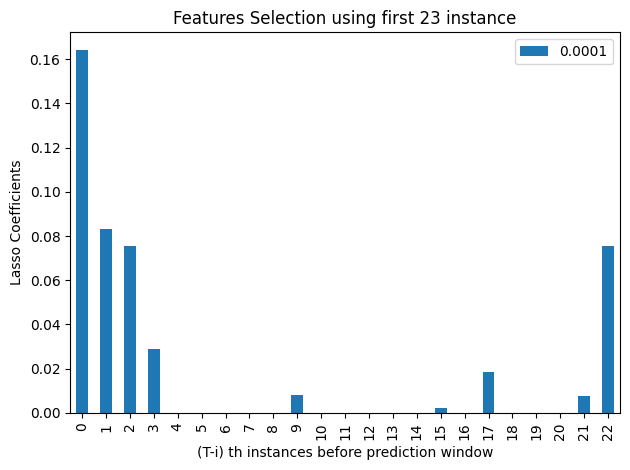

Training:  TSS:  0.4284346744714054 HSS:  0.34143042786603683 TP:  1322 FP:  2291 TN:  12178 FN:  931
Testing:  TSS:  0.3211471922105668 HSS:  0.294754896933954 TP:  849 FP:  1552 TN:  13131 FN:  1140


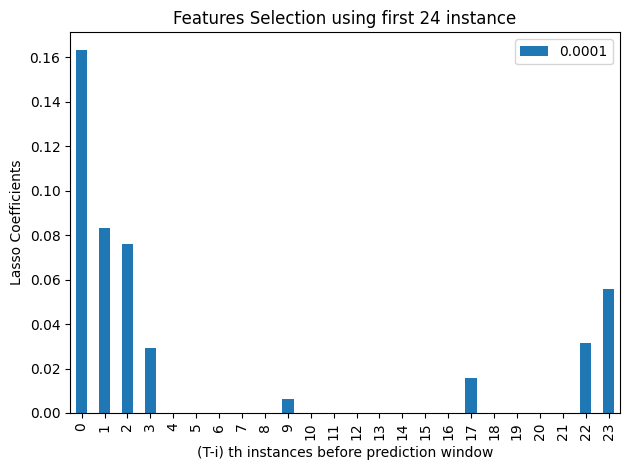

In [46]:
gen_data(res3_18_new, res4_18_new)
gen_data(res4_18_new, res3_18_new)

Training:  TSS:  0.4658586582201204 HSS:  0.345775663605445 TP:  1561 FP:  2774 TN:  11532 FN:  805
Testing:  TSS:  0.5358621819006124 HSS:  0.34684447628873327 TP:  2227 FP:  4093 TN:  9938 FN:  464


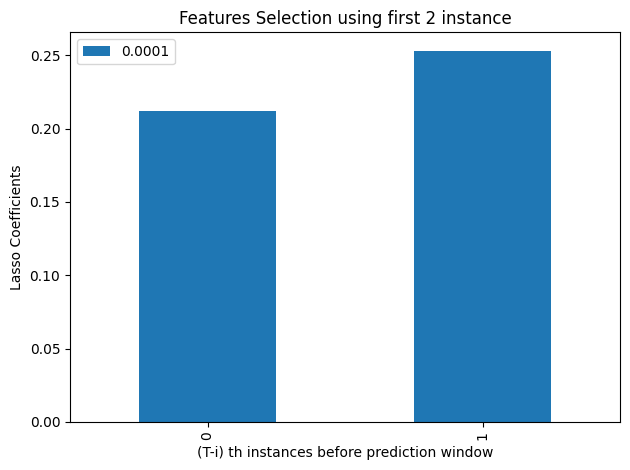

Training:  TSS:  0.4659220593148262 HSS:  0.346503146679341 TP:  1559 FP:  2761 TN:  11545 FN:  807
Testing:  TSS:  0.5340041365643062 HSS:  0.34580989193455347 TP:  2222 FP:  4093 TN:  9938 FN:  469


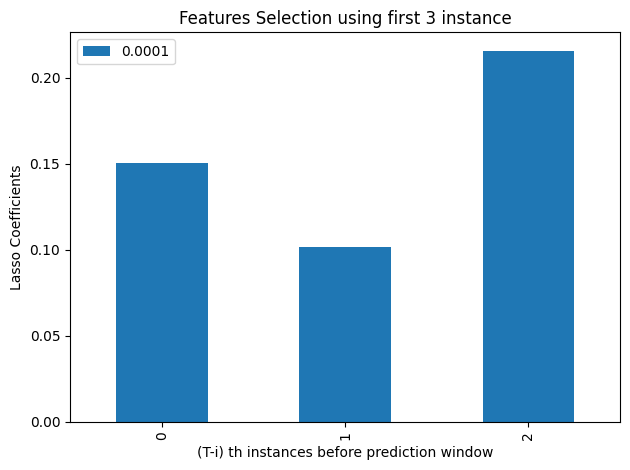

Training:  TSS:  0.4681653826713995 HSS:  0.3489954921292635 TP:  1561 FP:  2741 TN:  11565 FN:  805
Testing:  TSS:  0.5346048131836123 HSS:  0.34606426351612096 TP:  2224 FP:  4095 TN:  9936 FN:  467


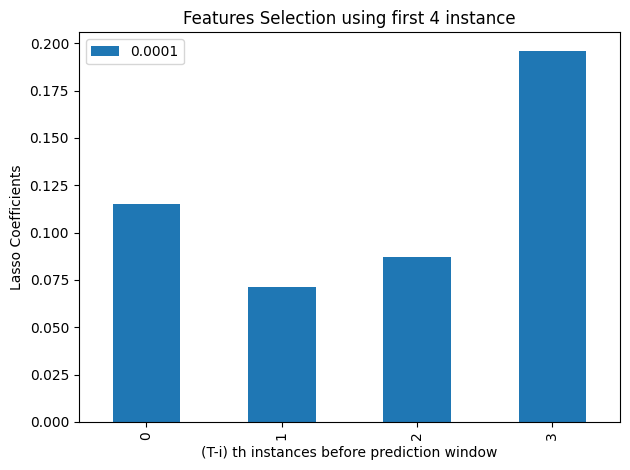

Training:  TSS:  0.4709077606839707 HSS:  0.3512245241707534 TP:  1566 FP:  2732 TN:  11574 FN:  800
Testing:  TSS:  0.5337750690122611 HSS:  0.3457624250385895 TP:  2221 FP:  4091 TN:  9940 FN:  470


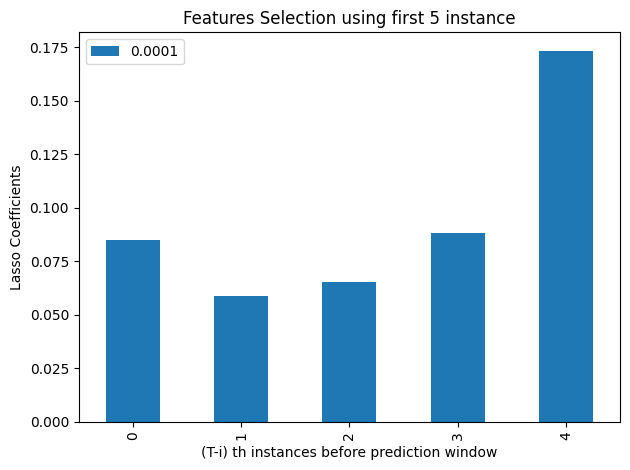

Training:  TSS:  0.471746569575345 HSS:  0.35240645435983387 TP:  1566 FP:  2720 TN:  11586 FN:  800
Testing:  TSS:  0.5301760149349184 HSS:  0.34319738172531045 TP:  2214 FP:  4105 TN:  9926 FN:  477


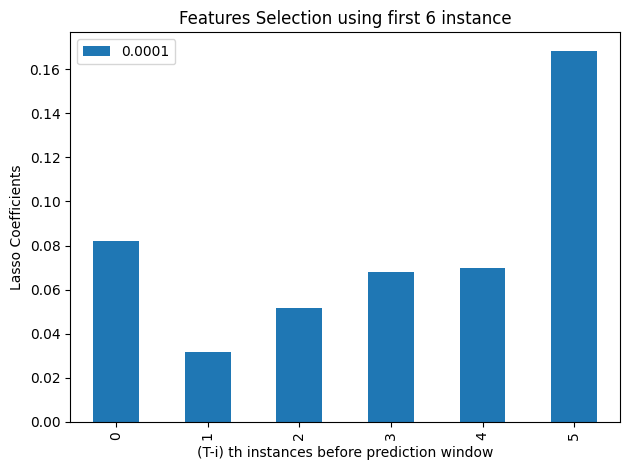

Training:  TSS:  0.4737232892606109 HSS:  0.35323153891608877 TP:  1572 FP:  2728 TN:  11578 FN:  794
Testing:  TSS:  0.5290764430123551 HSS:  0.3423857503525869 TP:  2212 FP:  4110 TN:  9921 FN:  479


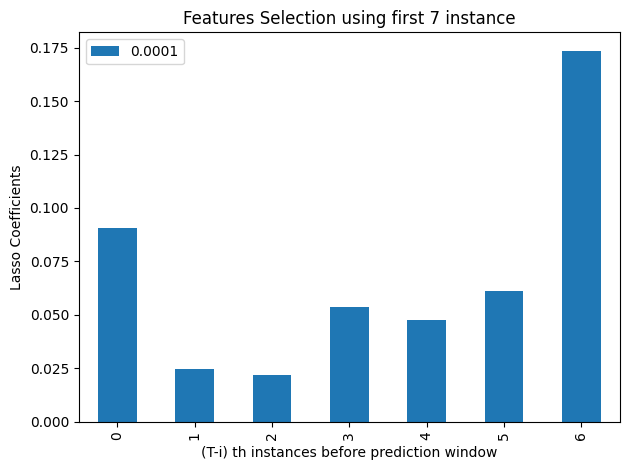

Training:  TSS:  0.47273492941797796 HSS:  0.3528193767771194 TP:  1569 FP:  2724 TN:  11582 FN:  797
Testing:  TSS:  0.528078652405841 HSS:  0.3412757279809551 TP:  2212 FP:  4124 TN:  9907 FN:  479


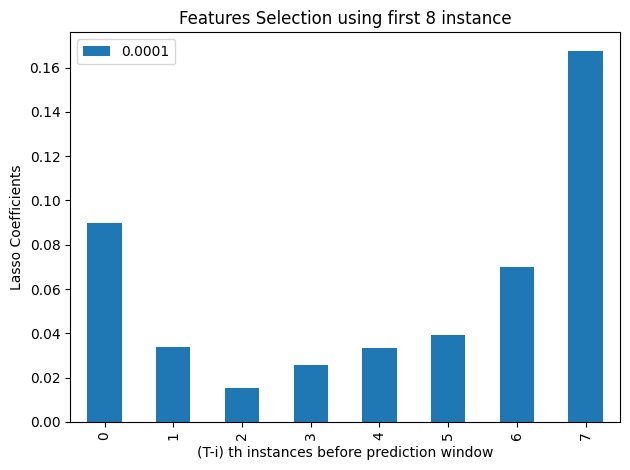

Training:  TSS:  0.47406954314222916 HSS:  0.3540484762303514 TP:  1571 FP:  2717 TN:  11589 FN:  795
Testing:  TSS:  0.5269078097256695 HSS:  0.34038692427125444 TP:  2210 FP:  4130 TN:  9901 FN:  481


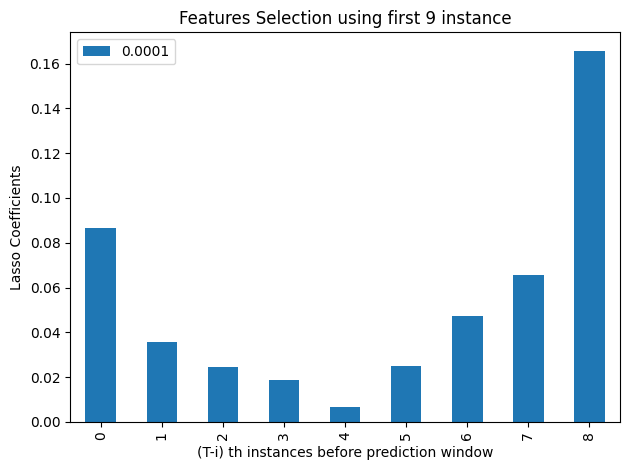

Training:  TSS:  0.4744157970238475 HSS:  0.3548680002623606 TP:  1570 FP:  2706 TN:  11600 FN:  796
Testing:  TSS:  0.5246221398437144 HSS:  0.33887748740563367 TP:  2205 FP:  4136 TN:  9895 FN:  486


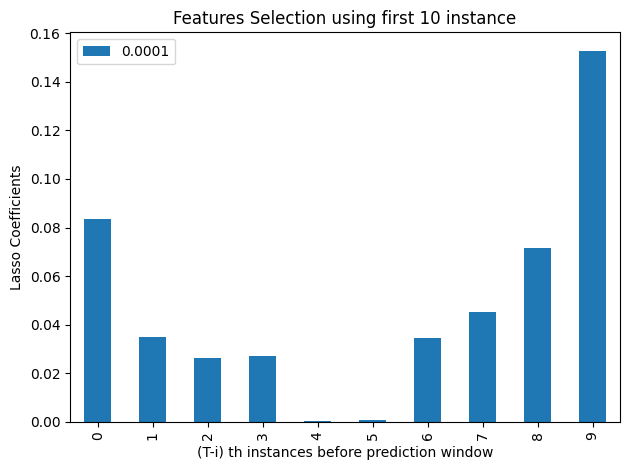

Training:  TSS:  0.4759601129709422 HSS:  0.35639932768968813 TP:  1572 FP:  2696 TN:  11610 FN:  794
Testing:  TSS:  0.5253806132574574 HSS:  0.3391042721409198 TP:  2208 FP:  4141 TN:  9890 FN:  483


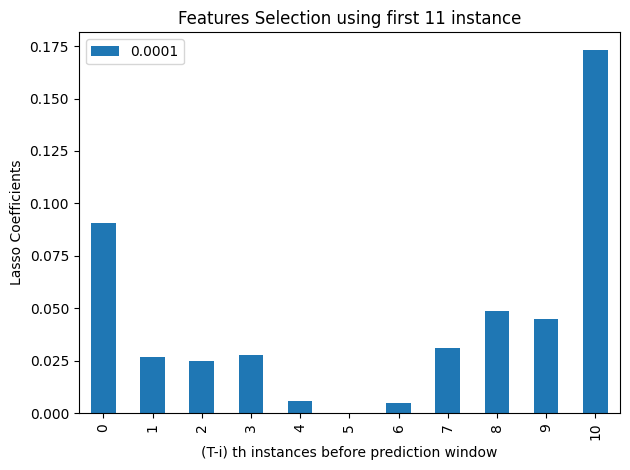

Training:  TSS:  0.4772280757773665 HSS:  0.3572072490638499 TP:  1575 FP:  2696 TN:  11610 FN:  791
Testing:  TSS:  0.5214507103120205 HSS:  0.3367962460812646 TP:  2198 FP:  4144 TN:  9887 FN:  493


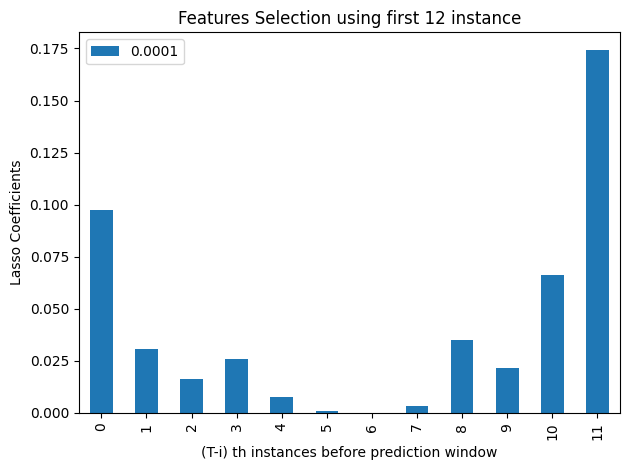

Training:  TSS:  0.4774410278233311 HSS:  0.35717802777720437 TP:  1576 FP:  2699 TN:  11607 FN:  790
Testing:  TSS:  0.5229931620594531 HSS:  0.3378908075741483 TP:  2201 FP:  4138 TN:  9893 FN:  490


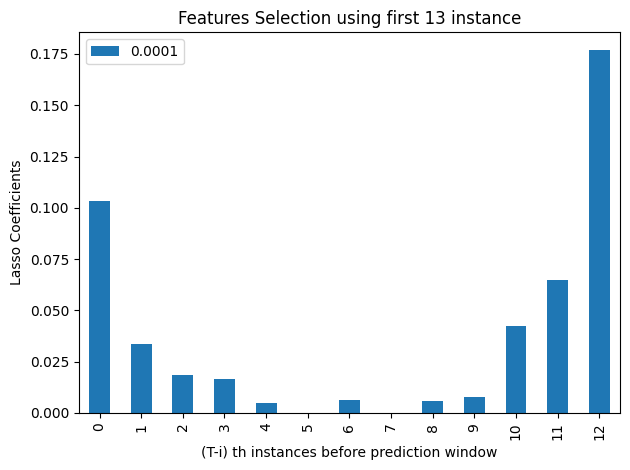

Training:  TSS:  0.4802598062230922 HSS:  0.3588606198851458 TP:  1583 FP:  2701 TN:  11605 FN:  783
Testing:  TSS:  0.5214354550328 HSS:  0.3369825000512199 TP:  2197 FP:  4139 TN:  9892 FN:  494


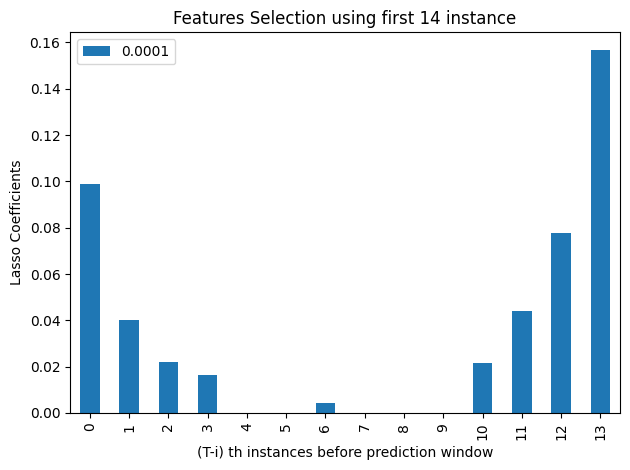

Training:  TSS:  0.47841963819660105 HSS:  0.3585725216096155 TP:  1576 FP:  2685 TN:  11621 FN:  790
Testing:  TSS:  0.5203358831102367 HSS:  0.33617401623682974 TP:  2195 FP:  4144 TN:  9887 FN:  496


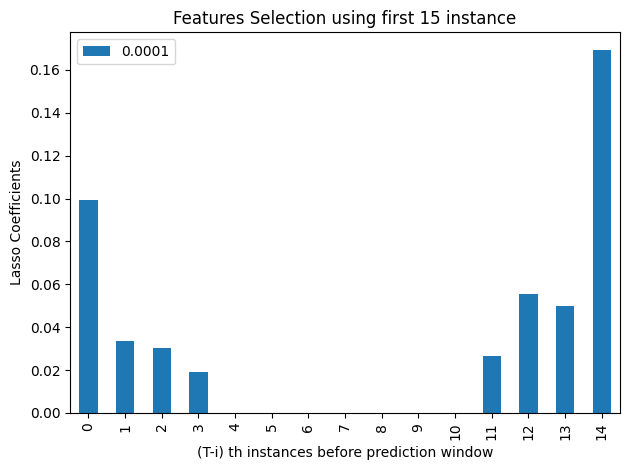

Training:  TSS:  0.4793413471214071 HSS:  0.3585523634818788 TP:  1580 FP:  2696 TN:  11610 FN:  786
Testing:  TSS:  0.5175920781241918 HSS:  0.33456361967034487 TP:  2188 FP:  4146 TN:  9885 FN:  503


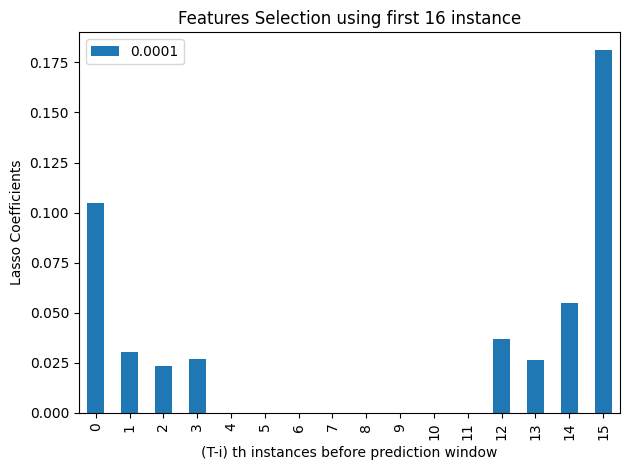

Training:  TSS:  0.47940799803923406 HSS:  0.35898110689093293 TP:  1579 FP:  2689 TN:  11617 FN:  787
Testing:  TSS:  0.517434281329755 HSS:  0.3345915334828746 TP:  2187 FP:  4143 TN:  9888 FN:  504


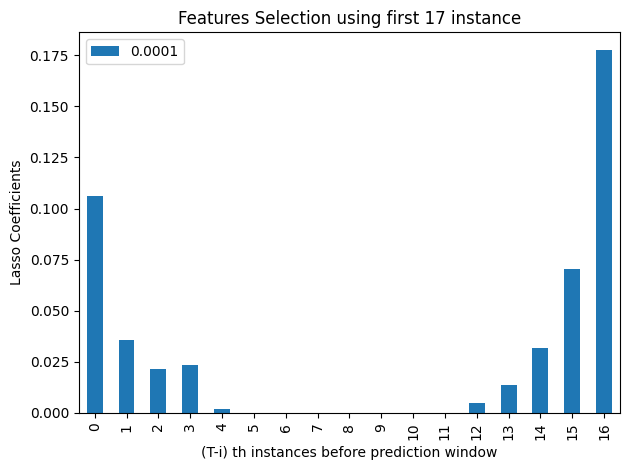

Training:  TSS:  0.4827859823665779 HSS:  0.3614628055808296 TP:  1586 FP:  2683 TN:  11623 FN:  780
Testing:  TSS:  0.5152046269261876 HSS:  0.3333439748157751 TP:  2181 FP:  4143 TN:  9888 FN:  510


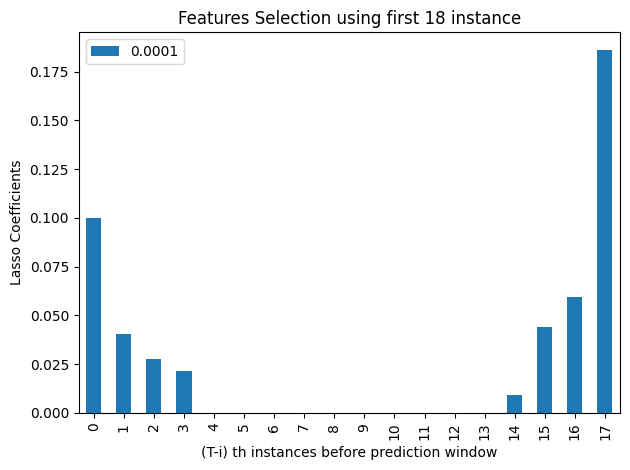

Training:  TSS:  0.48496265480532436 HSS:  0.363572595274433 TP:  1589 FP:  2670 TN:  11636 FN:  777
Testing:  TSS:  0.5145071746293266 HSS:  0.332376008582508 TP:  2182 FP:  4158 TN:  9873 FN:  509


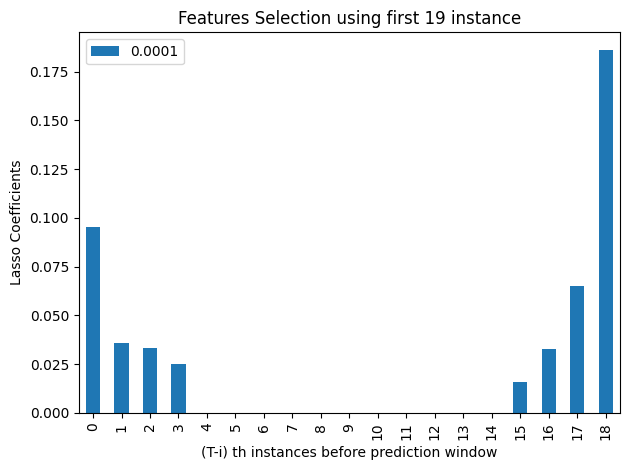

Training:  TSS:  0.48791473504073923 HSS:  0.366124630149508 TP:  1594 FP:  2658 TN:  11648 FN:  772
Testing:  TSS:  0.5111219328248082 HSS:  0.3300610359878824 TP:  2175 FP:  4169 TN:  9862 FN:  516


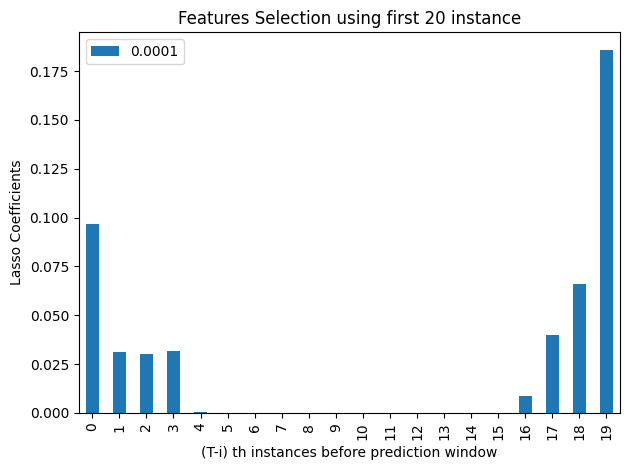

Training:  TSS:  0.490863565453033 HSS:  0.3690211558162214 TP:  1598 FP:  2640 TN:  11666 FN:  768
Testing:  TSS:  0.5096915120341508 HSS:  0.32948879683573845 TP:  2170 FP:  4163 TN:  9868 FN:  521


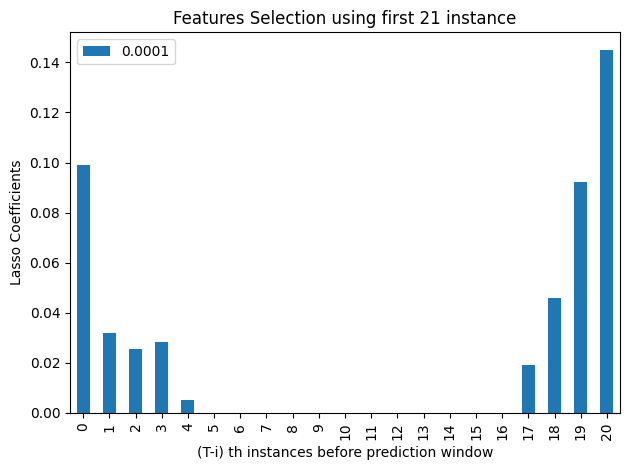

Training:  TSS:  0.4907936647120852 HSS:  0.3689196884392529 TP:  1598 FP:  2641 TN:  11665 FN:  768
Testing:  TSS:  0.5066778792968938 HSS:  0.3273817362066966 TP:  2164 FP:  4174 TN:  9857 FN:  527


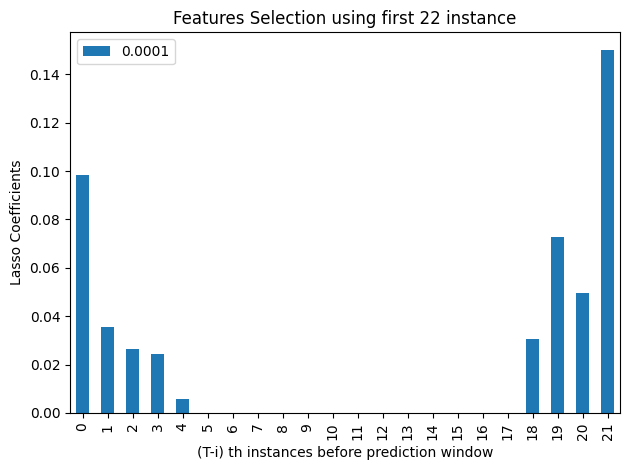

Training:  TSS:  0.49121631898089335 HSS:  0.369188442539549 TP:  1599 FP:  2641 TN:  11665 FN:  767
Testing:  TSS:  0.5071055038425427 HSS:  0.32784890475549844 TP:  2164 FP:  4168 TN:  9863 FN:  527


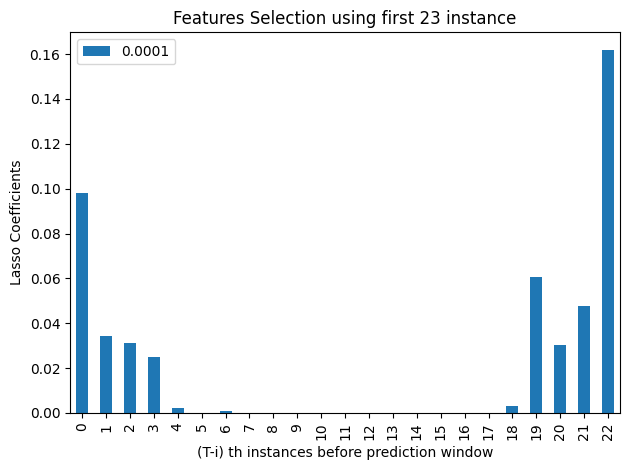

Training:  TSS:  0.4943082006982038 HSS:  0.37195600217918057 TP:  1604 FP:  2627 TN:  11679 FN:  762
Testing:  TSS:  0.506092457956808 HSS:  0.32694003007943007 TP:  2163 FP:  4177 TN:  9854 FN:  528


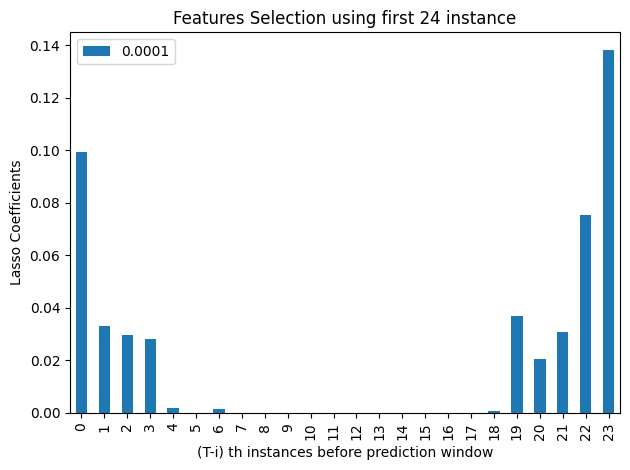

Training:  TSS:  0.5355465883117387 HSS:  0.346909958605722 TP:  2225 FP:  4087 TN:  9944 FN:  466
Testing:  TSS:  0.463608835217305 HSS:  0.3439256738681204 TP:  1557 FP:  2782 TN:  11524 FN:  809


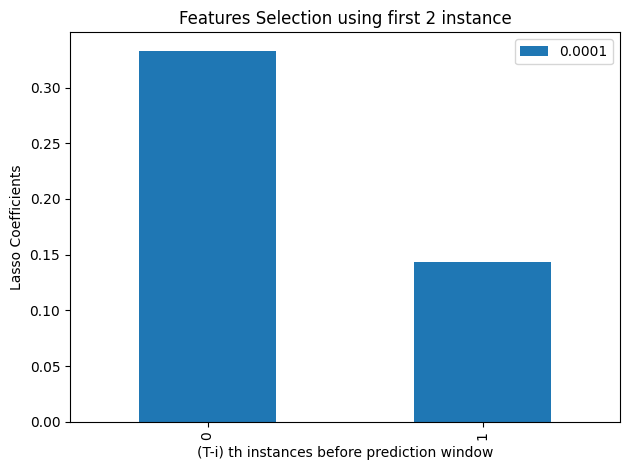

Training:  TSS:  0.5369057383447879 HSS:  0.3473848711123696 TP:  2230 FP:  4094 TN:  9937 FN:  461
Testing:  TSS:  0.4648702983774874 HSS:  0.34535855295618617 TP:  1558 FP:  2770 TN:  11536 FN:  808


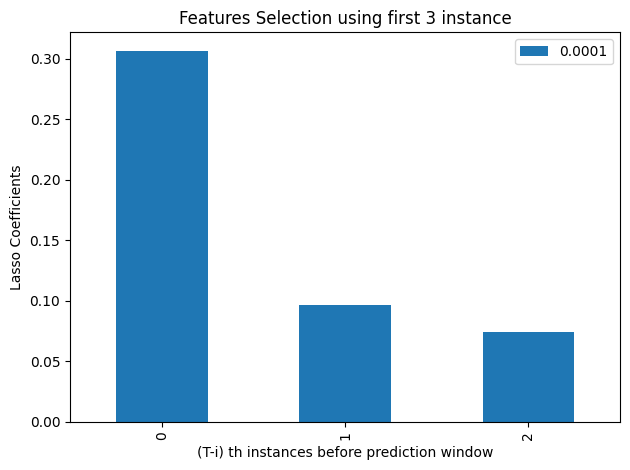

Training:  TSS:  0.5368344675871797 HSS:  0.34730501339385744 TP:  2230 FP:  4095 TN:  9936 FN:  461
Testing:  TSS:  0.46515315116439987 HSS:  0.3454328991440497 TP:  1559 FP:  2772 TN:  11534 FN:  807


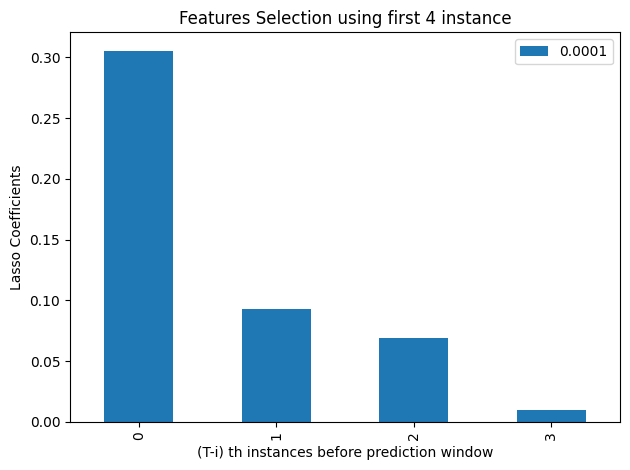

Training:  TSS:  0.5368344675871797 HSS:  0.34730501339385744 TP:  2230 FP:  4095 TN:  9936 FN:  461
Testing:  TSS:  0.46515315116439987 HSS:  0.3454328991440497 TP:  1559 FP:  2772 TN:  11534 FN:  807


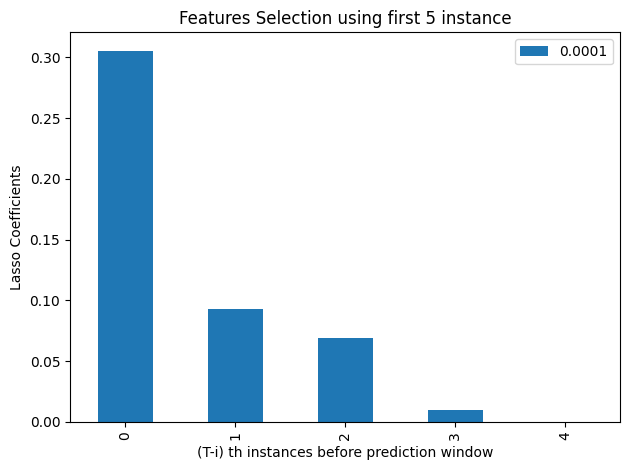

Training:  TSS:  0.5368344675871797 HSS:  0.34730501339385744 TP:  2230 FP:  4095 TN:  9936 FN:  461
Testing:  TSS:  0.46515315116439987 HSS:  0.3454328991440497 TP:  1559 FP:  2772 TN:  11534 FN:  807


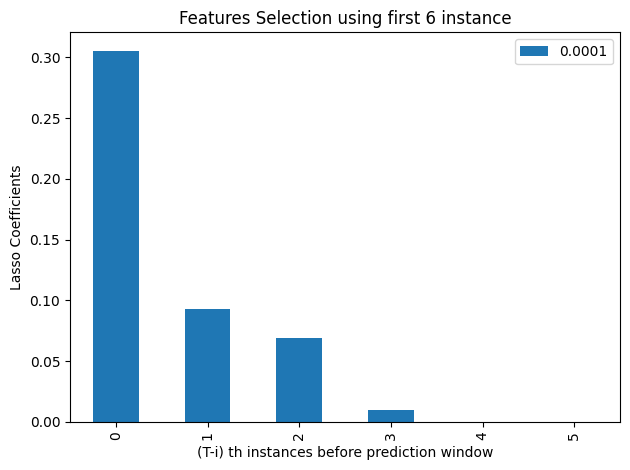

Training:  TSS:  0.5363915877623104 HSS:  0.3470184923286221 TP:  2229 FP:  4096 TN:  9935 FN:  462
Testing:  TSS:  0.4662146615711016 HSS:  0.34563267182773966 TP:  1563 FP:  2781 TN:  11525 FN:  803


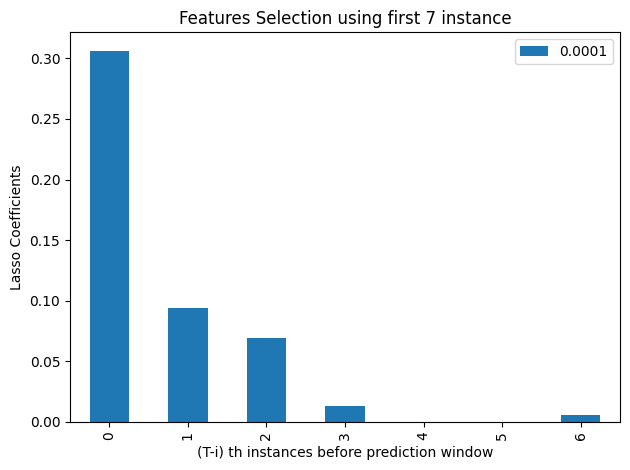

Training:  TSS:  0.5363963550370667 HSS:  0.34308843580353127 TP:  2248 FP:  4195 TN:  9836 FN:  443
Testing:  TSS:  0.47850572896546073 HSS:  0.34334148007772913 TP:  1624 FP:  2974 TN:  11332 FN:  742


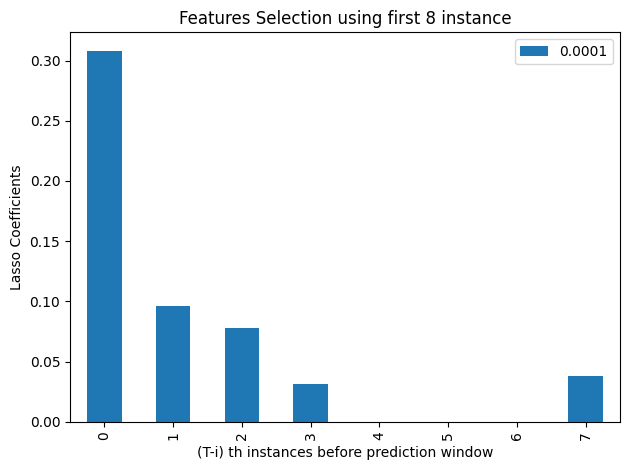

Training:  TSS:  0.5379740846176968 HSS:  0.3399507067212589 TP:  2272 FP:  4298 TN:  9733 FN:  419
Testing:  TSS:  0.47684595566603116 HSS:  0.33312847869674145 TP:  1651 FP:  3161 TN:  11145 FN:  715


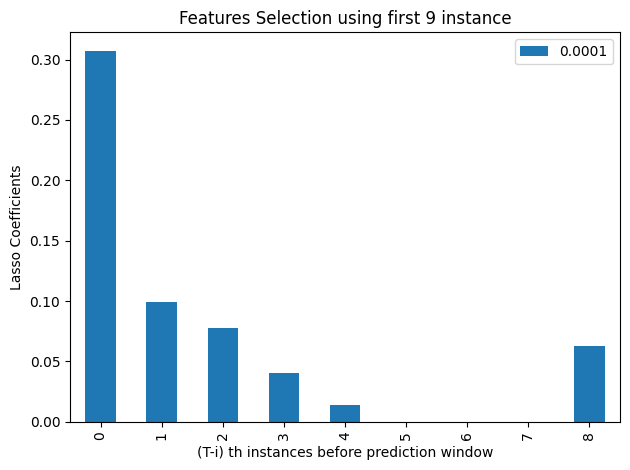

Training:  TSS:  0.536895011976586 HSS:  0.34078874287022376 TP:  2262 FP:  4261 TN:  9770 FN:  429
Testing:  TSS:  0.4770865607523707 HSS:  0.33695018760045853 TP:  1639 FP:  3085 TN:  11221 FN:  727


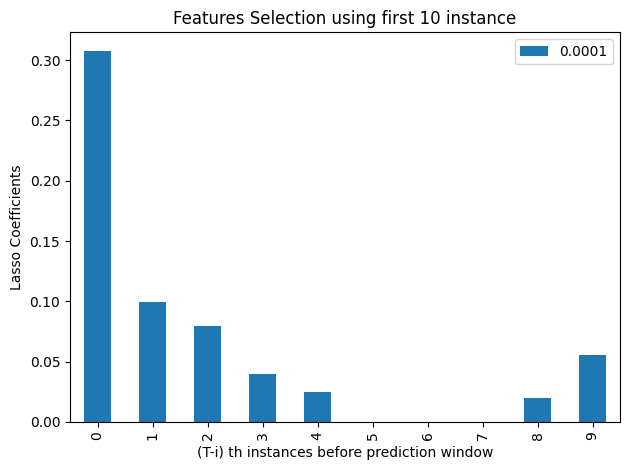

Training:  TSS:  0.5401524908176328 HSS:  0.33713631445277137 TP:  2298 FP:  4403 TN:  9628 FN:  393
Testing:  TSS:  0.47958992904631637 HSS:  0.32892546831759045 TP:  1678 FP:  3285 TN:  11021 FN:  688


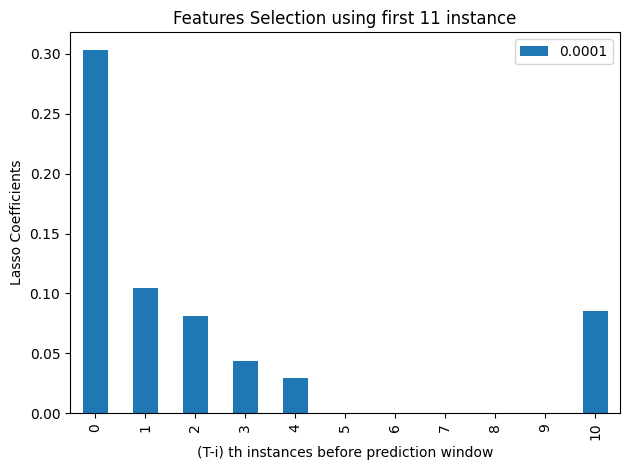

Training:  TSS:  0.5373073812430145 HSS:  0.3414410373789604 TP:  2261 FP:  4250 TN:  9781 FN:  430
Testing:  TSS:  0.4756592975253247 HSS:  0.3377513129936877 TP:  1630 FP:  3051 TN:  11255 FN:  736


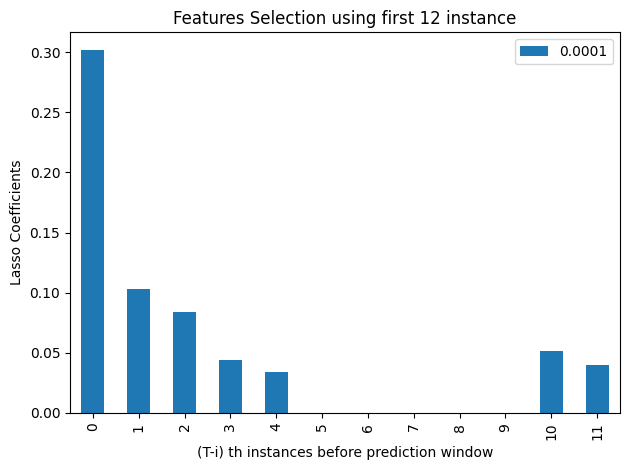

Training:  TSS:  0.5367424591843812 HSS:  0.342651570866219 TP:  2252 FP:  4211 TN:  9820 FN:  439
Testing:  TSS:  0.4737866312676236 HSS:  0.34038617006445904 TP:  1613 FP:  2975 TN:  11331 FN:  753


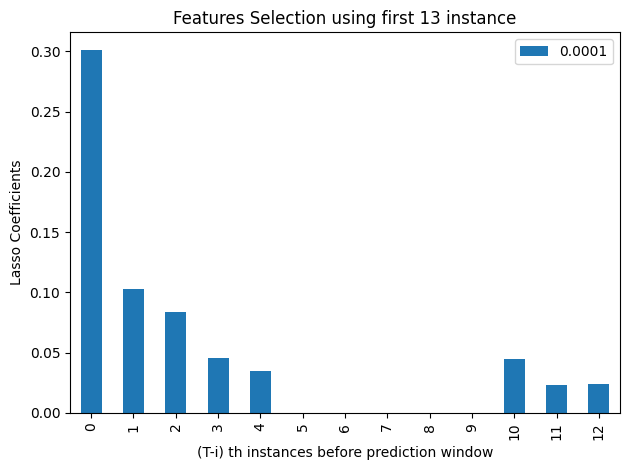

Training:  TSS:  0.5359229646537564 HSS:  0.34318120104056055 TP:  2245 FP:  4186 TN:  9845 FN:  446
Testing:  TSS:  0.47214966581773404 HSS:  0.34093820150027726 TP:  1604 FP:  2944 TN:  11362 FN:  762


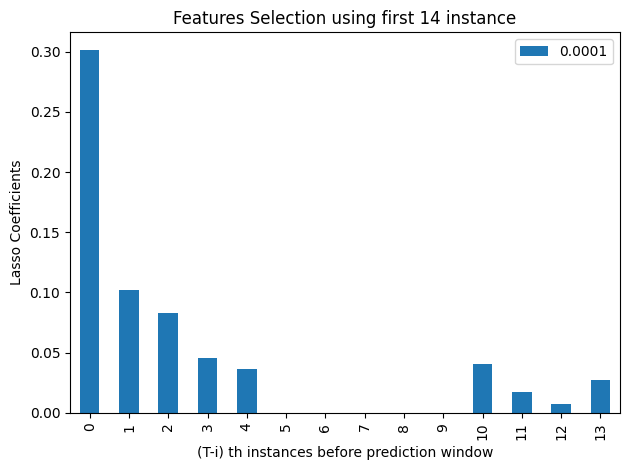

Training:  TSS:  0.535678641822491 HSS:  0.3433218771306604 TP:  2243 FP:  4179 TN:  9852 FN:  448
Testing:  TSS:  0.4730616252731772 HSS:  0.34185796211834674 TP:  1605 FP:  2937 TN:  11369 FN:  761


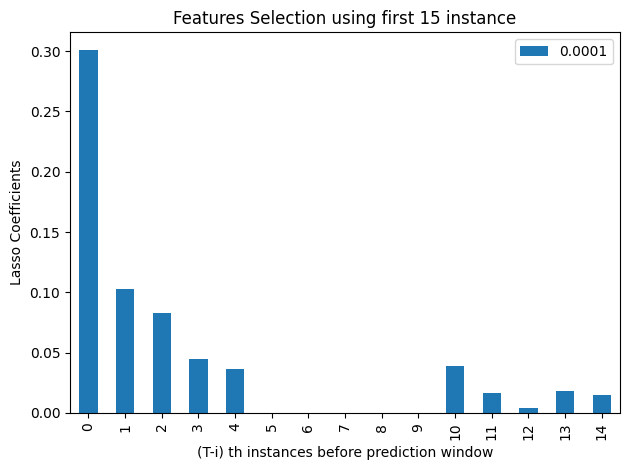

Training:  TSS:  0.5358211833377073 HSS:  0.343479349729599 TP:  2243 FP:  4177 TN:  9854 FN:  448
Testing:  TSS:  0.47334122823696856 HSS:  0.3422345001913496 TP:  1605 FP:  2933 TN:  11373 FN:  761


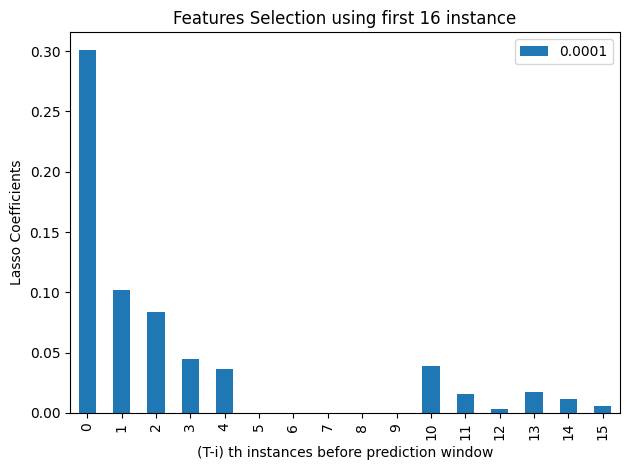

Training:  TSS:  0.5366204169506175 HSS:  0.3441573341686299 TP:  2244 FP:  4171 TN:  9860 FN:  447
Testing:  TSS:  0.4730616252731772 HSS:  0.34185796211834674 TP:  1605 FP:  2937 TN:  11369 FN:  761


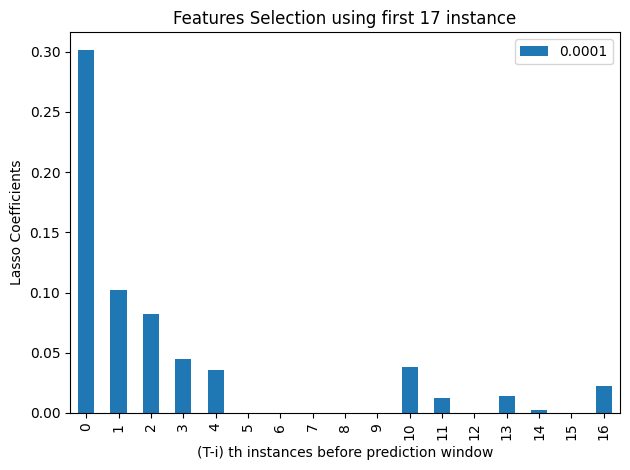

Training:  TSS:  0.5366204169506175 HSS:  0.3441573341686299 TP:  2244 FP:  4171 TN:  9860 FN:  447
Testing:  TSS:  0.4730616252731772 HSS:  0.34185796211834674 TP:  1605 FP:  2937 TN:  11369 FN:  761


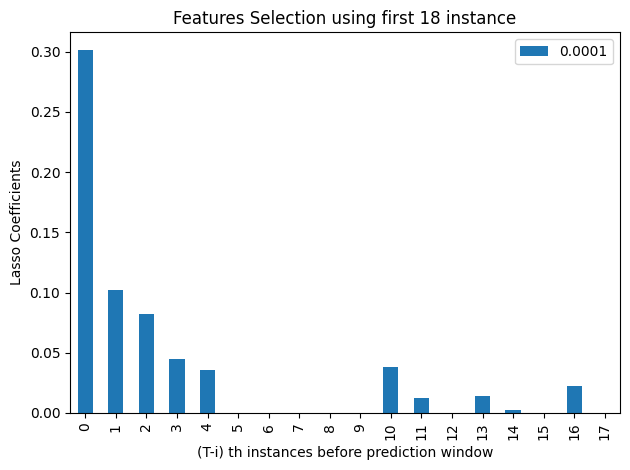

Training:  TSS:  0.5363200786409643 HSS:  0.34403098165189094 TP:  2243 FP:  4170 TN:  9861 FN:  448
Testing:  TSS:  0.4710150048469635 HSS:  0.34094390325156126 TP:  1599 FP:  2930 TN:  11376 FN:  767


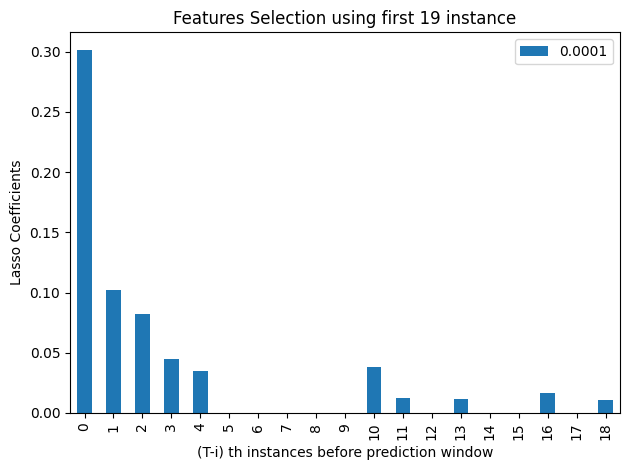

Training:  TSS:  0.5368494845026625 HSS:  0.34420479395728043 TP:  2245 FP:  4173 TN:  9858 FN:  446
Testing:  TSS:  0.4709987557313585 HSS:  0.3424624200004829 TP:  1594 FP:  2900 TN:  11406 FN:  772


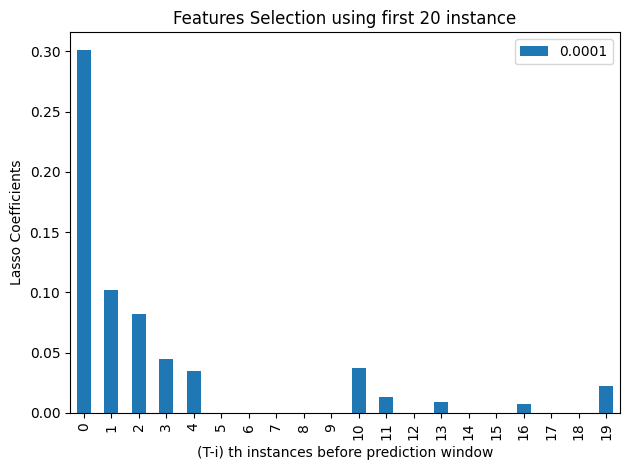

Training:  TSS:  0.5363353339201848 HSS:  0.3438420369231907 TP:  2244 FP:  4175 TN:  9856 FN:  447
Testing:  TSS:  0.4707256524138091 HSS:  0.3414755920837411 TP:  1596 FP:  2916 TN:  11390 FN:  770


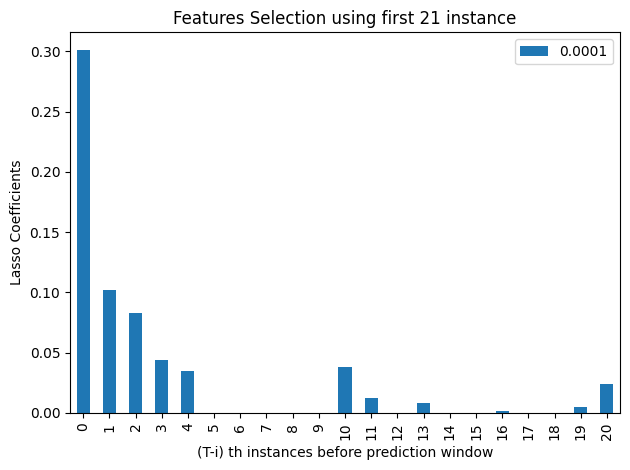

Training:  TSS:  0.5363353339201848 HSS:  0.3438420369231907 TP:  2244 FP:  4175 TN:  9856 FN:  447
Testing:  TSS:  0.4707256524138091 HSS:  0.3414755920837411 TP:  1596 FP:  2916 TN:  11390 FN:  770


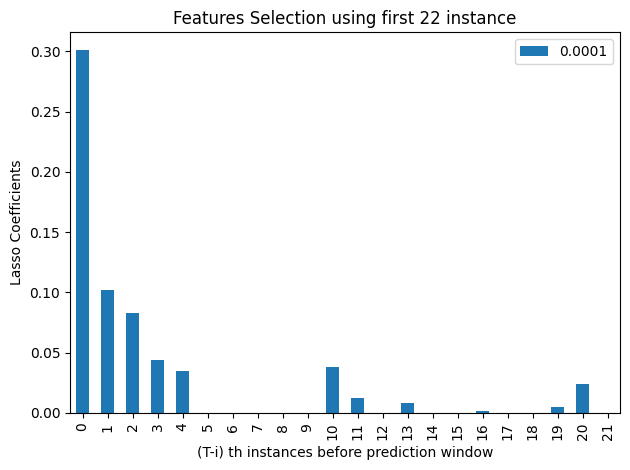

Training:  TSS:  0.5363353339201848 HSS:  0.3438420369231907 TP:  2244 FP:  4175 TN:  9856 FN:  447
Testing:  TSS:  0.4707256524138091 HSS:  0.3414755920837411 TP:  1596 FP:  2916 TN:  11390 FN:  770


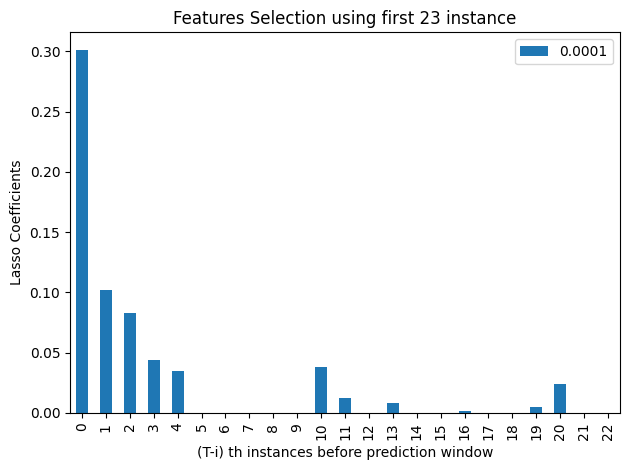

Training:  TSS:  0.5363353339201848 HSS:  0.3438420369231907 TP:  2244 FP:  4175 TN:  9856 FN:  447
Testing:  TSS:  0.4707256524138091 HSS:  0.3414755920837411 TP:  1596 FP:  2916 TN:  11390 FN:  770


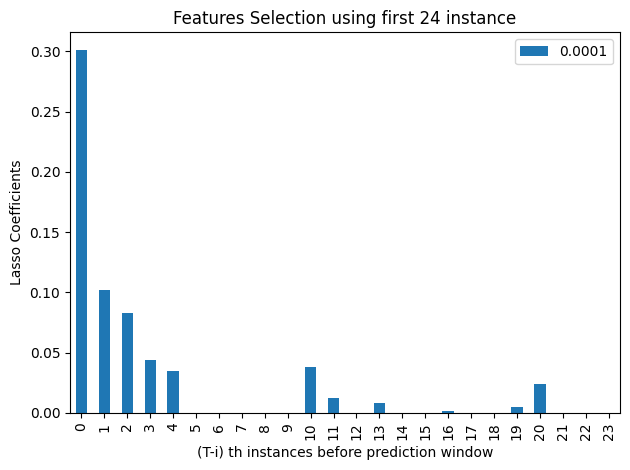

In [47]:
gen_data(res3_24_new, res4_24_new)
gen_data(res4_24_new, res3_24_new)

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

def plot_rf_feature_importance(forest_importances, result,  desc):
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title(desc)
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()


def rf_feature_sel(X_tr, y_tr, X_test, y_test):
    feature_names = list(X_tr.columns)
    forest = RandomForestClassifier(random_state=10)
    forest.fit(X_tr, y_tr)
    y_pred_tr = forest.predict(X_tr)
    y_pred_te = forest.predict(X_test)
    

    #Evaluation
    TSS, HSS, TP, FP, TN, FN = accuracy_score_with_conf_mat(y_pred_tr, y_tr)
    print("Training: ", "TSS: ", TSS, "HSS: ", HSS, "TP: ", TP, "FP: ", FP, "TN: ", TN, "FN: ", FN)
    TSS, HSS, TP, FP, TN, FN = accuracy_score_with_conf_mat(y_pred_te, y_test)
    print("Testing: ", "TSS: ", TSS, "HSS: ", HSS, "TP: ", TP, "FP: ", FP, "TN: ", TN, "FN: ", FN)
    
    result = permutation_importance(forest, X_tr, y_tr, n_repeats=2, random_state=10, n_jobs=-1)
    forest_importances = pd.Series(result.importances_mean, index=feature_names)
    print(forest_importances, result)
    return forest_importances, result

In [50]:
def gen_data_rf(train, test):
    for i in range(12):
        X_tr = train.iloc[:, list(range(i+1))]
        y_tr =  train['target']
        X_test = test.iloc[:, list(range(i+1))]
        y_test =  test['target']
        feat_importance, res   = rf_feature_sel(X_tr, y_tr, X_test, y_test)
        plot_rf_feature_importance(feat_importance, res, f'Features Selection using first {i+1} instance')  

        
# gen_data_rf(res3_6_new, res4_6_new)
# gen_data_rf(res4_6_new, res3_6_new)